In [1]:
!nvidia-smi 

Wed Jan 22 12:48:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 62%   64C    P2   149W / 250W |   3996MiB / 11019MiB |     57%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 60%   66C    P2   147W / 250W |   3936MiB / 11019MiB |     16%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
!ls

01_CNN.ipynb
SC_CNN_v0.ipynb
SC_CNN_v0.py
SC_CNN_v0_deepSC_Ln_jan20.ipynb
SC_CNN_v0_deepSC_Ln_jan21_nl1_test.ipynb
SC_CNN_v0_deepSC__newbn_jan22-Copy1.ipynb
SC_CNN_v0_deepSC__newbn_jan22.ipynb
SC_CNN_v0_deepSC_dilation_jan22.ipynb
SC_CNN_v0_deepSC_dilation_newbn_jan22.ipynb
SC_CNN_v0_deepSC_jan22-b64s.ipynb
Untitled.ipynb
__pycache__
class_acc_no_size.csv
class_acc_sized.csv
data
data.tar.gz
deepsc_nln_jan21.pt
deepscln_jan20.pt
elastic_test.ipynb
ln_jan20_testresult.csv
ln_jan20_testresult_9only.csv
ln_jan20_testresult_nl1.csv
ln_jan20_testresult_nl1_15-Copy1.csv
ln_jan20_testresult_nl1_15-Copy2.csv
ln_jan20_testresult_nl1_15.csv
ln_jan20_testresult_nl1_30.csv
ln_jan21_testresult_nl1_b128s.csv
ln_jan21_testresult_nl1_b16s.csv
ln_jan21_testresult_nl1_b32s.csv
ln_jan21_testresult_nl1_b64s.csv
mnist_4x
mnist_4x.tar.gz
mnist_png.tar
mnist_sized
mnist_sized.tar.gz
mnist_sized_trans.ipynb
nohup.out
parallel.py
sized_val
sized_val.tar.gz
test.csv
total_acc_no_size.csv
total_acc_sized.csv
unt

In [3]:
DATA_PATH = ''

In [4]:
import os

In [5]:
#!tar -zxvf 'mnist_4x.tar.gz'

In [6]:
INTERNAL_DATA_PATH = 'mnist_4x/'
INTERNAL_DATA_PATH_MAIN = 'mnist_4x/resized'
INTERNAL_DATA_PATH_OTHER = 'mnist_4x/centered'

In [7]:
import os
import fnmatch
 
# Get a list of all files in directory
for rootDir, subdirs, filenames in os.walk(INTERNAL_DATA_PATH):
    # Find the files that matches the given patterm
    for filename in fnmatch.filter(filenames, '.*'):
        try:
            #print(filename)
            os.remove(os.path.join(rootDir, filename))
        except OSError:
            print("Error while deleting file")

In [8]:
from time import sleep
from tqdm import tqdm
for _ in tqdm(range(10)):
    sleep(0.001)

100%|██████████| 10/10 [00:00<00:00, 915.93it/s]


In [9]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np

########################################################################
batch_size = 64
########################################################################


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
class SizedMnistDataset(Dataset):
    def __init__(self,dir_list,transform=None):
        self.dir_list = dir_list
        self.transform = transform
        
        self.dataset_list = []
        for i in range(len(dir_list)):
            temp_dataset = datasets.ImageFolder(root=self.dir_list[i],transform = self.transform)
            self.dataset_list.append(temp_dataset)
        
    def __len__(self):
        return len(self.dataset_list[0])
    
    def __getitem__(self,idx):
        return self.dataset_list[0][idx],self.dataset_list[1][idx],self.dataset_list[2][idx],self.dataset_list[3][idx],self.dataset_list[4][idx]
    

In [12]:
new_path = ['data/ds2','data/ds3','data/ds4','data/ds5','data/ds6']

train_dataset_path = [x+"/training" for x in new_path]
test_dataset_path = [x+"/testing" for x in new_path]
test_dataset_path

['data/ds2/testing',
 'data/ds3/testing',
 'data/ds4/testing',
 'data/ds5/testing',
 'data/ds6/testing']

In [13]:
#img_size = [729,243,81,27,9]  

transform = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainMnistDataset = SizedMnistDataset(train_dataset_path,transform)
testMnistDataset = SizedMnistDataset(test_dataset_path,transform)

trainloader = torch.utils.data.DataLoader(trainMnistDataset,
                                          batch_size = batch_size, 
                                          shuffle=True,
                                         num_workers=8)

testloader = torch.utils.data.DataLoader(testMnistDataset,
                                          batch_size = batch_size, 
                                          shuffle=False,
                                        num_workers=8)


In [14]:
import torch.nn as nn
import torch.nn.functional as F

class SCModule1(nn.Module):
    def __init__(self,in_channels,out_channels,output_number):
        super(SCModule1, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.output_number = output_number

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=9, padding=4,dilation=4)
        self.conv2 = nn.Conv2d(in_channels, out_channels, 3, stride=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, out_channels, 1)
        
        self.bn1_1 = nn.BatchNorm2d(out_channels)
        self.bn1_2 = nn.BatchNorm2d(out_channels)
        self.bn1_3 = nn.BatchNorm2d(out_channels)
        
        self.bn2_1 = nn.BatchNorm2d(out_channels)
        self.bn2_2 = nn.BatchNorm2d(out_channels)
        self.bn2_3 = nn.BatchNorm2d(out_channels)

        self.bn3_1 = nn.BatchNorm2d(out_channels)
        self.bn3_2 = nn.BatchNorm2d(out_channels)
        self.bn3_3 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x_1_1 = self.conv1(x[0])
        x_1_2 = self.conv1(x[1])
        x_1_3 = self.conv1(x[2])

        x_2_1 = self.conv2(x[1])
        x_2_2 = self.conv2(x[2])
        x_2_3 = self.conv2(x[3])

        x_3_1 = self.conv3(x[2])
        x_3_2 = self.conv3(x[3])
        x_3_3 = self.conv3(x[4])

        o_1_1 = torch.stack([x_1_1,x_2_1,x_3_1])
        o_1_1 = self.bn1_1(torch.sum(o_1_1,0))

        o_1_2 = torch.stack([F.conv2d(x[1], self.conv1.weight, bias=self.conv1.bias, stride=3, padding=4, dilation=4, groups=1),
                             F.conv2d(x[2], self.conv2.weight, bias=self.conv2.bias, stride=1, padding=1, dilation=1, groups=1)])
        o_1_2 = self.bn1_2(torch.sum(o_1_2,0))

        o_1_3 = self.bn1_3(F.conv2d(x[2], self.conv1.weight, bias=self.conv1.bias, stride=1, padding=4, dilation=4, groups=1))

        o_2_1 = torch.stack([x_1_2,x_2_2,x_3_2])
        o_2_1 = self.bn2_1(torch.sum(o_2_1,0))

        o_2_2 = torch.stack([F.conv2d(x[2], self.conv1.weight, bias=self.conv1.bias, stride=3, padding=4, dilation=4, groups=1),
                             F.conv2d(x[3], self.conv2.weight, bias=self.conv2.bias, stride=1, padding=1, dilation=1, groups=1)])
        o_2_2 = self.bn2_2(torch.sum(o_2_2,0))

        o_2_3 = self.bn2_3(F.conv2d(x[3], self.conv1.weight, bias=self.conv1.bias, stride=1, padding=4, dilation=4, groups=1))

        o_3_1 = torch.stack([x_1_3,x_2_3,x_3_3])
        o_3_1 = self.bn3_1(torch.sum(o_3_1,0))

        o_3_2 = torch.stack([F.conv2d(x[3], self.conv1.weight, bias=self.conv1.bias, stride=3, padding=4, dilation=4, groups=1),
                             F.conv2d(x[4], self.conv2.weight, bias=self.conv2.bias, stride=1, padding=1, dilation=1, groups=1)])
        o_3_2 = self.bn3_2(torch.sum(o_3_2,0))

        o_3_3 = self.bn3_3(F.conv2d(x[4], self.conv1.weight, bias=self.conv1.bias, stride=1, padding=4, dilation=4, groups=1))

        #print(torch.cat([o_1_1,o_1_2,o_1_3],dim=1).size())

        return [torch.cat([o_1_1,o_1_2,o_1_3],dim=1),
                torch.cat([o_2_1,o_2_2,o_2_3],dim=1),
                torch.cat([o_3_1,o_3_2,o_3_3],dim=1)]
        
            
        '''outputs = []
        for i in range(self.output_number):
            x_1_1 = self.conv1(x[0+i]) 
            x_1_2 = self.conv2(x[1+i]) 
            x_1_3 = self.conv3(x[2+i]) 
            #return [x_1_1,x_1_2,x_1_3]
            x_1 = torch.stack([x_1_1,x_1_2,x_1_3])
            x_1 = torch.sum(x_1,0)
            #print(x_1.size())
            #x_1 = torch.cat([x_1_1,x_1_2],dim=1)
            outputs.append(x_1)
        return outputs'''
    

    
#model = SCModule(3,6,3)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class SCModule2(nn.Module):
    def __init__(self,in_channels,out_channels,output_number):
        super(SCModule2, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.output_number = output_number

        self.conv1 = nn.Conv2d(in_channels, out_channels, 9, stride=9, padding=4)
        self.conv2 = nn.Conv2d(in_channels, out_channels, 3, stride=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, out_channels, 1)
        
        self.bn4 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x_1_1 = self.conv1(x[0]) 
        x_1_2 = self.conv2(x[1]) 
        x_1_3 = self.conv3(x[2]) 
        #return [x_1_1,x_1_2,x_1_3]
        x_1 = torch.stack([x_1_1,x_1_2,x_1_3])
        x_1 = torch.sum(x_1,0)
        #print(x_1.size())
        #x_1 = torch.cat([x_1_1,x_1_2],dim=1)
        return self.bn4(x_1)
        
            
        '''outputs = []
        for i in range(self.output_number):
            x_1_1 = self.conv1(x[0+i]) 
            x_1_2 = self.conv2(x[1+i]) 
            x_1_3 = self.conv3(x[2+i]) 
            #return [x_1_1,x_1_2,x_1_3]
            x_1 = torch.stack([x_1_1,x_1_2,x_1_3])
            x_1 = torch.sum(x_1,0)
            #print(x_1.size())
            #x_1 = torch.cat([x_1_1,x_1_2],dim=1)
            outputs.append(x_1)
        return outputs'''
    

    
#model = SCModule(3,6,3)

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self,batch_size):
        super(Net, self).__init__()
        self.sc1 = SCModule1(3,6,3) 
        self.sc2 = SCModule1(18,10,3)
        self.sc3 = SCModule1(30,15,3)
        self.sc4 = SCModule1(45,20,3)
        self.sc5 = SCModule2(60,90,1)
        
        self.fc2 = nn.Linear(90*3*3,120)
        self.fc3 = nn.Linear(120,84)
        self.fc4 = nn.Linear(84,10)
        
        tensor = torch.tensor((), dtype=torch.float)
 
        self.pad1 = tensor.new_zeros((batch_size,60,243,243))#.to('cuda')
        self.pad2 = tensor.new_zeros((batch_size,60,81,81))#.to('cuda')


    def forward(self, i1,i2,i3,i4,i5):
        self.pad1 = self.pad1.to(i1.device)
        self.pad2 = self.pad2.to(i1.device)
        x1_1,x1_2,x1_3 = self.sc1([i1,i2,i3,i4,i5])
        #x1_2,x1_3 = self.sc1([i2,i3,i4,i5])
        x1_1 = F.relu(x1_1)
        x1_2 = F.relu(x1_2)
        x1_3 = F.relu(x1_3)
        
        #print(x1_1)
        #print(self.pad1)
        bat_size = x1_1.size()[0]
        chan_size = x1_1.size()[1]
        x2_1,x2_2,x2_3 = self.sc2([self.pad1[:bat_size,:chan_size,:,:],self.pad2[:bat_size,:chan_size,:,:],x1_1,x1_2,x1_3])
        #x1_2,x1_3 = self.sc1([i2,i3,i4,i5])
        x2_1 = F.relu(x2_1)
        x2_2 = F.relu(x2_2)
        x2_3 = F.relu(x2_3)
        
        bat_size = x2_1.size()[0]
        chan_size = x2_1.size()[1]
        x3_1,x3_2,x3_3 = self.sc3([self.pad1[:bat_size,:chan_size,:,:],self.pad2[:bat_size,:chan_size,:,:],x2_1,x2_2,x2_3])
        #x1_2,x1_3 = self.sc1([i2,i3,i4,i5])
        x3_1 = F.relu(x3_1)
        x3_2 = F.relu(x3_2)
        x3_3 = F.relu(x3_3)
        
        bat_size = x3_1.size()[0]
        chan_size = x3_1.size()[1]
        x4_1,x4_2,x4_3 = self.sc4([self.pad1[:bat_size,:chan_size,:,:],self.pad2[:bat_size,:chan_size,:,:],x3_1,x3_2,x3_3])
        #x1_2,x1_3 = self.sc1([i2,i3,i4,i5])
        x4_1 = F.relu(x4_1)
        x4_2 = F.relu(x4_2)
        x4_3 = F.relu(x4_3)
    
        #print(x1_1.size())
        
        #x1_1 = x1_1.view(-1,6*81*81)
        #x1_2 = x1_2.view(-1,6*27*27)
        #x1_3 = x1_3.view(-1,6*9*9)
        
        #x1_1 = F.relu(self.fc1_1(x1_1))
        #x1_2 = F.relu(self.fc1_2(x1_2))
        #x1_3 = F.relu(self.fc1_3(x1_3))
        
        #x2 = torch.cat([x1_1,x1_2,x1_3],dim=1)
        
        x2 = self.sc5([x4_1,x4_2,x4_3])
        x2 = F.relu(x2)
        
        #print(x2.size())
        
        #print(x2_1.size())
        
        #print(x3.size())
        
        x2 = x2.view(-1, 90 * 3 * 3)
        x2 = F.relu(self.fc2(x2))
        x2 = F.relu(self.fc3(x2))
        x2 = self.fc4(x2)
        #print(x4.shape)
        return x2

In [18]:
from parallel import DataParallelModel,DataParallelCriterion
from torch.nn.parallel.data_parallel import DataParallel
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_ids = [0,1]
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '29503'
dist.init_process_group(backend='nccl',rank=0,world_size=1)

In [19]:
model = Net(batch_size).to('cuda:3')
if torch.cuda.device_count() > 10:
    model = DDP(model,device_ids = [0,1])
#model.to(device)

In [20]:
print(device)

cuda


In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#criterion = DataParallelCriterion(criterion,device_ids=[0,1])
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
SIZED_VAL_PATH = 'sized_val'
new_path = []
for i in os.listdir('mnist_sized'):
    #print(i)
    temp = []
    for j in range(1,6):
        temp.append(os.path.join(SIZED_VAL_PATH,str(i),'ds'+str(j)))
    new_path.append(temp)

new_path.sort(key=lambda x:int(x[0].split('/')[1]))

val_gen_arr = []
for i in tqdm(range(0,len(new_path))):
    transform = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testMnistDataset = SizedMnistDataset(new_path[i],transform)

    testloader = torch.utils.data.DataLoader(testMnistDataset,
                                              batch_size = batch_size, 
                                              shuffle=False,
                                            num_workers=8)
    val_gen_arr.append(testloader)
#
#val_gen_arr
accuracy = []


100%|██████████| 112/112 [00:01<00:00, 63.51it/s]


In [23]:
import torch.optim as optim
from tqdm import tqdm
import sys

trn_loss_list = []
val_loss_list = []
acc_list = []
num_batches = len(trainloader)
for epoch in range(30):
    running_loss = 0.0
    model.train()
    device = 'cuda:3'
    for i,images in tqdm(enumerate(trainloader)):
        #data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        c1 = images[0][0].to(device)
        c2 = images[1][0].to(device)
        c3 = images[2][0].to(device)
        c4 = images[3][0].to(device)
        c5 = images[4][0].to(device)
        c6 = images[0][1].to(device)
        #c61 = c6[:128].to('cuda:0')
        #c62 = c6[128:].to('cuda:1')
        output = model(c1,c2,c3,c4,c5)
        #output = torch.nn.parallel.gather(output,'cuda:1')
        loss = criterion(output, c6)
        loss.backward()    # calc gradients
        optimizer.step()   # update gradients
        running_loss += loss.item()
        #print(i)
    
    model.eval()
    with torch.no_grad(): # very very very very important!!!
        val_loss = 0.0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        correct = 0
        total = 0
        for j,val in enumerate(testloader):
            v1 = val[0][0].to(device)
            v2 = val[1][0].to(device)
            v3 = val[2][0].to(device)
            v4 = val[3][0].to(device)
            v5 = val[4][0].to(device)
            val_labels = val[0][1].to(device)
            val_output = model(v1,v2,v3,v4,v5)
            v_loss = criterion(val_output, val_labels)
            val_loss += v_loss
            _, predicted = torch.max(val_output, 1)
            c = (predicted == val_labels).squeeze()
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
            for i in range(len(val_labels)):
                val_label = val_labels[i]
                class_correct[val_label] += c[i].item()
                class_total[val_label] += 1

        for i in range(10):
            if class_total[i]==0:
                print('class_total = 0',class_correct,class_total)
            else:
                print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

    print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
        epoch+1, 30, i+1, num_batches, running_loss / len(trainloader), val_loss / len(testloader)
    ))        
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

    trn_loss_list.append(running_loss/1875)
    val_loss_list.append(val_loss/len(testloader))
    running_loss = 0.0
    
    temp_acc = []
    for testloader in tqdm(val_gen_arr):
        correct = 0
        total = 0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        with torch.no_grad():
            for images in testloader:
                c1 = images[0][0].to(device)
                c2 = images[1][0].to(device)
                c3 = images[2][0].to(device)
                c4 = images[3][0].to(device)
                c5 = images[4][0].to(device)
                val_labels = images[0][1].to(device)
                outputs = model(c1,c2,c3,c4,c5)
                _, predicted = torch.max(outputs.data, 1)
                c = (predicted == val_labels).squeeze()
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum().item()
        #print(total,correct,end='')

        print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
        temp_acc.append(100 * correct / total)
    acc_list.append(temp_acc)
        
    #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    

938it [01:27, 10.69it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 97 %
epoch: 1/30 | step: 10/938 | trn loss: 0.1165 | val loss: 0.0262
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:41,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<02:44,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:42,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<02:41,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:40,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:09<02:44,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:42,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:12<02:38,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:38,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:15<02:33,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:16<02:33,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:18<02:32,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:19<02:29,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:21<02:26,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:22<02:28,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:24<02:26,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:25<02:22,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:27<02:22,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:28<02:19,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:30<02:16,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:31<02:13,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:33<02:11,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:34<02:11,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:36<02:09,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:37<02:07,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:39<02:08,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:40<02:06,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:42<02:03,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:43<02:01,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:44<01:59,  1.46s/it]

Accuracy of the network on the 10000 test images: 11 %


 28%|██▊       | 31/112 [00:46<02:02,  1.51s/it]

Accuracy of the network on the 10000 test images: 12 %


 29%|██▊       | 32/112 [00:47<01:58,  1.48s/it]

Accuracy of the network on the 10000 test images: 13 %


 29%|██▉       | 33/112 [00:49<01:59,  1.51s/it]

Accuracy of the network on the 10000 test images: 14 %


 30%|███       | 34/112 [00:51<01:57,  1.50s/it]

Accuracy of the network on the 10000 test images: 15 %


 31%|███▏      | 35/112 [00:52<01:54,  1.49s/it]

Accuracy of the network on the 10000 test images: 16 %


 32%|███▏      | 36/112 [00:53<01:52,  1.48s/it]

Accuracy of the network on the 10000 test images: 17 %


 33%|███▎      | 37/112 [00:55<01:50,  1.47s/it]

Accuracy of the network on the 10000 test images: 19 %


 34%|███▍      | 38/112 [00:56<01:47,  1.46s/it]

Accuracy of the network on the 10000 test images: 20 %


 35%|███▍      | 39/112 [00:58<01:46,  1.46s/it]

Accuracy of the network on the 10000 test images: 21 %


 36%|███▌      | 40/112 [00:59<01:45,  1.46s/it]

Accuracy of the network on the 10000 test images: 21 %


 37%|███▋      | 41/112 [01:01<01:43,  1.46s/it]

Accuracy of the network on the 10000 test images: 22 %


 38%|███▊      | 42/112 [01:02<01:45,  1.50s/it]

Accuracy of the network on the 10000 test images: 24 %


 38%|███▊      | 43/112 [01:04<01:44,  1.52s/it]

Accuracy of the network on the 10000 test images: 25 %


 39%|███▉      | 44/112 [01:05<01:43,  1.53s/it]

Accuracy of the network on the 10000 test images: 28 %


 40%|████      | 45/112 [01:07<01:40,  1.50s/it]

Accuracy of the network on the 10000 test images: 29 %


 41%|████      | 46/112 [01:08<01:38,  1.49s/it]

Accuracy of the network on the 10000 test images: 30 %


 42%|████▏     | 47/112 [01:10<01:37,  1.49s/it]

Accuracy of the network on the 10000 test images: 31 %


 43%|████▎     | 48/112 [01:11<01:34,  1.48s/it]

Accuracy of the network on the 10000 test images: 32 %


 44%|████▍     | 49/112 [01:13<01:33,  1.48s/it]

Accuracy of the network on the 10000 test images: 34 %


 45%|████▍     | 50/112 [01:14<01:30,  1.46s/it]

Accuracy of the network on the 10000 test images: 36 %


 46%|████▌     | 51/112 [01:16<01:28,  1.45s/it]

Accuracy of the network on the 10000 test images: 38 %


 46%|████▋     | 52/112 [01:17<01:27,  1.45s/it]

Accuracy of the network on the 10000 test images: 40 %


 47%|████▋     | 53/112 [01:19<01:25,  1.46s/it]

Accuracy of the network on the 10000 test images: 41 %


 48%|████▊     | 54/112 [01:20<01:25,  1.47s/it]

Accuracy of the network on the 10000 test images: 44 %


 49%|████▉     | 55/112 [01:22<01:24,  1.48s/it]

Accuracy of the network on the 10000 test images: 46 %


 50%|█████     | 56/112 [01:23<01:22,  1.47s/it]

Accuracy of the network on the 10000 test images: 49 %


 51%|█████     | 57/112 [01:24<01:21,  1.48s/it]

Accuracy of the network on the 10000 test images: 50 %


 52%|█████▏    | 58/112 [01:26<01:21,  1.51s/it]

Accuracy of the network on the 10000 test images: 54 %


 53%|█████▎    | 59/112 [01:28<01:19,  1.49s/it]

Accuracy of the network on the 10000 test images: 54 %


 54%|█████▎    | 60/112 [01:29<01:18,  1.50s/it]

Accuracy of the network on the 10000 test images: 58 %


 54%|█████▍    | 61/112 [01:30<01:14,  1.47s/it]

Accuracy of the network on the 10000 test images: 58 %


 55%|█████▌    | 62/112 [01:32<01:13,  1.46s/it]

Accuracy of the network on the 10000 test images: 62 %


 56%|█████▋    | 63/112 [01:33<01:11,  1.46s/it]

Accuracy of the network on the 10000 test images: 61 %


 57%|█████▋    | 64/112 [01:35<01:10,  1.46s/it]

Accuracy of the network on the 10000 test images: 65 %


 58%|█████▊    | 65/112 [01:36<01:08,  1.46s/it]

Accuracy of the network on the 10000 test images: 65 %


 59%|█████▉    | 66/112 [01:38<01:06,  1.45s/it]

Accuracy of the network on the 10000 test images: 69 %


 60%|█████▉    | 67/112 [01:39<01:04,  1.43s/it]

Accuracy of the network on the 10000 test images: 68 %


 61%|██████    | 68/112 [01:41<01:04,  1.48s/it]

Accuracy of the network on the 10000 test images: 72 %


 62%|██████▏   | 69/112 [01:42<01:05,  1.52s/it]

Accuracy of the network on the 10000 test images: 71 %


 62%|██████▎   | 70/112 [01:44<01:03,  1.51s/it]

Accuracy of the network on the 10000 test images: 75 %


 63%|██████▎   | 71/112 [01:45<01:01,  1.50s/it]

Accuracy of the network on the 10000 test images: 73 %


 64%|██████▍   | 72/112 [01:47<00:58,  1.46s/it]

Accuracy of the network on the 10000 test images: 77 %


 65%|██████▌   | 73/112 [01:48<00:57,  1.47s/it]

Accuracy of the network on the 10000 test images: 77 %


 66%|██████▌   | 74/112 [01:50<00:55,  1.46s/it]

Accuracy of the network on the 10000 test images: 80 %


 67%|██████▋   | 75/112 [01:51<00:54,  1.46s/it]

Accuracy of the network on the 10000 test images: 81 %


 68%|██████▊   | 76/112 [01:53<00:53,  1.48s/it]

Accuracy of the network on the 10000 test images: 83 %


 69%|██████▉   | 77/112 [01:54<00:51,  1.47s/it]

Accuracy of the network on the 10000 test images: 84 %


 70%|██████▉   | 78/112 [01:55<00:49,  1.45s/it]

Accuracy of the network on the 10000 test images: 86 %


 71%|███████   | 79/112 [01:57<00:48,  1.45s/it]

Accuracy of the network on the 10000 test images: 86 %


 71%|███████▏  | 80/112 [01:58<00:46,  1.46s/it]

Accuracy of the network on the 10000 test images: 88 %


 72%|███████▏  | 81/112 [02:00<00:45,  1.48s/it]

Accuracy of the network on the 10000 test images: 88 %


 73%|███████▎  | 82/112 [02:01<00:44,  1.48s/it]

Accuracy of the network on the 10000 test images: 91 %


 74%|███████▍  | 83/112 [02:03<00:42,  1.48s/it]

Accuracy of the network on the 10000 test images: 91 %


 75%|███████▌  | 84/112 [02:04<00:41,  1.47s/it]

Accuracy of the network on the 10000 test images: 93 %


 76%|███████▌  | 85/112 [02:06<00:39,  1.45s/it]

Accuracy of the network on the 10000 test images: 93 %


 77%|███████▋  | 86/112 [02:07<00:38,  1.47s/it]

Accuracy of the network on the 10000 test images: 94 %


 78%|███████▊  | 87/112 [02:09<00:37,  1.48s/it]

Accuracy of the network on the 10000 test images: 94 %


 79%|███████▊  | 88/112 [02:10<00:35,  1.48s/it]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [02:12<00:34,  1.48s/it]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [02:13<00:32,  1.47s/it]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [02:14<00:30,  1.44s/it]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [02:16<00:29,  1.45s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:17<00:27,  1.44s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:19<00:26,  1.44s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:20<00:24,  1.46s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:22<00:23,  1.46s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:23<00:21,  1.45s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:25<00:20,  1.45s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:26<00:19,  1.47s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [02:28<00:17,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [02:29<00:16,  1.49s/it]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [02:31<00:14,  1.49s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:32<00:13,  1.49s/it]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [02:34<00:11,  1.49s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:35<00:10,  1.51s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:37<00:08,  1.50s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:38<00:07,  1.49s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:40<00:05,  1.48s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:41<00:04,  1.50s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:43<00:02,  1.48s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:44<00:01,  1.49s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [02:46<00:00,  1.48s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:28, 10.60it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 97 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 98 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 94 %
Accuracy of     9 : 98 %
epoch: 2/30 | step: 10/938 | trn loss: 0.0399 | val loss: 0.0417
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:01<02:42,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:02<02:41,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:39,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:05<02:39,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:39,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:08<02:37,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:36,  1.49s/it]

Accuracy of the network on the 10000 test images: 9 %


  7%|▋         | 8/112 [00:11<02:33,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:33,  1.49s/it]

Accuracy of the network on the 10000 test images: 8 %


  9%|▉         | 10/112 [00:14<02:30,  1.48s/it]

Accuracy of the network on the 10000 test images: 9 %


 10%|▉         | 11/112 [00:16<02:32,  1.51s/it]

Accuracy of the network on the 10000 test images: 8 %


 11%|█         | 12/112 [00:17<02:31,  1.51s/it]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▏        | 13/112 [00:19<02:29,  1.51s/it]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▎        | 14/112 [00:20<02:27,  1.50s/it]

Accuracy of the network on the 10000 test images: 9 %


 13%|█▎        | 15/112 [00:22<02:24,  1.49s/it]

Accuracy of the network on the 10000 test images: 9 %


 14%|█▍        | 16/112 [00:23<02:22,  1.48s/it]

Accuracy of the network on the 10000 test images: 9 %


 15%|█▌        | 17/112 [00:25<02:19,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:26<02:18,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:28<02:17,  1.48s/it]

Accuracy of the network on the 10000 test images: 11 %


 18%|█▊        | 20/112 [00:29<02:17,  1.49s/it]

Accuracy of the network on the 10000 test images: 14 %


 19%|█▉        | 21/112 [00:31<02:14,  1.47s/it]

Accuracy of the network on the 10000 test images: 14 %


 20%|█▉        | 22/112 [00:32<02:12,  1.48s/it]

Accuracy of the network on the 10000 test images: 17 %


 21%|██        | 23/112 [00:34<02:11,  1.48s/it]

Accuracy of the network on the 10000 test images: 14 %


 21%|██▏       | 24/112 [00:35<02:07,  1.45s/it]

Accuracy of the network on the 10000 test images: 18 %


 22%|██▏       | 25/112 [00:37<02:08,  1.47s/it]

Accuracy of the network on the 10000 test images: 16 %


 23%|██▎       | 26/112 [00:38<02:07,  1.49s/it]

Accuracy of the network on the 10000 test images: 17 %


 24%|██▍       | 27/112 [00:40<02:08,  1.52s/it]

Accuracy of the network on the 10000 test images: 17 %


 25%|██▌       | 28/112 [00:41<02:06,  1.51s/it]

Accuracy of the network on the 10000 test images: 17 %


 26%|██▌       | 29/112 [00:43<02:07,  1.54s/it]

Accuracy of the network on the 10000 test images: 17 %


 27%|██▋       | 30/112 [00:44<02:04,  1.52s/it]

Accuracy of the network on the 10000 test images: 18 %


 28%|██▊       | 31/112 [00:46<02:00,  1.49s/it]

Accuracy of the network on the 10000 test images: 18 %


 29%|██▊       | 32/112 [00:47<01:58,  1.48s/it]

Accuracy of the network on the 10000 test images: 20 %


 29%|██▉       | 33/112 [00:49<01:57,  1.49s/it]

Accuracy of the network on the 10000 test images: 20 %


 30%|███       | 34/112 [00:50<01:55,  1.48s/it]

Accuracy of the network on the 10000 test images: 22 %


 31%|███▏      | 35/112 [00:52<01:54,  1.48s/it]

Accuracy of the network on the 10000 test images: 22 %


 32%|███▏      | 36/112 [00:53<01:56,  1.53s/it]

Accuracy of the network on the 10000 test images: 24 %


 33%|███▎      | 37/112 [00:55<01:54,  1.53s/it]

Accuracy of the network on the 10000 test images: 24 %


 34%|███▍      | 38/112 [00:56<01:53,  1.54s/it]

Accuracy of the network on the 10000 test images: 27 %


 35%|███▍      | 39/112 [00:58<01:53,  1.55s/it]

Accuracy of the network on the 10000 test images: 26 %


 36%|███▌      | 40/112 [00:59<01:49,  1.52s/it]

Accuracy of the network on the 10000 test images: 28 %


 37%|███▋      | 41/112 [01:01<01:47,  1.51s/it]

Accuracy of the network on the 10000 test images: 27 %


 38%|███▊      | 42/112 [01:02<01:47,  1.53s/it]

Accuracy of the network on the 10000 test images: 29 %


 38%|███▊      | 43/112 [01:04<01:45,  1.52s/it]

Accuracy of the network on the 10000 test images: 29 %


 39%|███▉      | 44/112 [01:05<01:42,  1.50s/it]

Accuracy of the network on the 10000 test images: 30 %


 40%|████      | 45/112 [01:07<01:41,  1.52s/it]

Accuracy of the network on the 10000 test images: 30 %


 41%|████      | 46/112 [01:08<01:40,  1.52s/it]

Accuracy of the network on the 10000 test images: 32 %


 42%|████▏     | 47/112 [01:10<01:39,  1.54s/it]

Accuracy of the network on the 10000 test images: 31 %


 43%|████▎     | 48/112 [01:12<01:37,  1.52s/it]

Accuracy of the network on the 10000 test images: 33 %


 44%|████▍     | 49/112 [01:13<01:35,  1.52s/it]

Accuracy of the network on the 10000 test images: 33 %


 45%|████▍     | 50/112 [01:15<01:33,  1.51s/it]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▌     | 51/112 [01:16<01:32,  1.52s/it]

Accuracy of the network on the 10000 test images: 36 %


 46%|████▋     | 52/112 [01:18<01:31,  1.52s/it]

Accuracy of the network on the 10000 test images: 38 %


 47%|████▋     | 53/112 [01:19<01:30,  1.53s/it]

Accuracy of the network on the 10000 test images: 39 %


 48%|████▊     | 54/112 [01:21<01:28,  1.53s/it]

Accuracy of the network on the 10000 test images: 40 %


 49%|████▉     | 55/112 [01:22<01:27,  1.53s/it]

Accuracy of the network on the 10000 test images: 46 %


 50%|█████     | 56/112 [01:24<01:24,  1.51s/it]

Accuracy of the network on the 10000 test images: 50 %


 51%|█████     | 57/112 [01:25<01:22,  1.50s/it]

Accuracy of the network on the 10000 test images: 52 %


 52%|█████▏    | 58/112 [01:27<01:22,  1.52s/it]

Accuracy of the network on the 10000 test images: 56 %


 53%|█████▎    | 59/112 [01:28<01:21,  1.53s/it]

Accuracy of the network on the 10000 test images: 57 %


 54%|█████▎    | 60/112 [01:30<01:20,  1.55s/it]

Accuracy of the network on the 10000 test images: 60 %


 54%|█████▍    | 61/112 [01:31<01:18,  1.54s/it]

Accuracy of the network on the 10000 test images: 61 %


 55%|█████▌    | 62/112 [01:33<01:16,  1.53s/it]

Accuracy of the network on the 10000 test images: 63 %


 56%|█████▋    | 63/112 [01:34<01:14,  1.51s/it]

Accuracy of the network on the 10000 test images: 65 %


 57%|█████▋    | 64/112 [01:36<01:12,  1.50s/it]

Accuracy of the network on the 10000 test images: 66 %


 58%|█████▊    | 65/112 [01:37<01:09,  1.48s/it]

Accuracy of the network on the 10000 test images: 68 %


 59%|█████▉    | 66/112 [01:39<01:07,  1.47s/it]

Accuracy of the network on the 10000 test images: 71 %


 60%|█████▉    | 67/112 [01:40<01:06,  1.47s/it]

Accuracy of the network on the 10000 test images: 72 %


 61%|██████    | 68/112 [01:42<01:04,  1.47s/it]

Accuracy of the network on the 10000 test images: 73 %


 62%|██████▏   | 69/112 [01:43<01:02,  1.46s/it]

Accuracy of the network on the 10000 test images: 75 %


 62%|██████▎   | 70/112 [01:45<01:01,  1.47s/it]

Accuracy of the network on the 10000 test images: 76 %


 63%|██████▎   | 71/112 [01:46<01:02,  1.53s/it]

Accuracy of the network on the 10000 test images: 77 %


 64%|██████▍   | 72/112 [01:48<01:01,  1.54s/it]

Accuracy of the network on the 10000 test images: 79 %


 65%|██████▌   | 73/112 [01:49<01:00,  1.54s/it]

Accuracy of the network on the 10000 test images: 79 %


 66%|██████▌   | 74/112 [01:51<00:57,  1.51s/it]

Accuracy of the network on the 10000 test images: 80 %


 67%|██████▋   | 75/112 [01:52<00:55,  1.49s/it]

Accuracy of the network on the 10000 test images: 81 %


 68%|██████▊   | 76/112 [01:54<00:53,  1.49s/it]

Accuracy of the network on the 10000 test images: 82 %


 69%|██████▉   | 77/112 [01:55<00:52,  1.49s/it]

Accuracy of the network on the 10000 test images: 83 %


 70%|██████▉   | 78/112 [01:57<00:50,  1.50s/it]

Accuracy of the network on the 10000 test images: 84 %


 71%|███████   | 79/112 [01:58<00:49,  1.50s/it]

Accuracy of the network on the 10000 test images: 85 %


 71%|███████▏  | 80/112 [02:00<00:48,  1.51s/it]

Accuracy of the network on the 10000 test images: 86 %


 72%|███████▏  | 81/112 [02:01<00:47,  1.52s/it]

Accuracy of the network on the 10000 test images: 87 %


 73%|███████▎  | 82/112 [02:03<00:44,  1.49s/it]

Accuracy of the network on the 10000 test images: 88 %


 74%|███████▍  | 83/112 [02:04<00:43,  1.50s/it]

Accuracy of the network on the 10000 test images: 90 %


 75%|███████▌  | 84/112 [02:06<00:42,  1.51s/it]

Accuracy of the network on the 10000 test images: 90 %


 76%|███████▌  | 85/112 [02:07<00:40,  1.50s/it]

Accuracy of the network on the 10000 test images: 91 %


 77%|███████▋  | 86/112 [02:09<00:38,  1.49s/it]

Accuracy of the network on the 10000 test images: 92 %


 78%|███████▊  | 87/112 [02:10<00:36,  1.48s/it]

Accuracy of the network on the 10000 test images: 92 %


 79%|███████▊  | 88/112 [02:12<00:35,  1.46s/it]

Accuracy of the network on the 10000 test images: 93 %


 79%|███████▉  | 89/112 [02:13<00:33,  1.45s/it]

Accuracy of the network on the 10000 test images: 93 %


 80%|████████  | 90/112 [02:14<00:31,  1.44s/it]

Accuracy of the network on the 10000 test images: 94 %


 81%|████████▏ | 91/112 [02:16<00:30,  1.46s/it]

Accuracy of the network on the 10000 test images: 94 %


 82%|████████▏ | 92/112 [02:17<00:28,  1.45s/it]

Accuracy of the network on the 10000 test images: 95 %


 83%|████████▎ | 93/112 [02:19<00:27,  1.44s/it]

Accuracy of the network on the 10000 test images: 95 %


 84%|████████▍ | 94/112 [02:20<00:26,  1.46s/it]

Accuracy of the network on the 10000 test images: 95 %


 85%|████████▍ | 95/112 [02:22<00:25,  1.49s/it]

Accuracy of the network on the 10000 test images: 96 %


 86%|████████▌ | 96/112 [02:23<00:24,  1.50s/it]

Accuracy of the network on the 10000 test images: 96 %


 87%|████████▋ | 97/112 [02:25<00:22,  1.49s/it]

Accuracy of the network on the 10000 test images: 96 %


 88%|████████▊ | 98/112 [02:26<00:20,  1.50s/it]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 99/112 [02:28<00:19,  1.48s/it]

Accuracy of the network on the 10000 test images: 96 %


 89%|████████▉ | 100/112 [02:29<00:17,  1.47s/it]

Accuracy of the network on the 10000 test images: 97 %


 90%|█████████ | 101/112 [02:31<00:16,  1.47s/it]

Accuracy of the network on the 10000 test images: 97 %


 91%|█████████ | 102/112 [02:32<00:14,  1.49s/it]

Accuracy of the network on the 10000 test images: 97 %


 92%|█████████▏| 103/112 [02:34<00:13,  1.48s/it]

Accuracy of the network on the 10000 test images: 97 %


 93%|█████████▎| 104/112 [02:35<00:11,  1.47s/it]

Accuracy of the network on the 10000 test images: 97 %


 94%|█████████▍| 105/112 [02:37<00:10,  1.47s/it]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [02:38<00:08,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [02:40<00:07,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [02:41<00:05,  1.49s/it]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [02:43<00:04,  1.49s/it]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [02:44<00:02,  1.49s/it]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [02:46<00:01,  1.51s/it]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [02:47<00:00,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %



938it [01:29, 10.47it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 98 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 100 %
Accuracy of     9 : 95 %
epoch: 3/30 | step: 10/938 | trn loss: 0.0285 | val loss: 0.0267
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:51,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<02:48,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:45,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<02:45,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:44,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:09<02:41,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:40,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:12<02:36,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:32,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:14<02:29,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:16<02:26,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:17<02:25,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:19<02:24,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:20<02:23,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:22<02:21,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:23<02:21,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:25<02:18,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:26<02:17,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:28<02:17,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:29<02:15,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:31<02:14,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:32<02:10,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:34<02:10,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:35<02:11,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:37<02:09,  1.49s/it]

Accuracy of the network on the 10000 test images: 11 %


 23%|██▎       | 26/112 [00:38<02:08,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:40<02:07,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:41<02:05,  1.50s/it]

Accuracy of the network on the 10000 test images: 11 %


 26%|██▌       | 29/112 [00:43<02:05,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:44<02:04,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:46<02:01,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:47<02:00,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:49<01:56,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:50<01:55,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:52<01:53,  1.47s/it]

Accuracy of the network on the 10000 test images: 11 %


 32%|███▏      | 36/112 [00:53<01:51,  1.47s/it]

Accuracy of the network on the 10000 test images: 12 %


 33%|███▎      | 37/112 [00:54<01:51,  1.49s/it]

Accuracy of the network on the 10000 test images: 13 %


 34%|███▍      | 38/112 [00:56<01:52,  1.52s/it]

Accuracy of the network on the 10000 test images: 14 %


 35%|███▍      | 39/112 [00:58<01:52,  1.54s/it]

Accuracy of the network on the 10000 test images: 15 %


 36%|███▌      | 40/112 [00:59<01:53,  1.57s/it]

Accuracy of the network on the 10000 test images: 18 %


 37%|███▋      | 41/112 [01:01<01:50,  1.56s/it]

Accuracy of the network on the 10000 test images: 19 %


 38%|███▊      | 42/112 [01:02<01:47,  1.54s/it]

Accuracy of the network on the 10000 test images: 21 %


 38%|███▊      | 43/112 [01:04<01:45,  1.54s/it]

Accuracy of the network on the 10000 test images: 22 %


 39%|███▉      | 44/112 [01:05<01:44,  1.53s/it]

Accuracy of the network on the 10000 test images: 24 %


 40%|████      | 45/112 [01:07<01:41,  1.51s/it]

Accuracy of the network on the 10000 test images: 25 %


 41%|████      | 46/112 [01:08<01:39,  1.50s/it]

Accuracy of the network on the 10000 test images: 28 %


 42%|████▏     | 47/112 [01:10<01:38,  1.51s/it]

Accuracy of the network on the 10000 test images: 29 %


 43%|████▎     | 48/112 [01:12<01:39,  1.55s/it]

Accuracy of the network on the 10000 test images: 32 %


 44%|████▍     | 49/112 [01:13<01:37,  1.54s/it]

Accuracy of the network on the 10000 test images: 33 %


 45%|████▍     | 50/112 [01:15<01:34,  1.52s/it]

Accuracy of the network on the 10000 test images: 38 %


 46%|████▌     | 51/112 [01:16<01:33,  1.54s/it]

Accuracy of the network on the 10000 test images: 39 %


 46%|████▋     | 52/112 [01:18<01:32,  1.54s/it]

Accuracy of the network on the 10000 test images: 44 %


 47%|████▋     | 53/112 [01:19<01:29,  1.52s/it]

Accuracy of the network on the 10000 test images: 44 %


 48%|████▊     | 54/112 [01:21<01:29,  1.54s/it]

Accuracy of the network on the 10000 test images: 49 %


 49%|████▉     | 55/112 [01:22<01:25,  1.50s/it]

Accuracy of the network on the 10000 test images: 48 %


 50%|█████     | 56/112 [01:24<01:24,  1.51s/it]

Accuracy of the network on the 10000 test images: 54 %


 51%|█████     | 57/112 [01:25<01:23,  1.53s/it]

Accuracy of the network on the 10000 test images: 53 %


 52%|█████▏    | 58/112 [01:27<01:21,  1.52s/it]

Accuracy of the network on the 10000 test images: 62 %


 53%|█████▎    | 59/112 [01:28<01:20,  1.52s/it]

Accuracy of the network on the 10000 test images: 58 %


 54%|█████▎    | 60/112 [01:30<01:19,  1.53s/it]

Accuracy of the network on the 10000 test images: 67 %


 54%|█████▍    | 61/112 [01:31<01:17,  1.53s/it]

Accuracy of the network on the 10000 test images: 64 %


 55%|█████▌    | 62/112 [01:33<01:15,  1.51s/it]

Accuracy of the network on the 10000 test images: 72 %


 56%|█████▋    | 63/112 [01:34<01:13,  1.50s/it]

Accuracy of the network on the 10000 test images: 70 %


 57%|█████▋    | 64/112 [01:36<01:11,  1.49s/it]

Accuracy of the network on the 10000 test images: 76 %


 58%|█████▊    | 65/112 [01:37<01:10,  1.50s/it]

Accuracy of the network on the 10000 test images: 74 %


 59%|█████▉    | 66/112 [01:39<01:08,  1.49s/it]

Accuracy of the network on the 10000 test images: 80 %


 60%|█████▉    | 67/112 [01:40<01:07,  1.50s/it]

Accuracy of the network on the 10000 test images: 78 %


 61%|██████    | 68/112 [01:42<01:06,  1.51s/it]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▏   | 69/112 [01:43<01:04,  1.51s/it]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▎   | 70/112 [01:45<01:02,  1.49s/it]

Accuracy of the network on the 10000 test images: 84 %


 63%|██████▎   | 71/112 [01:46<01:00,  1.48s/it]

Accuracy of the network on the 10000 test images: 85 %


 64%|██████▍   | 72/112 [01:48<00:58,  1.47s/it]

Accuracy of the network on the 10000 test images: 87 %


 65%|██████▌   | 73/112 [01:49<00:57,  1.47s/it]

Accuracy of the network on the 10000 test images: 87 %


 66%|██████▌   | 74/112 [01:51<00:55,  1.47s/it]

Accuracy of the network on the 10000 test images: 89 %


 67%|██████▋   | 75/112 [01:52<00:55,  1.50s/it]

Accuracy of the network on the 10000 test images: 89 %


 68%|██████▊   | 76/112 [01:54<00:54,  1.51s/it]

Accuracy of the network on the 10000 test images: 91 %


 69%|██████▉   | 77/112 [01:55<00:53,  1.54s/it]

Accuracy of the network on the 10000 test images: 92 %


 70%|██████▉   | 78/112 [01:57<00:51,  1.51s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████   | 79/112 [01:58<00:50,  1.52s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████▏  | 80/112 [02:00<00:48,  1.51s/it]

Accuracy of the network on the 10000 test images: 94 %


 72%|███████▏  | 81/112 [02:01<00:46,  1.49s/it]

Accuracy of the network on the 10000 test images: 94 %


 73%|███████▎  | 82/112 [02:03<00:44,  1.48s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:04<00:42,  1.46s/it]

Accuracy of the network on the 10000 test images: 95 %


 75%|███████▌  | 84/112 [02:06<00:40,  1.46s/it]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [02:07<00:39,  1.47s/it]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [02:09<00:38,  1.49s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:10<00:38,  1.52s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:12<00:36,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:13<00:35,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:15<00:33,  1.51s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:16<00:31,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:18<00:30,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:19<00:28,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:21<00:27,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:22<00:25,  1.49s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:24<00:23,  1.48s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:25<00:22,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:27<00:21,  1.51s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:28<00:19,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [02:30<00:17,  1.50s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:31<00:16,  1.48s/it]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [02:33<00:14,  1.47s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:34<00:13,  1.48s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [02:36<00:11,  1.48s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:37<00:10,  1.50s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:39<00:09,  1.50s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:40<00:07,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:42<00:06,  1.57s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:43<00:04,  1.57s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:45<00:03,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:46<00:01,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [02:48<00:00,  1.50s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:27, 10.75it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 97 %
epoch: 4/30 | step: 10/938 | trn loss: 0.0220 | val loss: 0.0296
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:56,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<02:53,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:51,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<02:49,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:45,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:09<02:44,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:38,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:12<02:36,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:33,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:15<02:30,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:16<02:30,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:18<02:31,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:19<02:29,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:21<02:26,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:22<02:22,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:24<02:19,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:25<02:19,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:27<02:19,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:28<02:19,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:30<02:17,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:31<02:16,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:33<02:15,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:34<02:12,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:36<02:13,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:37<02:11,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:39<02:08,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:40<02:08,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:42<02:06,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:43<02:04,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:45<02:04,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:46<02:04,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:48<02:02,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:49<02:01,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:51<02:00,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:52<01:56,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:54<01:55,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [00:55<01:53,  1.52s/it]

Accuracy of the network on the 10000 test images: 11 %


 34%|███▍      | 38/112 [00:57<01:52,  1.52s/it]

Accuracy of the network on the 10000 test images: 12 %


 35%|███▍      | 39/112 [00:58<01:50,  1.52s/it]

Accuracy of the network on the 10000 test images: 12 %


 36%|███▌      | 40/112 [01:00<01:50,  1.53s/it]

Accuracy of the network on the 10000 test images: 14 %


 37%|███▋      | 41/112 [01:01<01:48,  1.52s/it]

Accuracy of the network on the 10000 test images: 16 %


 38%|███▊      | 42/112 [01:03<01:45,  1.51s/it]

Accuracy of the network on the 10000 test images: 17 %


 38%|███▊      | 43/112 [01:05<01:47,  1.56s/it]

Accuracy of the network on the 10000 test images: 19 %


 39%|███▉      | 44/112 [01:06<01:43,  1.53s/it]

Accuracy of the network on the 10000 test images: 22 %


 40%|████      | 45/112 [01:08<01:41,  1.52s/it]

Accuracy of the network on the 10000 test images: 22 %


 41%|████      | 46/112 [01:09<01:39,  1.50s/it]

Accuracy of the network on the 10000 test images: 26 %


 42%|████▏     | 47/112 [01:10<01:36,  1.49s/it]

Accuracy of the network on the 10000 test images: 27 %


 43%|████▎     | 48/112 [01:12<01:36,  1.51s/it]

Accuracy of the network on the 10000 test images: 31 %


 44%|████▍     | 49/112 [01:14<01:34,  1.51s/it]

Accuracy of the network on the 10000 test images: 33 %


 45%|████▍     | 50/112 [01:15<01:34,  1.52s/it]

Accuracy of the network on the 10000 test images: 37 %


 46%|████▌     | 51/112 [01:17<01:34,  1.55s/it]

Accuracy of the network on the 10000 test images: 39 %


 46%|████▋     | 52/112 [01:18<01:31,  1.52s/it]

Accuracy of the network on the 10000 test images: 44 %


 47%|████▋     | 53/112 [01:20<01:30,  1.53s/it]

Accuracy of the network on the 10000 test images: 46 %


 48%|████▊     | 54/112 [01:21<01:28,  1.53s/it]

Accuracy of the network on the 10000 test images: 50 %


 49%|████▉     | 55/112 [01:23<01:26,  1.52s/it]

Accuracy of the network on the 10000 test images: 53 %


 50%|█████     | 56/112 [01:24<01:26,  1.54s/it]

Accuracy of the network on the 10000 test images: 57 %


 51%|█████     | 57/112 [01:26<01:24,  1.53s/it]

Accuracy of the network on the 10000 test images: 60 %


 52%|█████▏    | 58/112 [01:27<01:24,  1.56s/it]

Accuracy of the network on the 10000 test images: 64 %


 53%|█████▎    | 59/112 [01:29<01:23,  1.57s/it]

Accuracy of the network on the 10000 test images: 65 %


 54%|█████▎    | 60/112 [01:31<01:20,  1.54s/it]

Accuracy of the network on the 10000 test images: 70 %


 54%|█████▍    | 61/112 [01:32<01:18,  1.53s/it]

Accuracy of the network on the 10000 test images: 70 %


 55%|█████▌    | 62/112 [01:34<01:17,  1.55s/it]

Accuracy of the network on the 10000 test images: 74 %


 56%|█████▋    | 63/112 [01:35<01:15,  1.55s/it]

Accuracy of the network on the 10000 test images: 75 %


 57%|█████▋    | 64/112 [01:37<01:14,  1.56s/it]

Accuracy of the network on the 10000 test images: 79 %


 58%|█████▊    | 65/112 [01:38<01:14,  1.58s/it]

Accuracy of the network on the 10000 test images: 80 %


 59%|█████▉    | 66/112 [01:40<01:13,  1.59s/it]

Accuracy of the network on the 10000 test images: 82 %


 60%|█████▉    | 67/112 [01:42<01:10,  1.57s/it]

Accuracy of the network on the 10000 test images: 84 %


 61%|██████    | 68/112 [01:43<01:08,  1.56s/it]

Accuracy of the network on the 10000 test images: 86 %


 62%|██████▏   | 69/112 [01:45<01:07,  1.57s/it]

Accuracy of the network on the 10000 test images: 87 %


 62%|██████▎   | 70/112 [01:46<01:05,  1.56s/it]

Accuracy of the network on the 10000 test images: 89 %


 63%|██████▎   | 71/112 [01:48<01:03,  1.54s/it]

Accuracy of the network on the 10000 test images: 89 %


 64%|██████▍   | 72/112 [01:49<01:02,  1.55s/it]

Accuracy of the network on the 10000 test images: 91 %


 65%|██████▌   | 73/112 [01:51<01:00,  1.56s/it]

Accuracy of the network on the 10000 test images: 91 %


 66%|██████▌   | 74/112 [01:52<00:59,  1.56s/it]

Accuracy of the network on the 10000 test images: 93 %


 67%|██████▋   | 75/112 [01:54<00:56,  1.54s/it]

Accuracy of the network on the 10000 test images: 92 %


 68%|██████▊   | 76/112 [01:55<00:54,  1.52s/it]

Accuracy of the network on the 10000 test images: 94 %


 69%|██████▉   | 77/112 [01:57<00:52,  1.50s/it]

Accuracy of the network on the 10000 test images: 94 %


 70%|██████▉   | 78/112 [01:58<00:51,  1.50s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████   | 79/112 [02:00<00:50,  1.52s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [02:01<00:49,  1.54s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:03<00:48,  1.55s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:05<00:46,  1.53s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:06<00:43,  1.52s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:08<00:42,  1.50s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:09<00:39,  1.48s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:10<00:38,  1.49s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:12<00:37,  1.51s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:14<00:36,  1.52s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [02:15<00:35,  1.53s/it]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [02:17<00:33,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:18<00:31,  1.49s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:20<00:30,  1.51s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:21<00:28,  1.51s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:23<00:27,  1.55s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:24<00:26,  1.56s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:26<00:24,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:27<00:22,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:29<00:21,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:30<00:19,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [02:32<00:18,  1.50s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:33<00:16,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:35<00:15,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:36<00:13,  1.51s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [02:38<00:12,  1.51s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:39<00:10,  1.51s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:41<00:09,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:42<00:07,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:44<00:05,  1.50s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:45<00:04,  1.47s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:47<00:02,  1.46s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:48<00:01,  1.47s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [02:50<00:00,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:32, 10.18it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 96 %
Accuracy of     9 : 98 %
epoch: 5/30 | step: 10/938 | trn loss: 0.0202 | val loss: 0.0463
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:01,  1.64s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<02:59,  1.63s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:53,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<02:51,  1.59s/it]

Accuracy of the network on the 10000 test images: 6 %


  4%|▍         | 5/112 [00:07<02:46,  1.56s/it]

Accuracy of the network on the 10000 test images: 9 %


  5%|▌         | 6/112 [00:09<02:42,  1.53s/it]

Accuracy of the network on the 10000 test images: 8 %


  6%|▋         | 7/112 [00:10<02:39,  1.52s/it]

Accuracy of the network on the 10000 test images: 5 %


  7%|▋         | 8/112 [00:12<02:37,  1.52s/it]

Accuracy of the network on the 10000 test images: 9 %


  8%|▊         | 9/112 [00:13<02:36,  1.52s/it]

Accuracy of the network on the 10000 test images: 7 %


  9%|▉         | 10/112 [00:15<02:32,  1.50s/it]

Accuracy of the network on the 10000 test images: 11 %


 10%|▉         | 11/112 [00:16<02:29,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:18<02:25,  1.46s/it]

Accuracy of the network on the 10000 test images: 12 %


 12%|█▏        | 13/112 [00:19<02:24,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:20<02:21,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:22<02:22,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:24<02:25,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:25<02:27,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:27<02:24,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:28<02:22,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:30<02:18,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:31<02:17,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:33<02:15,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:34<02:14,  1.51s/it]

Accuracy of the network on the 10000 test images: 11 %


 21%|██▏       | 24/112 [00:36<02:11,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:37<02:09,  1.49s/it]

Accuracy of the network on the 10000 test images: 11 %


 23%|██▎       | 26/112 [00:39<02:06,  1.47s/it]

Accuracy of the network on the 10000 test images: 11 %


 24%|██▍       | 27/112 [00:40<02:05,  1.47s/it]

Accuracy of the network on the 10000 test images: 11 %


 25%|██▌       | 28/112 [00:42<02:03,  1.47s/it]

Accuracy of the network on the 10000 test images: 11 %


 26%|██▌       | 29/112 [00:43<02:03,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:45<02:01,  1.48s/it]

Accuracy of the network on the 10000 test images: 11 %


 28%|██▊       | 31/112 [00:46<01:59,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:48<01:59,  1.50s/it]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▉       | 33/112 [00:49<02:00,  1.53s/it]

Accuracy of the network on the 10000 test images: 11 %


 30%|███       | 34/112 [00:51<01:58,  1.52s/it]

Accuracy of the network on the 10000 test images: 13 %


 31%|███▏      | 35/112 [00:52<01:53,  1.48s/it]

Accuracy of the network on the 10000 test images: 13 %


 32%|███▏      | 36/112 [00:54<01:52,  1.49s/it]

Accuracy of the network on the 10000 test images: 17 %


 33%|███▎      | 37/112 [00:55<01:50,  1.48s/it]

Accuracy of the network on the 10000 test images: 17 %


 34%|███▍      | 38/112 [00:57<01:49,  1.48s/it]

Accuracy of the network on the 10000 test images: 20 %


 35%|███▍      | 39/112 [00:58<01:49,  1.50s/it]

Accuracy of the network on the 10000 test images: 20 %


 36%|███▌      | 40/112 [01:00<01:48,  1.51s/it]

Accuracy of the network on the 10000 test images: 24 %


 37%|███▋      | 41/112 [01:01<01:46,  1.50s/it]

Accuracy of the network on the 10000 test images: 24 %


 38%|███▊      | 42/112 [01:03<01:45,  1.51s/it]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 43/112 [01:04<01:44,  1.52s/it]

Accuracy of the network on the 10000 test images: 27 %


 39%|███▉      | 44/112 [01:06<01:42,  1.51s/it]

Accuracy of the network on the 10000 test images: 29 %


 40%|████      | 45/112 [01:07<01:39,  1.49s/it]

Accuracy of the network on the 10000 test images: 30 %


 41%|████      | 46/112 [01:09<01:37,  1.48s/it]

Accuracy of the network on the 10000 test images: 33 %


 42%|████▏     | 47/112 [01:10<01:36,  1.48s/it]

Accuracy of the network on the 10000 test images: 35 %


 43%|████▎     | 48/112 [01:12<01:35,  1.49s/it]

Accuracy of the network on the 10000 test images: 39 %


 44%|████▍     | 49/112 [01:13<01:33,  1.48s/it]

Accuracy of the network on the 10000 test images: 40 %


 45%|████▍     | 50/112 [01:15<01:32,  1.49s/it]

Accuracy of the network on the 10000 test images: 44 %


 46%|████▌     | 51/112 [01:16<01:30,  1.49s/it]

Accuracy of the network on the 10000 test images: 45 %


 46%|████▋     | 52/112 [01:17<01:29,  1.48s/it]

Accuracy of the network on the 10000 test images: 48 %


 47%|████▋     | 53/112 [01:19<01:29,  1.51s/it]

Accuracy of the network on the 10000 test images: 49 %


 48%|████▊     | 54/112 [01:21<01:28,  1.52s/it]

Accuracy of the network on the 10000 test images: 52 %


 49%|████▉     | 55/112 [01:22<01:26,  1.51s/it]

Accuracy of the network on the 10000 test images: 54 %


 50%|█████     | 56/112 [01:24<01:24,  1.51s/it]

Accuracy of the network on the 10000 test images: 57 %


 51%|█████     | 57/112 [01:25<01:23,  1.51s/it]

Accuracy of the network on the 10000 test images: 57 %


 52%|█████▏    | 58/112 [01:27<01:22,  1.54s/it]

Accuracy of the network on the 10000 test images: 61 %


 53%|█████▎    | 59/112 [01:28<01:21,  1.55s/it]

Accuracy of the network on the 10000 test images: 61 %


 54%|█████▎    | 60/112 [01:30<01:20,  1.55s/it]

Accuracy of the network on the 10000 test images: 65 %


 54%|█████▍    | 61/112 [01:31<01:17,  1.52s/it]

Accuracy of the network on the 10000 test images: 65 %


 55%|█████▌    | 62/112 [01:33<01:15,  1.51s/it]

Accuracy of the network on the 10000 test images: 69 %


 56%|█████▋    | 63/112 [01:34<01:12,  1.49s/it]

Accuracy of the network on the 10000 test images: 68 %


 57%|█████▋    | 64/112 [01:36<01:11,  1.48s/it]

Accuracy of the network on the 10000 test images: 72 %


 58%|█████▊    | 65/112 [01:37<01:10,  1.50s/it]

Accuracy of the network on the 10000 test images: 72 %


 59%|█████▉    | 66/112 [01:39<01:10,  1.52s/it]

Accuracy of the network on the 10000 test images: 75 %


 60%|█████▉    | 67/112 [01:40<01:08,  1.51s/it]

Accuracy of the network on the 10000 test images: 75 %


 61%|██████    | 68/112 [01:42<01:05,  1.50s/it]

Accuracy of the network on the 10000 test images: 79 %


 62%|██████▏   | 69/112 [01:43<01:03,  1.49s/it]

Accuracy of the network on the 10000 test images: 80 %


 62%|██████▎   | 70/112 [01:45<01:03,  1.51s/it]

Accuracy of the network on the 10000 test images: 83 %


 63%|██████▎   | 71/112 [01:46<01:03,  1.55s/it]

Accuracy of the network on the 10000 test images: 84 %


 64%|██████▍   | 72/112 [01:48<01:01,  1.53s/it]

Accuracy of the network on the 10000 test images: 86 %


 65%|██████▌   | 73/112 [01:49<00:58,  1.51s/it]

Accuracy of the network on the 10000 test images: 87 %


 66%|██████▌   | 74/112 [01:51<00:56,  1.50s/it]

Accuracy of the network on the 10000 test images: 89 %


 67%|██████▋   | 75/112 [01:52<00:55,  1.49s/it]

Accuracy of the network on the 10000 test images: 89 %


 68%|██████▊   | 76/112 [01:54<00:53,  1.48s/it]

Accuracy of the network on the 10000 test images: 91 %


 69%|██████▉   | 77/112 [01:55<00:51,  1.48s/it]

Accuracy of the network on the 10000 test images: 91 %


 70%|██████▉   | 78/112 [01:57<00:50,  1.49s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████   | 79/112 [01:58<00:48,  1.48s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████▏  | 80/112 [02:00<00:47,  1.49s/it]

Accuracy of the network on the 10000 test images: 94 %


 72%|███████▏  | 81/112 [02:01<00:46,  1.49s/it]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [02:03<00:45,  1.51s/it]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [02:04<00:43,  1.49s/it]

Accuracy of the network on the 10000 test images: 95 %


 75%|███████▌  | 84/112 [02:06<00:41,  1.49s/it]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [02:07<00:40,  1.49s/it]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [02:09<00:39,  1.51s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:10<00:37,  1.50s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:12<00:36,  1.51s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [02:13<00:34,  1.50s/it]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [02:15<00:33,  1.53s/it]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [02:16<00:32,  1.54s/it]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [02:18<00:30,  1.52s/it]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [02:19<00:28,  1.52s/it]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [02:21<00:27,  1.51s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:22<00:25,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:24<00:23,  1.46s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:25<00:21,  1.47s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:27<00:20,  1.48s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:28<00:19,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [02:30<00:18,  1.51s/it]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [02:31<00:16,  1.54s/it]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [02:33<00:15,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [02:34<00:13,  1.54s/it]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [02:36<00:12,  1.55s/it]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [02:38<00:10,  1.54s/it]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [02:39<00:09,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [02:41<00:07,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [02:42<00:06,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:44<00:04,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:45<00:03,  1.51s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:47<00:01,  1.50s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [02:48<00:00,  1.50s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:26, 10.88it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 97 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 98 %
epoch: 6/30 | step: 10/938 | trn loss: 0.0152 | val loss: 0.0310
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:47,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:02<02:44,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:40,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:05<02:37,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:34,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:08<02:32,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:33,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:11<02:32,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:31,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:14<02:31,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:16<02:31,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:17<02:29,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:19<02:27,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:21<02:39,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:22<02:33,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:24<02:38,  1.65s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:26<02:40,  1.69s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:27<02:36,  1.67s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:29<02:36,  1.68s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:31<02:38,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:33<02:40,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:34<02:39,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:36<02:36,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:38<02:32,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:40<02:32,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:42<02:34,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:43<02:29,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:45<02:22,  1.70s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:46<02:19,  1.68s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:48<02:19,  1.71s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:50<02:29,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:52<02:23,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:54<02:14,  1.70s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:55<02:07,  1.64s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:57<02:03,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:58<02:00,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [01:00<01:56,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 34%|███▍      | 38/112 [01:01<01:52,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


 35%|███▍      | 39/112 [01:02<01:49,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 36%|███▌      | 40/112 [01:04<01:48,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 37%|███▋      | 41/112 [01:06<01:48,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 38%|███▊      | 42/112 [01:07<01:47,  1.53s/it]

Accuracy of the network on the 10000 test images: 11 %


 38%|███▊      | 43/112 [01:09<01:44,  1.52s/it]

Accuracy of the network on the 10000 test images: 12 %


 39%|███▉      | 44/112 [01:10<01:44,  1.54s/it]

Accuracy of the network on the 10000 test images: 12 %


 40%|████      | 45/112 [01:12<01:41,  1.51s/it]

Accuracy of the network on the 10000 test images: 14 %


 41%|████      | 46/112 [01:13<01:38,  1.50s/it]

Accuracy of the network on the 10000 test images: 17 %


 42%|████▏     | 47/112 [01:15<01:38,  1.52s/it]

Accuracy of the network on the 10000 test images: 18 %


 43%|████▎     | 48/112 [01:16<01:39,  1.55s/it]

Accuracy of the network on the 10000 test images: 21 %


 44%|████▍     | 49/112 [01:18<01:37,  1.55s/it]

Accuracy of the network on the 10000 test images: 23 %


 45%|████▍     | 50/112 [01:19<01:36,  1.56s/it]

Accuracy of the network on the 10000 test images: 26 %


 46%|████▌     | 51/112 [01:21<01:34,  1.55s/it]

Accuracy of the network on the 10000 test images: 28 %


 46%|████▋     | 52/112 [01:22<01:31,  1.52s/it]

Accuracy of the network on the 10000 test images: 32 %


 47%|████▋     | 53/112 [01:24<01:29,  1.51s/it]

Accuracy of the network on the 10000 test images: 33 %


 48%|████▊     | 54/112 [01:25<01:26,  1.50s/it]

Accuracy of the network on the 10000 test images: 39 %


 49%|████▉     | 55/112 [01:27<01:25,  1.50s/it]

Accuracy of the network on the 10000 test images: 41 %


 50%|█████     | 56/112 [01:28<01:24,  1.51s/it]

Accuracy of the network on the 10000 test images: 46 %


 51%|█████     | 57/112 [01:30<01:23,  1.52s/it]

Accuracy of the network on the 10000 test images: 48 %


 52%|█████▏    | 58/112 [01:31<01:22,  1.52s/it]

Accuracy of the network on the 10000 test images: 54 %


 53%|█████▎    | 59/112 [01:33<01:21,  1.54s/it]

Accuracy of the network on the 10000 test images: 54 %


 54%|█████▎    | 60/112 [01:35<01:19,  1.53s/it]

Accuracy of the network on the 10000 test images: 62 %


 54%|█████▍    | 61/112 [01:36<01:18,  1.54s/it]

Accuracy of the network on the 10000 test images: 61 %


 55%|█████▌    | 62/112 [01:38<01:16,  1.53s/it]

Accuracy of the network on the 10000 test images: 65 %


 56%|█████▋    | 63/112 [01:39<01:12,  1.49s/it]

Accuracy of the network on the 10000 test images: 66 %


 57%|█████▋    | 64/112 [01:40<01:11,  1.49s/it]

Accuracy of the network on the 10000 test images: 71 %


 58%|█████▊    | 65/112 [01:42<01:11,  1.51s/it]

Accuracy of the network on the 10000 test images: 70 %


 59%|█████▉    | 66/112 [01:44<01:09,  1.51s/it]

Accuracy of the network on the 10000 test images: 75 %


 60%|█████▉    | 67/112 [01:45<01:07,  1.51s/it]

Accuracy of the network on the 10000 test images: 74 %


 61%|██████    | 68/112 [01:47<01:06,  1.52s/it]

Accuracy of the network on the 10000 test images: 79 %


 62%|██████▏   | 69/112 [01:48<01:06,  1.55s/it]

Accuracy of the network on the 10000 test images: 80 %


 62%|██████▎   | 70/112 [01:50<01:05,  1.56s/it]

Accuracy of the network on the 10000 test images: 83 %


 63%|██████▎   | 71/112 [01:51<01:02,  1.53s/it]

Accuracy of the network on the 10000 test images: 82 %


 64%|██████▍   | 72/112 [01:53<01:00,  1.50s/it]

Accuracy of the network on the 10000 test images: 86 %


 65%|██████▌   | 73/112 [01:54<00:58,  1.51s/it]

Accuracy of the network on the 10000 test images: 86 %


 66%|██████▌   | 74/112 [01:56<00:57,  1.51s/it]

Accuracy of the network on the 10000 test images: 88 %


 67%|██████▋   | 75/112 [01:57<00:55,  1.50s/it]

Accuracy of the network on the 10000 test images: 89 %


 68%|██████▊   | 76/112 [01:59<00:54,  1.50s/it]

Accuracy of the network on the 10000 test images: 91 %


 69%|██████▉   | 77/112 [02:00<00:52,  1.49s/it]

Accuracy of the network on the 10000 test images: 92 %


 70%|██████▉   | 78/112 [02:02<00:50,  1.49s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████   | 79/112 [02:03<00:48,  1.48s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████▏  | 80/112 [02:05<00:48,  1.51s/it]

Accuracy of the network on the 10000 test images: 94 %


 72%|███████▏  | 81/112 [02:06<00:47,  1.53s/it]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [02:08<00:46,  1.53s/it]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [02:09<00:43,  1.51s/it]

Accuracy of the network on the 10000 test images: 95 %


 75%|███████▌  | 84/112 [02:11<00:42,  1.51s/it]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [02:12<00:40,  1.52s/it]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [02:14<00:39,  1.50s/it]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [02:15<00:37,  1.51s/it]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [02:17<00:35,  1.49s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [02:18<00:34,  1.50s/it]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [02:20<00:33,  1.51s/it]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [02:21<00:31,  1.49s/it]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [02:23<00:29,  1.47s/it]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [02:24<00:28,  1.48s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:26<00:26,  1.49s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:27<00:25,  1.51s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:29<00:24,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:30<00:22,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:32<00:21,  1.51s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:33<00:19,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [02:35<00:18,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [02:36<00:16,  1.54s/it]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [02:38<00:15,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [02:39<00:13,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [02:41<00:11,  1.48s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:42<00:10,  1.51s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:44<00:08,  1.50s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:45<00:07,  1.50s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:47<00:05,  1.49s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:48<00:04,  1.47s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:50<00:03,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:52<00:01,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [02:53<00:00,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:28, 10.59it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 98 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 95 %
epoch: 7/30 | step: 10/938 | trn loss: 0.0138 | val loss: 0.0324
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:01<02:43,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:02<02:39,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:38,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:05<02:35,  1.44s/it]

Accuracy of the network on the 10000 test images: 9 %


  4%|▍         | 5/112 [00:07<02:33,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:08<02:36,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:35,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:11<02:34,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:34,  1.50s/it]

Accuracy of the network on the 10000 test images: 9 %


  9%|▉         | 10/112 [00:14<02:33,  1.51s/it]

Accuracy of the network on the 10000 test images: 11 %


 10%|▉         | 11/112 [00:16<02:39,  1.58s/it]

Accuracy of the network on the 10000 test images: 8 %


 11%|█         | 12/112 [00:18<02:35,  1.56s/it]

Accuracy of the network on the 10000 test images: 12 %


 12%|█▏        | 13/112 [00:19<02:32,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:21<02:32,  1.55s/it]

Accuracy of the network on the 10000 test images: 13 %


 13%|█▎        | 15/112 [00:22<02:30,  1.55s/it]

Accuracy of the network on the 10000 test images: 14 %


 14%|█▍        | 16/112 [00:24<02:29,  1.56s/it]

Accuracy of the network on the 10000 test images: 15 %


 15%|█▌        | 17/112 [00:25<02:26,  1.54s/it]

Accuracy of the network on the 10000 test images: 16 %


 16%|█▌        | 18/112 [00:27<02:23,  1.53s/it]

Accuracy of the network on the 10000 test images: 17 %


 17%|█▋        | 19/112 [00:28<02:22,  1.53s/it]

Accuracy of the network on the 10000 test images: 16 %


 18%|█▊        | 20/112 [00:30<02:19,  1.52s/it]

Accuracy of the network on the 10000 test images: 18 %


 19%|█▉        | 21/112 [00:31<02:17,  1.52s/it]

Accuracy of the network on the 10000 test images: 16 %


 20%|█▉        | 22/112 [00:33<02:14,  1.50s/it]

Accuracy of the network on the 10000 test images: 18 %


 21%|██        | 23/112 [00:34<02:12,  1.49s/it]

Accuracy of the network on the 10000 test images: 17 %


 21%|██▏       | 24/112 [00:36<02:12,  1.51s/it]

Accuracy of the network on the 10000 test images: 18 %


 22%|██▏       | 25/112 [00:37<02:12,  1.52s/it]

Accuracy of the network on the 10000 test images: 17 %


 23%|██▎       | 26/112 [00:39<02:11,  1.53s/it]

Accuracy of the network on the 10000 test images: 18 %


 24%|██▍       | 27/112 [00:40<02:10,  1.53s/it]

Accuracy of the network on the 10000 test images: 16 %


 25%|██▌       | 28/112 [00:42<02:08,  1.53s/it]

Accuracy of the network on the 10000 test images: 18 %


 26%|██▌       | 29/112 [00:44<02:07,  1.54s/it]

Accuracy of the network on the 10000 test images: 16 %


 27%|██▋       | 30/112 [00:45<02:05,  1.54s/it]

Accuracy of the network on the 10000 test images: 17 %


 28%|██▊       | 31/112 [00:47<02:05,  1.55s/it]

Accuracy of the network on the 10000 test images: 16 %


 29%|██▊       | 32/112 [00:48<02:03,  1.54s/it]

Accuracy of the network on the 10000 test images: 18 %


 29%|██▉       | 33/112 [00:50<02:01,  1.54s/it]

Accuracy of the network on the 10000 test images: 17 %


 30%|███       | 34/112 [00:51<02:00,  1.55s/it]

Accuracy of the network on the 10000 test images: 18 %


 31%|███▏      | 35/112 [00:53<01:59,  1.55s/it]

Accuracy of the network on the 10000 test images: 18 %


 32%|███▏      | 36/112 [00:54<01:58,  1.56s/it]

Accuracy of the network on the 10000 test images: 18 %


 33%|███▎      | 37/112 [00:56<01:54,  1.53s/it]

Accuracy of the network on the 10000 test images: 18 %


 34%|███▍      | 38/112 [00:57<01:54,  1.54s/it]

Accuracy of the network on the 10000 test images: 19 %


 35%|███▍      | 39/112 [00:59<01:51,  1.53s/it]

Accuracy of the network on the 10000 test images: 19 %


 36%|███▌      | 40/112 [01:00<01:49,  1.53s/it]

Accuracy of the network on the 10000 test images: 20 %


 37%|███▋      | 41/112 [01:02<01:47,  1.51s/it]

Accuracy of the network on the 10000 test images: 20 %


 38%|███▊      | 42/112 [01:03<01:44,  1.50s/it]

Accuracy of the network on the 10000 test images: 22 %


 38%|███▊      | 43/112 [01:05<01:43,  1.50s/it]

Accuracy of the network on the 10000 test images: 22 %


 39%|███▉      | 44/112 [01:06<01:43,  1.52s/it]

Accuracy of the network on the 10000 test images: 24 %


 40%|████      | 45/112 [01:08<01:42,  1.53s/it]

Accuracy of the network on the 10000 test images: 26 %


 41%|████      | 46/112 [01:10<01:41,  1.53s/it]

Accuracy of the network on the 10000 test images: 29 %


 42%|████▏     | 47/112 [01:11<01:44,  1.61s/it]

Accuracy of the network on the 10000 test images: 30 %


 43%|████▎     | 48/112 [01:13<01:40,  1.57s/it]

Accuracy of the network on the 10000 test images: 36 %


 44%|████▍     | 49/112 [01:14<01:37,  1.55s/it]

Accuracy of the network on the 10000 test images: 37 %


 45%|████▍     | 50/112 [01:16<01:34,  1.53s/it]

Accuracy of the network on the 10000 test images: 41 %


 46%|████▌     | 51/112 [01:17<01:32,  1.52s/it]

Accuracy of the network on the 10000 test images: 43 %


 46%|████▋     | 52/112 [01:19<01:31,  1.52s/it]

Accuracy of the network on the 10000 test images: 46 %


 47%|████▋     | 53/112 [01:20<01:29,  1.51s/it]

Accuracy of the network on the 10000 test images: 49 %


 48%|████▊     | 54/112 [01:22<01:27,  1.51s/it]

Accuracy of the network on the 10000 test images: 52 %


 49%|████▉     | 55/112 [01:23<01:26,  1.51s/it]

Accuracy of the network on the 10000 test images: 54 %


 50%|█████     | 56/112 [01:25<01:24,  1.51s/it]

Accuracy of the network on the 10000 test images: 58 %


 51%|█████     | 57/112 [01:26<01:24,  1.53s/it]

Accuracy of the network on the 10000 test images: 58 %


 52%|█████▏    | 58/112 [01:28<01:21,  1.51s/it]

Accuracy of the network on the 10000 test images: 62 %


 53%|█████▎    | 59/112 [01:29<01:19,  1.49s/it]

Accuracy of the network on the 10000 test images: 62 %


 54%|█████▎    | 60/112 [01:31<01:17,  1.49s/it]

Accuracy of the network on the 10000 test images: 67 %


 54%|█████▍    | 61/112 [01:32<01:14,  1.47s/it]

Accuracy of the network on the 10000 test images: 66 %


 55%|█████▌    | 62/112 [01:34<01:13,  1.47s/it]

Accuracy of the network on the 10000 test images: 71 %


 56%|█████▋    | 63/112 [01:35<01:12,  1.48s/it]

Accuracy of the network on the 10000 test images: 71 %


 57%|█████▋    | 64/112 [01:37<01:11,  1.48s/it]

Accuracy of the network on the 10000 test images: 75 %


 58%|█████▊    | 65/112 [01:38<01:10,  1.49s/it]

Accuracy of the network on the 10000 test images: 75 %


 59%|█████▉    | 66/112 [01:40<01:08,  1.48s/it]

Accuracy of the network on the 10000 test images: 79 %


 60%|█████▉    | 67/112 [01:41<01:07,  1.50s/it]

Accuracy of the network on the 10000 test images: 79 %


 61%|██████    | 68/112 [01:43<01:06,  1.51s/it]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▏   | 69/112 [01:44<01:05,  1.53s/it]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▎   | 70/112 [01:46<01:03,  1.51s/it]

Accuracy of the network on the 10000 test images: 84 %


 63%|██████▎   | 71/112 [01:47<01:02,  1.52s/it]

Accuracy of the network on the 10000 test images: 85 %


 64%|██████▍   | 72/112 [01:49<01:00,  1.51s/it]

Accuracy of the network on the 10000 test images: 88 %


 65%|██████▌   | 73/112 [01:50<00:59,  1.52s/it]

Accuracy of the network on the 10000 test images: 88 %


 66%|██████▌   | 74/112 [01:52<00:56,  1.49s/it]

Accuracy of the network on the 10000 test images: 89 %


 67%|██████▋   | 75/112 [01:53<00:54,  1.48s/it]

Accuracy of the network on the 10000 test images: 90 %


 68%|██████▊   | 76/112 [01:55<00:53,  1.48s/it]

Accuracy of the network on the 10000 test images: 92 %


 69%|██████▉   | 77/112 [01:56<00:52,  1.49s/it]

Accuracy of the network on the 10000 test images: 92 %


 70%|██████▉   | 78/112 [01:58<00:51,  1.51s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [01:59<00:50,  1.52s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████▏  | 80/112 [02:01<00:48,  1.52s/it]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [02:02<00:47,  1.53s/it]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [02:04<00:46,  1.55s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:05<00:44,  1.52s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:07<00:42,  1.52s/it]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [02:08<00:40,  1.50s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:10<00:38,  1.48s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:11<00:36,  1.47s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:13<00:35,  1.47s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [02:14<00:34,  1.48s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:16<00:32,  1.47s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:17<00:31,  1.48s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:19<00:29,  1.49s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:20<00:28,  1.51s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:22<00:27,  1.51s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:23<00:26,  1.56s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:25<00:24,  1.55s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:26<00:22,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:28<00:21,  1.54s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:30<00:20,  1.55s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [02:31<00:18,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [02:33<00:16,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [02:34<00:15,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [02:36<00:13,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [02:37<00:12,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [02:39<00:10,  1.54s/it]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [02:40<00:09,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [02:42<00:07,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [02:43<00:06,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [02:45<00:04,  1.47s/it]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [02:46<00:02,  1.49s/it]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [02:48<00:01,  1.51s/it]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [02:49<00:00,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %



938it [01:29, 10.49it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 97 %
Accuracy of     9 : 98 %
epoch: 8/30 | step: 10/938 | trn loss: 0.0107 | val loss: 0.0445
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:48,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<02:48,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:48,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<02:47,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:46,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:09<02:45,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:43,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:12<02:41,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:14<02:40,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:15<02:38,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:17<02:37,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:18<02:35,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:20<02:32,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:21<02:34,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:23<02:36,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:25<02:33,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:26<02:29,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:28<02:28,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:29<02:27,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:31<02:25,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:32<02:22,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:34<02:21,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:36<02:19,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:37<02:17,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:39<02:15,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:40<02:13,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:42<02:12,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:43<02:09,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:45<02:07,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:46<02:05,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:48<02:05,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:49<02:03,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:51<02:02,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:53<01:59,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:54<02:01,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:56<01:59,  1.57s/it]

Accuracy of the network on the 10000 test images: 11 %


 33%|███▎      | 37/112 [00:57<01:56,  1.55s/it]

Accuracy of the network on the 10000 test images: 13 %


 34%|███▍      | 38/112 [00:59<01:55,  1.56s/it]

Accuracy of the network on the 10000 test images: 14 %


 35%|███▍      | 39/112 [01:00<01:53,  1.56s/it]

Accuracy of the network on the 10000 test images: 15 %


 36%|███▌      | 40/112 [01:02<01:52,  1.56s/it]

Accuracy of the network on the 10000 test images: 17 %


 37%|███▋      | 41/112 [01:03<01:50,  1.55s/it]

Accuracy of the network on the 10000 test images: 18 %


 38%|███▊      | 42/112 [01:05<01:48,  1.54s/it]

Accuracy of the network on the 10000 test images: 21 %


 38%|███▊      | 43/112 [01:06<01:44,  1.52s/it]

Accuracy of the network on the 10000 test images: 22 %


 39%|███▉      | 44/112 [01:08<01:42,  1.51s/it]

Accuracy of the network on the 10000 test images: 26 %


 40%|████      | 45/112 [01:09<01:39,  1.49s/it]

Accuracy of the network on the 10000 test images: 27 %


 41%|████      | 46/112 [01:11<01:39,  1.51s/it]

Accuracy of the network on the 10000 test images: 32 %


 42%|████▏     | 47/112 [01:12<01:37,  1.50s/it]

Accuracy of the network on the 10000 test images: 33 %


 43%|████▎     | 48/112 [01:14<01:36,  1.51s/it]

Accuracy of the network on the 10000 test images: 38 %


 44%|████▍     | 49/112 [01:15<01:34,  1.51s/it]

Accuracy of the network on the 10000 test images: 37 %


 45%|████▍     | 50/112 [01:17<01:34,  1.53s/it]

Accuracy of the network on the 10000 test images: 43 %


 46%|████▌     | 51/112 [01:19<01:36,  1.59s/it]

Accuracy of the network on the 10000 test images: 42 %


 46%|████▋     | 52/112 [01:20<01:36,  1.60s/it]

Accuracy of the network on the 10000 test images: 47 %


 47%|████▋     | 53/112 [01:22<01:32,  1.57s/it]

Accuracy of the network on the 10000 test images: 45 %


 48%|████▊     | 54/112 [01:23<01:31,  1.57s/it]

Accuracy of the network on the 10000 test images: 52 %


 49%|████▉     | 55/112 [01:25<01:29,  1.56s/it]

Accuracy of the network on the 10000 test images: 49 %


 50%|█████     | 56/112 [01:26<01:25,  1.53s/it]

Accuracy of the network on the 10000 test images: 56 %


 51%|█████     | 57/112 [01:28<01:23,  1.51s/it]

Accuracy of the network on the 10000 test images: 55 %


 52%|█████▏    | 58/112 [01:29<01:21,  1.51s/it]

Accuracy of the network on the 10000 test images: 61 %


 53%|█████▎    | 59/112 [01:31<01:19,  1.49s/it]

Accuracy of the network on the 10000 test images: 60 %


 54%|█████▎    | 60/112 [01:32<01:18,  1.50s/it]

Accuracy of the network on the 10000 test images: 65 %


 54%|█████▍    | 61/112 [01:34<01:16,  1.51s/it]

Accuracy of the network on the 10000 test images: 64 %


 55%|█████▌    | 62/112 [01:35<01:15,  1.52s/it]

Accuracy of the network on the 10000 test images: 69 %


 56%|█████▋    | 63/112 [01:37<01:15,  1.54s/it]

Accuracy of the network on the 10000 test images: 68 %


 57%|█████▋    | 64/112 [01:39<01:14,  1.55s/it]

Accuracy of the network on the 10000 test images: 74 %


 58%|█████▊    | 65/112 [01:40<01:12,  1.53s/it]

Accuracy of the network on the 10000 test images: 73 %


 59%|█████▉    | 66/112 [01:42<01:09,  1.52s/it]

Accuracy of the network on the 10000 test images: 77 %


 60%|█████▉    | 67/112 [01:43<01:08,  1.51s/it]

Accuracy of the network on the 10000 test images: 76 %


 61%|██████    | 68/112 [01:45<01:06,  1.50s/it]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▏   | 69/112 [01:46<01:05,  1.52s/it]

Accuracy of the network on the 10000 test images: 80 %


 62%|██████▎   | 70/112 [01:48<01:04,  1.52s/it]

Accuracy of the network on the 10000 test images: 84 %


 63%|██████▎   | 71/112 [01:49<01:01,  1.51s/it]

Accuracy of the network on the 10000 test images: 84 %


 64%|██████▍   | 72/112 [01:51<01:00,  1.52s/it]

Accuracy of the network on the 10000 test images: 88 %


 65%|██████▌   | 73/112 [01:52<00:58,  1.50s/it]

Accuracy of the network on the 10000 test images: 87 %


 66%|██████▌   | 74/112 [01:54<00:56,  1.49s/it]

Accuracy of the network on the 10000 test images: 91 %


 67%|██████▋   | 75/112 [01:55<00:55,  1.50s/it]

Accuracy of the network on the 10000 test images: 91 %


 68%|██████▊   | 76/112 [01:57<00:53,  1.49s/it]

Accuracy of the network on the 10000 test images: 93 %


 69%|██████▉   | 77/112 [01:58<00:53,  1.52s/it]

Accuracy of the network on the 10000 test images: 94 %


 70%|██████▉   | 78/112 [02:00<00:50,  1.49s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████   | 79/112 [02:01<00:49,  1.49s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [02:03<00:47,  1.49s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:04<00:45,  1.47s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:05<00:43,  1.45s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:07<00:43,  1.48s/it]

Accuracy of the network on the 10000 test images: 97 %


 75%|███████▌  | 84/112 [02:08<00:41,  1.47s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:10<00:39,  1.47s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:11<00:38,  1.46s/it]

Accuracy of the network on the 10000 test images: 98 %


 78%|███████▊  | 87/112 [02:13<00:36,  1.47s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▊  | 88/112 [02:14<00:35,  1.46s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:16<00:33,  1.46s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:17<00:32,  1.47s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:19<00:30,  1.47s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:20<00:29,  1.47s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:22<00:28,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:23<00:26,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:25<00:25,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:26<00:24,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:28<00:22,  1.51s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:29<00:21,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:31<00:19,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [02:32<00:18,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:34<00:17,  1.55s/it]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [02:35<00:15,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:37<00:13,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [02:38<00:12,  1.50s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:40<00:10,  1.51s/it]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [02:41<00:09,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:43<00:07,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:45<00:06,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:46<00:04,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:48<00:03,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:49<00:01,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [02:51<00:00,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:30, 10.41it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 98 %
Accuracy of     6 : 98 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %
epoch: 9/30 | step: 10/938 | trn loss: 0.0105 | val loss: 0.0414
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:01<02:44,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:02<02:40,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:43,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<02:44,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:50,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:09<02:46,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:42,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:12<02:39,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:39,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:15<02:37,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:16<02:35,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:18<02:34,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:20<02:33,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:21<02:31,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:23<02:28,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:24<02:30,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:26<02:27,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:27<02:24,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:29<02:24,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:30<02:23,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:32<02:22,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:34<02:17,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:35<02:14,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:37<02:16,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:38<02:14,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:40<02:13,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:41<02:11,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:43<02:11,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:44<02:10,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:46<02:08,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:48<02:07,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:49<02:05,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:51<02:00,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:52<01:58,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:54<01:56,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:55<01:55,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [00:57<01:55,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 34%|███▍      | 38/112 [00:58<01:56,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 35%|███▍      | 39/112 [01:00<01:53,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 36%|███▌      | 40/112 [01:01<01:51,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


 37%|███▋      | 41/112 [01:03<01:49,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 38%|███▊      | 42/112 [01:05<01:51,  1.59s/it]

Accuracy of the network on the 10000 test images: 11 %


 38%|███▊      | 43/112 [01:06<01:48,  1.57s/it]

Accuracy of the network on the 10000 test images: 12 %


 39%|███▉      | 44/112 [01:08<01:45,  1.55s/it]

Accuracy of the network on the 10000 test images: 13 %


 40%|████      | 45/112 [01:09<01:42,  1.54s/it]

Accuracy of the network on the 10000 test images: 14 %


 41%|████      | 46/112 [01:11<01:41,  1.54s/it]

Accuracy of the network on the 10000 test images: 17 %


 42%|████▏     | 47/112 [01:12<01:39,  1.53s/it]

Accuracy of the network on the 10000 test images: 18 %


 43%|████▎     | 48/112 [01:14<01:37,  1.53s/it]

Accuracy of the network on the 10000 test images: 20 %


 44%|████▍     | 49/112 [01:15<01:34,  1.50s/it]

Accuracy of the network on the 10000 test images: 23 %


 45%|████▍     | 50/112 [01:17<01:32,  1.49s/it]

Accuracy of the network on the 10000 test images: 27 %


 46%|████▌     | 51/112 [01:18<01:30,  1.49s/it]

Accuracy of the network on the 10000 test images: 29 %


 46%|████▋     | 52/112 [01:20<01:29,  1.49s/it]

Accuracy of the network on the 10000 test images: 34 %


 47%|████▋     | 53/112 [01:21<01:29,  1.52s/it]

Accuracy of the network on the 10000 test images: 35 %


 48%|████▊     | 54/112 [01:23<01:28,  1.53s/it]

Accuracy of the network on the 10000 test images: 39 %


 49%|████▉     | 55/112 [01:24<01:26,  1.52s/it]

Accuracy of the network on the 10000 test images: 42 %


 50%|█████     | 56/112 [01:26<01:23,  1.50s/it]

Accuracy of the network on the 10000 test images: 47 %


 51%|█████     | 57/112 [01:27<01:22,  1.51s/it]

Accuracy of the network on the 10000 test images: 48 %


 52%|█████▏    | 58/112 [01:29<01:22,  1.52s/it]

Accuracy of the network on the 10000 test images: 52 %


 53%|█████▎    | 59/112 [01:30<01:20,  1.52s/it]

Accuracy of the network on the 10000 test images: 54 %


 54%|█████▎    | 60/112 [01:32<01:21,  1.56s/it]

Accuracy of the network on the 10000 test images: 57 %


 54%|█████▍    | 61/112 [01:34<01:20,  1.57s/it]

Accuracy of the network on the 10000 test images: 58 %


 55%|█████▌    | 62/112 [01:35<01:16,  1.54s/it]

Accuracy of the network on the 10000 test images: 63 %


 56%|█████▋    | 63/112 [01:37<01:15,  1.54s/it]

Accuracy of the network on the 10000 test images: 64 %


 57%|█████▋    | 64/112 [01:38<01:14,  1.54s/it]

Accuracy of the network on the 10000 test images: 70 %


 58%|█████▊    | 65/112 [01:40<01:12,  1.54s/it]

Accuracy of the network on the 10000 test images: 69 %


 59%|█████▉    | 66/112 [01:41<01:10,  1.54s/it]

Accuracy of the network on the 10000 test images: 75 %


 60%|█████▉    | 67/112 [01:43<01:08,  1.53s/it]

Accuracy of the network on the 10000 test images: 75 %


 61%|██████    | 68/112 [01:44<01:05,  1.49s/it]

Accuracy of the network on the 10000 test images: 79 %


 62%|██████▏   | 69/112 [01:46<01:03,  1.49s/it]

Accuracy of the network on the 10000 test images: 79 %


 62%|██████▎   | 70/112 [01:47<01:03,  1.51s/it]

Accuracy of the network on the 10000 test images: 83 %


 63%|██████▎   | 71/112 [01:49<01:02,  1.53s/it]

Accuracy of the network on the 10000 test images: 82 %


 64%|██████▍   | 72/112 [01:50<01:01,  1.54s/it]

Accuracy of the network on the 10000 test images: 86 %


 65%|██████▌   | 73/112 [01:52<01:00,  1.54s/it]

Accuracy of the network on the 10000 test images: 86 %


 66%|██████▌   | 74/112 [01:53<00:59,  1.55s/it]

Accuracy of the network on the 10000 test images: 89 %


 67%|██████▋   | 75/112 [01:55<00:57,  1.56s/it]

Accuracy of the network on the 10000 test images: 89 %


 68%|██████▊   | 76/112 [01:56<00:55,  1.54s/it]

Accuracy of the network on the 10000 test images: 92 %


 69%|██████▉   | 77/112 [01:58<00:53,  1.53s/it]

Accuracy of the network on the 10000 test images: 92 %


 70%|██████▉   | 78/112 [01:59<00:51,  1.51s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [02:01<00:49,  1.50s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████▏  | 80/112 [02:02<00:47,  1.50s/it]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [02:04<00:46,  1.49s/it]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [02:05<00:44,  1.49s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:07<00:42,  1.48s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:08<00:42,  1.50s/it]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [02:10<00:40,  1.49s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:11<00:39,  1.50s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:13<00:37,  1.52s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:15<00:37,  1.57s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:16<00:36,  1.58s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:18<00:34,  1.55s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:19<00:32,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:21<00:30,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:22<00:28,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:24<00:27,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:25<00:25,  1.49s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:27<00:23,  1.49s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:28<00:22,  1.48s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:30<00:20,  1.47s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:31<00:19,  1.48s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [02:33<00:18,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [02:34<00:16,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [02:36<00:15,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:37<00:13,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [02:39<00:12,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:40<00:10,  1.55s/it]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [02:42<00:09,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:43<00:07,  1.54s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [02:45<00:06,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:47<00:04,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [02:48<00:03,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:50<00:01,  1.55s/it]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [02:51<00:00,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %



938it [01:29, 10.54it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 98 %
epoch: 10/30 | step: 10/938 | trn loss: 0.0092 | val loss: 0.0362
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:40,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:02<02:41,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:38,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:05<02:36,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:34,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:08<02:32,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:30,  1.43s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:11<02:29,  1.43s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:12<02:27,  1.43s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:14<02:26,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:16<02:33,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:17<02:30,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:19<02:28,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:20<02:30,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:22<02:27,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:23<02:27,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:25<02:28,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:26<02:27,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:28<02:27,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:30<02:28,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:31<02:24,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:33<02:24,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:34<02:21,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:36<02:18,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:38<02:15,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:39<02:11,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:41<02:11,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:42<02:10,  1.55s/it]

Accuracy of the network on the 10000 test images: 11 %


 26%|██▌       | 29/112 [00:44<02:11,  1.59s/it]

Accuracy of the network on the 10000 test images: 11 %


 27%|██▋       | 30/112 [00:45<02:10,  1.59s/it]

Accuracy of the network on the 10000 test images: 11 %


 28%|██▊       | 31/112 [00:47<02:08,  1.59s/it]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▊       | 32/112 [00:49<02:06,  1.58s/it]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▉       | 33/112 [00:50<02:03,  1.57s/it]

Accuracy of the network on the 10000 test images: 11 %


 30%|███       | 34/112 [00:52<02:00,  1.55s/it]

Accuracy of the network on the 10000 test images: 12 %


 31%|███▏      | 35/112 [00:53<01:58,  1.54s/it]

Accuracy of the network on the 10000 test images: 12 %


 32%|███▏      | 36/112 [00:55<01:57,  1.54s/it]

Accuracy of the network on the 10000 test images: 13 %


 33%|███▎      | 37/112 [00:56<01:55,  1.54s/it]

Accuracy of the network on the 10000 test images: 13 %


 34%|███▍      | 38/112 [00:58<01:53,  1.53s/it]

Accuracy of the network on the 10000 test images: 14 %


 35%|███▍      | 39/112 [00:59<01:53,  1.55s/it]

Accuracy of the network on the 10000 test images: 15 %


 36%|███▌      | 40/112 [01:01<01:51,  1.54s/it]

Accuracy of the network on the 10000 test images: 15 %


 37%|███▋      | 41/112 [01:02<01:49,  1.54s/it]

Accuracy of the network on the 10000 test images: 16 %


 38%|███▊      | 42/112 [01:04<01:48,  1.55s/it]

Accuracy of the network on the 10000 test images: 16 %


 38%|███▊      | 43/112 [01:05<01:45,  1.53s/it]

Accuracy of the network on the 10000 test images: 17 %


 39%|███▉      | 44/112 [01:07<01:43,  1.52s/it]

Accuracy of the network on the 10000 test images: 18 %


 40%|████      | 45/112 [01:08<01:41,  1.52s/it]

Accuracy of the network on the 10000 test images: 18 %


 41%|████      | 46/112 [01:10<01:39,  1.51s/it]

Accuracy of the network on the 10000 test images: 19 %


 42%|████▏     | 47/112 [01:11<01:37,  1.50s/it]

Accuracy of the network on the 10000 test images: 20 %


 43%|████▎     | 48/112 [01:13<01:35,  1.49s/it]

Accuracy of the network on the 10000 test images: 22 %


 44%|████▍     | 49/112 [01:14<01:34,  1.49s/it]

Accuracy of the network on the 10000 test images: 24 %


 45%|████▍     | 50/112 [01:16<01:34,  1.52s/it]

Accuracy of the network on the 10000 test images: 27 %


 46%|████▌     | 51/112 [01:18<01:34,  1.55s/it]

Accuracy of the network on the 10000 test images: 28 %


 46%|████▋     | 52/112 [01:19<01:32,  1.55s/it]

Accuracy of the network on the 10000 test images: 32 %


 47%|████▋     | 53/112 [01:21<01:33,  1.59s/it]

Accuracy of the network on the 10000 test images: 33 %


 48%|████▊     | 54/112 [01:22<01:31,  1.58s/it]

Accuracy of the network on the 10000 test images: 38 %


 49%|████▉     | 55/112 [01:24<01:31,  1.61s/it]

Accuracy of the network on the 10000 test images: 40 %


 50%|█████     | 56/112 [01:26<01:28,  1.58s/it]

Accuracy of the network on the 10000 test images: 46 %


 51%|█████     | 57/112 [01:27<01:25,  1.55s/it]

Accuracy of the network on the 10000 test images: 47 %


 52%|█████▏    | 58/112 [01:29<01:22,  1.52s/it]

Accuracy of the network on the 10000 test images: 52 %


 53%|█████▎    | 59/112 [01:30<01:21,  1.53s/it]

Accuracy of the network on the 10000 test images: 51 %


 54%|█████▎    | 60/112 [01:32<01:20,  1.55s/it]

Accuracy of the network on the 10000 test images: 58 %


 54%|█████▍    | 61/112 [01:33<01:18,  1.54s/it]

Accuracy of the network on the 10000 test images: 57 %


 55%|█████▌    | 62/112 [01:35<01:15,  1.51s/it]

Accuracy of the network on the 10000 test images: 63 %


 56%|█████▋    | 63/112 [01:36<01:13,  1.50s/it]

Accuracy of the network on the 10000 test images: 62 %


 57%|█████▋    | 64/112 [01:38<01:11,  1.49s/it]

Accuracy of the network on the 10000 test images: 68 %


 58%|█████▊    | 65/112 [01:39<01:09,  1.48s/it]

Accuracy of the network on the 10000 test images: 67 %


 59%|█████▉    | 66/112 [01:41<01:08,  1.48s/it]

Accuracy of the network on the 10000 test images: 72 %


 60%|█████▉    | 67/112 [01:42<01:07,  1.50s/it]

Accuracy of the network on the 10000 test images: 70 %


 61%|██████    | 68/112 [01:44<01:06,  1.51s/it]

Accuracy of the network on the 10000 test images: 77 %


 62%|██████▏   | 69/112 [01:45<01:05,  1.52s/it]

Accuracy of the network on the 10000 test images: 76 %


 62%|██████▎   | 70/112 [01:47<01:04,  1.54s/it]

Accuracy of the network on the 10000 test images: 83 %


 63%|██████▎   | 71/112 [01:48<01:03,  1.54s/it]

Accuracy of the network on the 10000 test images: 82 %


 64%|██████▍   | 72/112 [01:50<01:01,  1.53s/it]

Accuracy of the network on the 10000 test images: 86 %


 65%|██████▌   | 73/112 [01:51<01:00,  1.54s/it]

Accuracy of the network on the 10000 test images: 86 %


 66%|██████▌   | 74/112 [01:53<00:58,  1.54s/it]

Accuracy of the network on the 10000 test images: 89 %


 67%|██████▋   | 75/112 [01:54<00:56,  1.54s/it]

Accuracy of the network on the 10000 test images: 89 %


 68%|██████▊   | 76/112 [01:56<00:55,  1.53s/it]

Accuracy of the network on the 10000 test images: 91 %


 69%|██████▉   | 77/112 [01:57<00:53,  1.52s/it]

Accuracy of the network on the 10000 test images: 91 %


 70%|██████▉   | 78/112 [01:59<00:51,  1.50s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████   | 79/112 [02:00<00:49,  1.49s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████▏  | 80/112 [02:02<00:47,  1.48s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:03<00:46,  1.49s/it]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [02:05<00:44,  1.48s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:06<00:42,  1.48s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:08<00:41,  1.49s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:09<00:40,  1.49s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:11<00:39,  1.53s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:13<00:39,  1.58s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:14<00:37,  1.57s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:16<00:36,  1.59s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:17<00:34,  1.56s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:19<00:32,  1.55s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:20<00:30,  1.55s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:22<00:29,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:23<00:27,  1.55s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:25<00:26,  1.54s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:26<00:24,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:28<00:22,  1.51s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:29<00:21,  1.51s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:31<00:19,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [02:32<00:18,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:34<00:16,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:35<00:15,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:37<00:13,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [02:39<00:12,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:40<00:10,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:42<00:09,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:43<00:07,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:45<00:06,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:46<00:04,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:48<00:03,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:49<00:01,  1.51s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [02:51<00:00,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:25, 10.97it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 97 %
epoch: 11/30 | step: 10/938 | trn loss: 0.0095 | val loss: 0.0383
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:44,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:02<02:42,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:40,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:05<02:38,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:35,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:08<02:35,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:32,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:11<02:30,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:28,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:14<02:29,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:16<02:26,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:17<02:24,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:18<02:22,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:20<02:21,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:21<02:18,  1.43s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:23<02:18,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:24<02:19,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:26<02:17,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:27<02:13,  1.43s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:28<02:10,  1.42s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:30<02:10,  1.43s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:31<02:13,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:33<02:13,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:35<02:15,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:36<02:13,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:38<02:12,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:39<02:12,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:41<02:11,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:42<02:07,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:44<02:05,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:45<02:03,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:47<02:02,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:49<02:00,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:50<02:00,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:52<01:59,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:53<01:58,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [00:55<01:56,  1.56s/it]

Accuracy of the network on the 10000 test images: 11 %


 34%|███▍      | 38/112 [00:56<01:53,  1.54s/it]

Accuracy of the network on the 10000 test images: 11 %


 35%|███▍      | 39/112 [00:58<01:51,  1.53s/it]

Accuracy of the network on the 10000 test images: 11 %


 36%|███▌      | 40/112 [00:59<01:50,  1.53s/it]

Accuracy of the network on the 10000 test images: 12 %


 37%|███▋      | 41/112 [01:01<01:48,  1.52s/it]

Accuracy of the network on the 10000 test images: 13 %


 38%|███▊      | 42/112 [01:02<01:45,  1.51s/it]

Accuracy of the network on the 10000 test images: 15 %


 38%|███▊      | 43/112 [01:04<01:44,  1.52s/it]

Accuracy of the network on the 10000 test images: 16 %


 39%|███▉      | 44/112 [01:05<01:45,  1.54s/it]

Accuracy of the network on the 10000 test images: 19 %


 40%|████      | 45/112 [01:07<01:43,  1.54s/it]

Accuracy of the network on the 10000 test images: 21 %


 41%|████      | 46/112 [01:09<01:40,  1.53s/it]

Accuracy of the network on the 10000 test images: 25 %


 42%|████▏     | 47/112 [01:10<01:41,  1.56s/it]

Accuracy of the network on the 10000 test images: 27 %


 43%|████▎     | 48/112 [01:12<01:38,  1.55s/it]

Accuracy of the network on the 10000 test images: 29 %


 44%|████▍     | 49/112 [01:13<01:37,  1.55s/it]

Accuracy of the network on the 10000 test images: 33 %


 45%|████▍     | 50/112 [01:15<01:36,  1.55s/it]

Accuracy of the network on the 10000 test images: 34 %


 46%|████▌     | 51/112 [01:16<01:33,  1.53s/it]

Accuracy of the network on the 10000 test images: 37 %


 46%|████▋     | 52/112 [01:18<01:30,  1.51s/it]

Accuracy of the network on the 10000 test images: 39 %


 47%|████▋     | 53/112 [01:19<01:29,  1.52s/it]

Accuracy of the network on the 10000 test images: 42 %


 48%|████▊     | 54/112 [01:21<01:30,  1.56s/it]

Accuracy of the network on the 10000 test images: 45 %


 49%|████▉     | 55/112 [01:22<01:27,  1.53s/it]

Accuracy of the network on the 10000 test images: 49 %


 50%|█████     | 56/112 [01:24<01:26,  1.55s/it]

Accuracy of the network on the 10000 test images: 52 %


 51%|█████     | 57/112 [01:25<01:24,  1.53s/it]

Accuracy of the network on the 10000 test images: 56 %


 52%|█████▏    | 58/112 [01:27<01:22,  1.53s/it]

Accuracy of the network on the 10000 test images: 60 %


 53%|█████▎    | 59/112 [01:29<01:21,  1.55s/it]

Accuracy of the network on the 10000 test images: 62 %


 54%|█████▎    | 60/112 [01:30<01:21,  1.57s/it]

Accuracy of the network on the 10000 test images: 66 %


 54%|█████▍    | 61/112 [01:32<01:18,  1.54s/it]

Accuracy of the network on the 10000 test images: 67 %


 55%|█████▌    | 62/112 [01:33<01:18,  1.57s/it]

Accuracy of the network on the 10000 test images: 70 %


 56%|█████▋    | 63/112 [01:35<01:16,  1.56s/it]

Accuracy of the network on the 10000 test images: 71 %


 57%|█████▋    | 64/112 [01:36<01:15,  1.57s/it]

Accuracy of the network on the 10000 test images: 75 %


 58%|█████▊    | 65/112 [01:38<01:12,  1.55s/it]

Accuracy of the network on the 10000 test images: 75 %


 59%|█████▉    | 66/112 [01:40<01:12,  1.58s/it]

Accuracy of the network on the 10000 test images: 79 %


 60%|█████▉    | 67/112 [01:41<01:10,  1.57s/it]

Accuracy of the network on the 10000 test images: 79 %


 61%|██████    | 68/112 [01:43<01:08,  1.55s/it]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▏   | 69/112 [01:44<01:04,  1.51s/it]

Accuracy of the network on the 10000 test images: 83 %


 62%|██████▎   | 70/112 [01:46<01:03,  1.51s/it]

Accuracy of the network on the 10000 test images: 86 %


 63%|██████▎   | 71/112 [01:47<01:02,  1.52s/it]

Accuracy of the network on the 10000 test images: 85 %


 64%|██████▍   | 72/112 [01:49<01:01,  1.54s/it]

Accuracy of the network on the 10000 test images: 89 %


 65%|██████▌   | 73/112 [01:50<00:59,  1.53s/it]

Accuracy of the network on the 10000 test images: 89 %


 66%|██████▌   | 74/112 [01:52<00:58,  1.55s/it]

Accuracy of the network on the 10000 test images: 91 %


 67%|██████▋   | 75/112 [01:53<00:56,  1.54s/it]

Accuracy of the network on the 10000 test images: 91 %


 68%|██████▊   | 76/112 [01:55<00:55,  1.53s/it]

Accuracy of the network on the 10000 test images: 93 %


 69%|██████▉   | 77/112 [01:56<00:54,  1.55s/it]

Accuracy of the network on the 10000 test images: 94 %


 70%|██████▉   | 78/112 [01:58<00:51,  1.53s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████   | 79/112 [01:59<00:50,  1.54s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [02:01<00:50,  1.57s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:03<00:48,  1.57s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:04<00:46,  1.54s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:06<00:43,  1.50s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:07<00:42,  1.51s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:09<00:40,  1.50s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:10<00:39,  1.51s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:12<00:37,  1.51s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:13<00:36,  1.51s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [02:15<00:34,  1.50s/it]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [02:16<00:32,  1.49s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:18<00:31,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:19<00:30,  1.51s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:21<00:28,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:22<00:27,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:24<00:25,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:25<00:23,  1.49s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:27<00:22,  1.48s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:28<00:20,  1.48s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:30<00:19,  1.50s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [02:31<00:18,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:33<00:16,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:34<00:15,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:36<00:13,  1.51s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [02:37<00:11,  1.50s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:39<00:10,  1.50s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:40<00:08,  1.49s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:42<00:07,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:43<00:06,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:45<00:04,  1.51s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:46<00:03,  1.51s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:48<00:01,  1.50s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [02:49<00:00,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:32, 10.12it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 98 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 97 %
Accuracy of     9 : 98 %
epoch: 12/30 | step: 10/938 | trn loss: 0.0052 | val loss: 0.0421
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:43,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:02<02:42,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:40,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:05<02:38,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:36,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:08<02:36,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:33,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:11<02:32,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:31,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:14<02:28,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:16<02:27,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:17<02:26,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:19<02:25,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:20<02:23,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:22<02:22,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:23<02:23,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:25<02:21,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:26<02:18,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:27<02:16,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:29<02:15,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:30<02:14,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:32<02:12,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:33<02:09,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:35<02:10,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:36<02:10,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:38<02:07,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:39<02:09,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:41<02:07,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:42<02:04,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:44<02:06,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:46<02:04,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:47<02:04,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:49<02:03,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:50<02:01,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:52<01:59,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:54<02:00,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [00:55<01:56,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 34%|███▍      | 38/112 [00:57<01:55,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 35%|███▍      | 39/112 [00:58<01:54,  1.57s/it]

Accuracy of the network on the 10000 test images: 11 %


 36%|███▌      | 40/112 [01:00<01:52,  1.56s/it]

Accuracy of the network on the 10000 test images: 11 %


 37%|███▋      | 41/112 [01:01<01:49,  1.55s/it]

Accuracy of the network on the 10000 test images: 12 %


 38%|███▊      | 42/112 [01:03<01:47,  1.54s/it]

Accuracy of the network on the 10000 test images: 13 %


 38%|███▊      | 43/112 [01:04<01:45,  1.53s/it]

Accuracy of the network on the 10000 test images: 15 %


 39%|███▉      | 44/112 [01:06<01:45,  1.55s/it]

Accuracy of the network on the 10000 test images: 17 %


 40%|████      | 45/112 [01:07<01:43,  1.55s/it]

Accuracy of the network on the 10000 test images: 18 %


 41%|████      | 46/112 [01:09<01:41,  1.54s/it]

Accuracy of the network on the 10000 test images: 21 %


 42%|████▏     | 47/112 [01:10<01:40,  1.54s/it]

Accuracy of the network on the 10000 test images: 23 %


 43%|████▎     | 48/112 [01:12<01:38,  1.54s/it]

Accuracy of the network on the 10000 test images: 27 %


 44%|████▍     | 49/112 [01:14<01:36,  1.53s/it]

Accuracy of the network on the 10000 test images: 31 %


 45%|████▍     | 50/112 [01:15<01:36,  1.56s/it]

Accuracy of the network on the 10000 test images: 36 %


 46%|████▌     | 51/112 [01:17<01:34,  1.56s/it]

Accuracy of the network on the 10000 test images: 38 %


 46%|████▋     | 52/112 [01:18<01:33,  1.56s/it]

Accuracy of the network on the 10000 test images: 43 %


 47%|████▋     | 53/112 [01:20<01:33,  1.59s/it]

Accuracy of the network on the 10000 test images: 45 %


 48%|████▊     | 54/112 [01:21<01:30,  1.57s/it]

Accuracy of the network on the 10000 test images: 48 %


 49%|████▉     | 55/112 [01:23<01:28,  1.56s/it]

Accuracy of the network on the 10000 test images: 51 %


 50%|█████     | 56/112 [01:24<01:26,  1.54s/it]

Accuracy of the network on the 10000 test images: 55 %


 51%|█████     | 57/112 [01:26<01:24,  1.54s/it]

Accuracy of the network on the 10000 test images: 56 %


 52%|█████▏    | 58/112 [01:27<01:22,  1.52s/it]

Accuracy of the network on the 10000 test images: 61 %


 53%|█████▎    | 59/112 [01:29<01:20,  1.53s/it]

Accuracy of the network on the 10000 test images: 61 %


 54%|█████▎    | 60/112 [01:31<01:20,  1.54s/it]

Accuracy of the network on the 10000 test images: 66 %


 54%|█████▍    | 61/112 [01:32<01:19,  1.56s/it]

Accuracy of the network on the 10000 test images: 65 %


 55%|█████▌    | 62/112 [01:34<01:18,  1.57s/it]

Accuracy of the network on the 10000 test images: 69 %


 56%|█████▋    | 63/112 [01:35<01:16,  1.57s/it]

Accuracy of the network on the 10000 test images: 68 %


 57%|█████▋    | 64/112 [01:37<01:15,  1.58s/it]

Accuracy of the network on the 10000 test images: 74 %


 58%|█████▊    | 65/112 [01:39<01:14,  1.59s/it]

Accuracy of the network on the 10000 test images: 75 %


 59%|█████▉    | 66/112 [01:40<01:13,  1.60s/it]

Accuracy of the network on the 10000 test images: 77 %


 60%|█████▉    | 67/112 [01:42<01:12,  1.61s/it]

Accuracy of the network on the 10000 test images: 78 %


 61%|██████    | 68/112 [01:43<01:09,  1.58s/it]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▏   | 69/112 [01:45<01:07,  1.56s/it]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▎   | 70/112 [01:46<01:05,  1.56s/it]

Accuracy of the network on the 10000 test images: 85 %


 63%|██████▎   | 71/112 [01:48<01:05,  1.59s/it]

Accuracy of the network on the 10000 test images: 84 %


 64%|██████▍   | 72/112 [01:50<01:03,  1.58s/it]

Accuracy of the network on the 10000 test images: 88 %


 65%|██████▌   | 73/112 [01:51<01:01,  1.57s/it]

Accuracy of the network on the 10000 test images: 88 %


 66%|██████▌   | 74/112 [01:53<01:00,  1.59s/it]

Accuracy of the network on the 10000 test images: 90 %


 67%|██████▋   | 75/112 [01:54<00:58,  1.57s/it]

Accuracy of the network on the 10000 test images: 89 %


 68%|██████▊   | 76/112 [01:56<00:55,  1.55s/it]

Accuracy of the network on the 10000 test images: 91 %


 69%|██████▉   | 77/112 [01:57<00:54,  1.55s/it]

Accuracy of the network on the 10000 test images: 92 %


 70%|██████▉   | 78/112 [01:59<00:51,  1.53s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████   | 79/112 [02:00<00:51,  1.56s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████▏  | 80/112 [02:02<00:48,  1.53s/it]

Accuracy of the network on the 10000 test images: 94 %


 72%|███████▏  | 81/112 [02:03<00:46,  1.51s/it]

Accuracy of the network on the 10000 test images: 94 %


 73%|███████▎  | 82/112 [02:05<00:46,  1.53s/it]

Accuracy of the network on the 10000 test images: 94 %


 74%|███████▍  | 83/112 [02:07<00:44,  1.52s/it]

Accuracy of the network on the 10000 test images: 95 %


 75%|███████▌  | 84/112 [02:08<00:42,  1.51s/it]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [02:10<00:41,  1.54s/it]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [02:11<00:40,  1.54s/it]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [02:13<00:38,  1.53s/it]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [02:14<00:36,  1.54s/it]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [02:16<00:34,  1.51s/it]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [02:17<00:33,  1.52s/it]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [02:19<00:31,  1.51s/it]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [02:20<00:30,  1.50s/it]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [02:22<00:28,  1.51s/it]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [02:23<00:27,  1.55s/it]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [02:25<00:26,  1.54s/it]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [02:26<00:24,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:28<00:23,  1.55s/it]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [02:29<00:21,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:31<00:19,  1.51s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [02:32<00:18,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [02:34<00:16,  1.51s/it]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [02:35<00:14,  1.49s/it]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [02:37<00:13,  1.48s/it]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [02:38<00:11,  1.49s/it]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [02:40<00:10,  1.51s/it]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [02:41<00:09,  1.51s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [02:43<00:07,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [02:45<00:06,  1.54s/it]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [02:46<00:04,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [02:48<00:03,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [02:49<00:01,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [02:51<00:00,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:28, 10.64it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 98 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 99 %
epoch: 13/30 | step: 10/938 | trn loss: 0.0090 | val loss: 0.0461
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:54,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<02:50,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:43,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:05<02:39,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:37,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:08<02:35,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:33,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:11<02:32,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:30,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:14<02:31,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:16<02:29,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:17<02:27,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:19<02:27,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:20<02:26,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:22<02:24,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:23<02:22,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:25<02:21,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:26<02:20,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:28<02:18,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:29<02:16,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:31<02:16,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:32<02:14,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:34<02:14,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:35<02:11,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:37<02:09,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:38<02:09,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:40<02:07,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:41<02:06,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:43<02:08,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:44<02:08,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:46<02:05,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:47<02:04,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:49<02:02,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:50<01:59,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:52<01:57,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:54<01:56,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [00:55<01:54,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


 34%|███▍      | 38/112 [00:57<01:57,  1.58s/it]

Accuracy of the network on the 10000 test images: 11 %


 35%|███▍      | 39/112 [00:58<01:57,  1.61s/it]

Accuracy of the network on the 10000 test images: 11 %


 36%|███▌      | 40/112 [01:00<01:55,  1.60s/it]

Accuracy of the network on the 10000 test images: 12 %


 37%|███▋      | 41/112 [01:02<01:53,  1.60s/it]

Accuracy of the network on the 10000 test images: 14 %


 38%|███▊      | 42/112 [01:03<01:51,  1.60s/it]

Accuracy of the network on the 10000 test images: 15 %


 38%|███▊      | 43/112 [01:05<01:51,  1.62s/it]

Accuracy of the network on the 10000 test images: 17 %


 39%|███▉      | 44/112 [01:07<01:50,  1.62s/it]

Accuracy of the network on the 10000 test images: 19 %


 40%|████      | 45/112 [01:08<01:49,  1.63s/it]

Accuracy of the network on the 10000 test images: 20 %


 41%|████      | 46/112 [01:10<01:48,  1.65s/it]

Accuracy of the network on the 10000 test images: 23 %


 42%|████▏     | 47/112 [01:11<01:46,  1.64s/it]

Accuracy of the network on the 10000 test images: 24 %


 43%|████▎     | 48/112 [01:13<01:42,  1.61s/it]

Accuracy of the network on the 10000 test images: 27 %


 44%|████▍     | 49/112 [01:15<01:41,  1.60s/it]

Accuracy of the network on the 10000 test images: 31 %


 45%|████▍     | 50/112 [01:16<01:39,  1.61s/it]

Accuracy of the network on the 10000 test images: 34 %


 46%|████▌     | 51/112 [01:18<01:38,  1.61s/it]

Accuracy of the network on the 10000 test images: 36 %


 46%|████▋     | 52/112 [01:19<01:36,  1.60s/it]

Accuracy of the network on the 10000 test images: 41 %


 47%|████▋     | 53/112 [01:21<01:34,  1.60s/it]

Accuracy of the network on the 10000 test images: 42 %


 48%|████▊     | 54/112 [01:22<01:30,  1.56s/it]

Accuracy of the network on the 10000 test images: 46 %


 49%|████▉     | 55/112 [01:24<01:28,  1.56s/it]

Accuracy of the network on the 10000 test images: 48 %


 50%|█████     | 56/112 [01:26<01:30,  1.61s/it]

Accuracy of the network on the 10000 test images: 52 %


 51%|█████     | 57/112 [01:27<01:26,  1.58s/it]

Accuracy of the network on the 10000 test images: 52 %


 52%|█████▏    | 58/112 [01:29<01:23,  1.55s/it]

Accuracy of the network on the 10000 test images: 57 %


 53%|█████▎    | 59/112 [01:30<01:22,  1.56s/it]

Accuracy of the network on the 10000 test images: 56 %


 54%|█████▎    | 60/112 [01:32<01:19,  1.54s/it]

Accuracy of the network on the 10000 test images: 62 %


 54%|█████▍    | 61/112 [01:33<01:19,  1.55s/it]

Accuracy of the network on the 10000 test images: 61 %


 55%|█████▌    | 62/112 [01:35<01:16,  1.53s/it]

Accuracy of the network on the 10000 test images: 68 %


 56%|█████▋    | 63/112 [01:36<01:14,  1.51s/it]

Accuracy of the network on the 10000 test images: 67 %


 57%|█████▋    | 64/112 [01:38<01:12,  1.52s/it]

Accuracy of the network on the 10000 test images: 73 %


 58%|█████▊    | 65/112 [01:39<01:12,  1.53s/it]

Accuracy of the network on the 10000 test images: 72 %


 59%|█████▉    | 66/112 [01:41<01:10,  1.53s/it]

Accuracy of the network on the 10000 test images: 78 %


 60%|█████▉    | 67/112 [01:43<01:09,  1.55s/it]

Accuracy of the network on the 10000 test images: 76 %


 61%|██████    | 68/112 [01:44<01:09,  1.57s/it]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▏   | 69/112 [01:46<01:08,  1.60s/it]

Accuracy of the network on the 10000 test images: 79 %


 62%|██████▎   | 70/112 [01:48<01:07,  1.61s/it]

Accuracy of the network on the 10000 test images: 86 %


 63%|██████▎   | 71/112 [01:49<01:05,  1.60s/it]

Accuracy of the network on the 10000 test images: 84 %


 64%|██████▍   | 72/112 [01:51<01:03,  1.58s/it]

Accuracy of the network on the 10000 test images: 88 %


 65%|██████▌   | 73/112 [01:52<01:01,  1.57s/it]

Accuracy of the network on the 10000 test images: 87 %


 66%|██████▌   | 74/112 [01:54<00:58,  1.55s/it]

Accuracy of the network on the 10000 test images: 91 %


 67%|██████▋   | 75/112 [01:55<00:56,  1.53s/it]

Accuracy of the network on the 10000 test images: 90 %


 68%|██████▊   | 76/112 [01:57<00:55,  1.55s/it]

Accuracy of the network on the 10000 test images: 92 %


 69%|██████▉   | 77/112 [01:58<00:54,  1.55s/it]

Accuracy of the network on the 10000 test images: 92 %


 70%|██████▉   | 78/112 [02:00<00:54,  1.60s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [02:02<00:52,  1.58s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████▏  | 80/112 [02:03<00:50,  1.58s/it]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [02:05<00:48,  1.57s/it]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [02:06<00:46,  1.56s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:08<00:44,  1.55s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:09<00:43,  1.54s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:11<00:41,  1.53s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:12<00:39,  1.53s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:14<00:38,  1.54s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:15<00:37,  1.55s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:17<00:35,  1.54s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:18<00:33,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:20<00:31,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:21<00:30,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:23<00:28,  1.49s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:24<00:26,  1.48s/it]

Accuracy of the network on the 10000 test images: 99 %


 85%|████████▍ | 95/112 [02:26<00:25,  1.48s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:27<00:24,  1.50s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:29<00:22,  1.49s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:30<00:21,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:32<00:20,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [02:34<00:18,  1.57s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:35<00:17,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:37<00:15,  1.56s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:38<00:13,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [02:40<00:12,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:41<00:10,  1.56s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:43<00:09,  1.57s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:44<00:07,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:46<00:06,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:48<00:04,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:49<00:03,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:51<00:01,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [02:52<00:00,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:28, 10.61it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 98 %
Accuracy of     8 : 100 %
Accuracy of     9 : 96 %
epoch: 14/30 | step: 10/938 | trn loss: 0.0059 | val loss: 0.0325
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:57,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<02:52,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:47,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<02:43,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:41,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:09<02:40,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:37,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:11<02:34,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:32,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:14<02:31,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:16<02:29,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:17<02:27,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:19<02:24,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:20<02:23,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:22<02:23,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:23<02:23,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:25<02:21,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:26<02:20,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:28<02:16,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:29<02:13,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:31<02:13,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:32<02:11,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:33<02:09,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:35<02:08,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:36<02:05,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:38<02:06,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:39<02:05,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:41<02:04,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:42<02:02,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:44<02:00,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:45<02:00,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:47<01:59,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:48<01:58,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:50<01:56,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:51<01:53,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:53<01:53,  1.50s/it]

Accuracy of the network on the 10000 test images: 11 %


 33%|███▎      | 37/112 [00:54<01:54,  1.53s/it]

Accuracy of the network on the 10000 test images: 11 %


 34%|███▍      | 38/112 [00:56<01:55,  1.56s/it]

Accuracy of the network on the 10000 test images: 12 %


 35%|███▍      | 39/112 [00:58<01:53,  1.56s/it]

Accuracy of the network on the 10000 test images: 12 %


 36%|███▌      | 40/112 [00:59<01:50,  1.54s/it]

Accuracy of the network on the 10000 test images: 13 %


 37%|███▋      | 41/112 [01:01<01:48,  1.53s/it]

Accuracy of the network on the 10000 test images: 14 %


 38%|███▊      | 42/112 [01:02<01:44,  1.50s/it]

Accuracy of the network on the 10000 test images: 17 %


 38%|███▊      | 43/112 [01:04<01:43,  1.51s/it]

Accuracy of the network on the 10000 test images: 18 %


 39%|███▉      | 44/112 [01:05<01:42,  1.50s/it]

Accuracy of the network on the 10000 test images: 21 %


 40%|████      | 45/112 [01:07<01:48,  1.62s/it]

Accuracy of the network on the 10000 test images: 22 %


 41%|████      | 46/112 [01:09<01:47,  1.62s/it]

Accuracy of the network on the 10000 test images: 26 %


 42%|████▏     | 47/112 [01:10<01:46,  1.64s/it]

Accuracy of the network on the 10000 test images: 26 %


 43%|████▎     | 48/112 [01:12<01:44,  1.63s/it]

Accuracy of the network on the 10000 test images: 31 %


 44%|████▍     | 49/112 [01:13<01:40,  1.60s/it]

Accuracy of the network on the 10000 test images: 32 %


 45%|████▍     | 50/112 [01:15<01:39,  1.60s/it]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▌     | 51/112 [01:17<01:40,  1.65s/it]

Accuracy of the network on the 10000 test images: 37 %


 46%|████▋     | 52/112 [01:18<01:40,  1.68s/it]

Accuracy of the network on the 10000 test images: 40 %


 47%|████▋     | 53/112 [01:20<01:38,  1.67s/it]

Accuracy of the network on the 10000 test images: 42 %


 48%|████▊     | 54/112 [01:22<01:35,  1.65s/it]

Accuracy of the network on the 10000 test images: 45 %


 49%|████▉     | 55/112 [01:23<01:35,  1.67s/it]

Accuracy of the network on the 10000 test images: 50 %


 50%|█████     | 56/112 [01:25<01:34,  1.69s/it]

Accuracy of the network on the 10000 test images: 54 %


 51%|█████     | 57/112 [01:27<01:33,  1.69s/it]

Accuracy of the network on the 10000 test images: 57 %


 52%|█████▏    | 58/112 [01:29<01:30,  1.67s/it]

Accuracy of the network on the 10000 test images: 62 %


 53%|█████▎    | 59/112 [01:30<01:28,  1.67s/it]

Accuracy of the network on the 10000 test images: 62 %


 54%|█████▎    | 60/112 [01:32<01:26,  1.67s/it]

Accuracy of the network on the 10000 test images: 67 %


 54%|█████▍    | 61/112 [01:33<01:24,  1.66s/it]

Accuracy of the network on the 10000 test images: 66 %


 55%|█████▌    | 62/112 [01:35<01:23,  1.66s/it]

Accuracy of the network on the 10000 test images: 70 %


 56%|█████▋    | 63/112 [01:37<01:21,  1.66s/it]

Accuracy of the network on the 10000 test images: 72 %


 57%|█████▋    | 64/112 [01:39<01:22,  1.71s/it]

Accuracy of the network on the 10000 test images: 74 %


 58%|█████▊    | 65/112 [01:40<01:18,  1.68s/it]

Accuracy of the network on the 10000 test images: 75 %


 59%|█████▉    | 66/112 [01:42<01:16,  1.67s/it]

Accuracy of the network on the 10000 test images: 77 %


 60%|█████▉    | 67/112 [01:43<01:14,  1.65s/it]

Accuracy of the network on the 10000 test images: 79 %


 61%|██████    | 68/112 [01:45<01:12,  1.64s/it]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▏   | 69/112 [01:47<01:09,  1.62s/it]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▎   | 70/112 [01:48<01:08,  1.62s/it]

Accuracy of the network on the 10000 test images: 85 %


 63%|██████▎   | 71/112 [01:50<01:05,  1.61s/it]

Accuracy of the network on the 10000 test images: 86 %


 64%|██████▍   | 72/112 [01:52<01:04,  1.61s/it]

Accuracy of the network on the 10000 test images: 87 %


 65%|██████▌   | 73/112 [01:53<01:02,  1.59s/it]

Accuracy of the network on the 10000 test images: 88 %


 66%|██████▌   | 74/112 [01:55<00:59,  1.57s/it]

Accuracy of the network on the 10000 test images: 90 %


 67%|██████▋   | 75/112 [01:56<00:57,  1.57s/it]

Accuracy of the network on the 10000 test images: 90 %


 68%|██████▊   | 76/112 [01:58<00:56,  1.56s/it]

Accuracy of the network on the 10000 test images: 93 %


 69%|██████▉   | 77/112 [01:59<00:54,  1.55s/it]

Accuracy of the network on the 10000 test images: 92 %


 70%|██████▉   | 78/112 [02:01<00:53,  1.58s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [02:02<00:52,  1.59s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████▏  | 80/112 [02:04<00:50,  1.57s/it]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [02:06<00:48,  1.55s/it]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [02:07<00:47,  1.57s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:09<00:45,  1.58s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:10<00:45,  1.63s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:12<00:43,  1.61s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:14<00:41,  1.59s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:15<00:39,  1.59s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:17<00:38,  1.61s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [02:18<00:37,  1.61s/it]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [02:20<00:34,  1.58s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:21<00:32,  1.55s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:23<00:30,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:24<00:29,  1.54s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:26<00:27,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:27<00:25,  1.51s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:29<00:24,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:30<00:22,  1.49s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 98/112 [02:32<00:20,  1.47s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:33<00:19,  1.50s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [02:35<00:17,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [02:36<00:16,  1.49s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:38<00:14,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [02:39<00:13,  1.51s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [02:41<00:12,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:43<00:10,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:44<00:09,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:46<00:07,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:47<00:06,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:49<00:04,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:50<00:03,  1.56s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:52<00:01,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [02:53<00:00,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:30, 10.42it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 98 %
epoch: 15/30 | step: 10/938 | trn loss: 0.0071 | val loss: 0.0215
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:44,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<02:46,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:42,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:05<02:40,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:36,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:08<02:35,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:34,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:11<02:33,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:31,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:14<02:31,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:16<02:28,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:17<02:28,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:19<02:27,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:20<02:24,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:22<02:24,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:23<02:22,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:25<02:20,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:26<02:18,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:28<02:17,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:29<02:15,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:31<02:12,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:32<02:09,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:33<02:08,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:35<02:09,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:36<02:08,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:38<02:08,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:39<02:05,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:41<02:02,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:42<02:00,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:44<02:00,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:45<02:00,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:47<01:58,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:48<01:56,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:50<01:55,  1.49s/it]

Accuracy of the network on the 10000 test images: 11 %


 31%|███▏      | 35/112 [00:51<01:53,  1.47s/it]

Accuracy of the network on the 10000 test images: 11 %


 32%|███▏      | 36/112 [00:53<01:51,  1.47s/it]

Accuracy of the network on the 10000 test images: 12 %


 33%|███▎      | 37/112 [00:54<01:52,  1.49s/it]

Accuracy of the network on the 10000 test images: 13 %


 34%|███▍      | 38/112 [00:56<01:52,  1.52s/it]

Accuracy of the network on the 10000 test images: 13 %


 35%|███▍      | 39/112 [00:57<01:48,  1.49s/it]

Accuracy of the network on the 10000 test images: 15 %


 36%|███▌      | 40/112 [00:59<01:47,  1.50s/it]

Accuracy of the network on the 10000 test images: 17 %


 37%|███▋      | 41/112 [01:00<01:46,  1.50s/it]

Accuracy of the network on the 10000 test images: 19 %


 38%|███▊      | 42/112 [01:02<01:46,  1.52s/it]

Accuracy of the network on the 10000 test images: 20 %


 38%|███▊      | 43/112 [01:03<01:45,  1.53s/it]

Accuracy of the network on the 10000 test images: 21 %


 39%|███▉      | 44/112 [01:05<01:43,  1.53s/it]

Accuracy of the network on the 10000 test images: 24 %


 40%|████      | 45/112 [01:06<01:42,  1.53s/it]

Accuracy of the network on the 10000 test images: 24 %


 41%|████      | 46/112 [01:08<01:39,  1.51s/it]

Accuracy of the network on the 10000 test images: 27 %


 42%|████▏     | 47/112 [01:09<01:38,  1.52s/it]

Accuracy of the network on the 10000 test images: 29 %


 43%|████▎     | 48/112 [01:11<01:36,  1.50s/it]

Accuracy of the network on the 10000 test images: 33 %


 44%|████▍     | 49/112 [01:12<01:35,  1.51s/it]

Accuracy of the network on the 10000 test images: 35 %


 45%|████▍     | 50/112 [01:14<01:33,  1.50s/it]

Accuracy of the network on the 10000 test images: 37 %


 46%|████▌     | 51/112 [01:15<01:30,  1.49s/it]

Accuracy of the network on the 10000 test images: 39 %


 46%|████▋     | 52/112 [01:17<01:27,  1.47s/it]

Accuracy of the network on the 10000 test images: 45 %


 47%|████▋     | 53/112 [01:18<01:26,  1.47s/it]

Accuracy of the network on the 10000 test images: 44 %


 48%|████▊     | 54/112 [01:20<01:26,  1.48s/it]

Accuracy of the network on the 10000 test images: 49 %


 49%|████▉     | 55/112 [01:21<01:27,  1.53s/it]

Accuracy of the network on the 10000 test images: 51 %


 50%|█████     | 56/112 [01:23<01:27,  1.56s/it]

Accuracy of the network on the 10000 test images: 56 %


 51%|█████     | 57/112 [01:25<01:27,  1.59s/it]

Accuracy of the network on the 10000 test images: 55 %


 52%|█████▏    | 58/112 [01:26<01:25,  1.57s/it]

Accuracy of the network on the 10000 test images: 61 %


 53%|█████▎    | 59/112 [01:28<01:23,  1.57s/it]

Accuracy of the network on the 10000 test images: 59 %


 54%|█████▎    | 60/112 [01:29<01:21,  1.58s/it]

Accuracy of the network on the 10000 test images: 65 %


 54%|█████▍    | 61/112 [01:31<01:20,  1.58s/it]

Accuracy of the network on the 10000 test images: 63 %


 55%|█████▌    | 62/112 [01:32<01:18,  1.58s/it]

Accuracy of the network on the 10000 test images: 70 %


 56%|█████▋    | 63/112 [01:34<01:18,  1.59s/it]

Accuracy of the network on the 10000 test images: 68 %


 57%|█████▋    | 64/112 [01:36<01:15,  1.58s/it]

Accuracy of the network on the 10000 test images: 75 %


 58%|█████▊    | 65/112 [01:37<01:14,  1.59s/it]

Accuracy of the network on the 10000 test images: 73 %


 59%|█████▉    | 66/112 [01:39<01:12,  1.58s/it]

Accuracy of the network on the 10000 test images: 80 %


 60%|█████▉    | 67/112 [01:40<01:10,  1.56s/it]

Accuracy of the network on the 10000 test images: 78 %


 61%|██████    | 68/112 [01:42<01:10,  1.59s/it]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▏   | 69/112 [01:44<01:08,  1.58s/it]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▎   | 70/112 [01:45<01:06,  1.58s/it]

Accuracy of the network on the 10000 test images: 85 %


 63%|██████▎   | 71/112 [01:47<01:05,  1.60s/it]

Accuracy of the network on the 10000 test images: 85 %


 64%|██████▍   | 72/112 [01:48<01:03,  1.60s/it]

Accuracy of the network on the 10000 test images: 88 %


 65%|██████▌   | 73/112 [01:50<01:01,  1.57s/it]

Accuracy of the network on the 10000 test images: 88 %


 66%|██████▌   | 74/112 [01:51<01:00,  1.58s/it]

Accuracy of the network on the 10000 test images: 91 %


 67%|██████▋   | 75/112 [01:53<00:58,  1.59s/it]

Accuracy of the network on the 10000 test images: 91 %


 68%|██████▊   | 76/112 [01:55<00:58,  1.61s/it]

Accuracy of the network on the 10000 test images: 93 %


 69%|██████▉   | 77/112 [01:56<00:55,  1.59s/it]

Accuracy of the network on the 10000 test images: 93 %


 70%|██████▉   | 78/112 [01:58<00:53,  1.58s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [01:59<00:51,  1.57s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [02:01<00:50,  1.59s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:03<00:49,  1.60s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:04<00:48,  1.62s/it]

Accuracy of the network on the 10000 test images: 97 %


 74%|███████▍  | 83/112 [02:06<00:47,  1.62s/it]

Accuracy of the network on the 10000 test images: 97 %


 75%|███████▌  | 84/112 [02:08<00:45,  1.61s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:09<00:43,  1.62s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:11<00:42,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 78%|███████▊  | 87/112 [02:12<00:41,  1.64s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▊  | 88/112 [02:14<00:38,  1.59s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:16<00:36,  1.59s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:17<00:34,  1.58s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:19<00:33,  1.60s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:20<00:31,  1.59s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:22<00:30,  1.60s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:24<00:28,  1.60s/it]

Accuracy of the network on the 10000 test images: 99 %


 85%|████████▍ | 95/112 [02:25<00:26,  1.58s/it]

Accuracy of the network on the 10000 test images: 99 %


 86%|████████▌ | 96/112 [02:27<00:25,  1.58s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:28<00:23,  1.58s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 98/112 [02:30<00:21,  1.57s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:31<00:20,  1.56s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [02:33<00:18,  1.58s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:34<00:16,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:36<00:15,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:37<00:13,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [02:39<00:12,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:41<00:10,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:42<00:09,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:44<00:07,  1.51s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:45<00:06,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:47<00:04,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:48<00:03,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:50<00:01,  1.58s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [02:51<00:00,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:28, 10.62it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 98 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 99 %
epoch: 16/30 | step: 10/938 | trn loss: 0.0057 | val loss: 0.0320
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:43,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:02<02:41,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:37,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:05<02:38,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:34,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:08<02:32,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:31,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:11<02:30,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:31,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:14<02:31,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:16<02:29,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:17<02:28,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:19<02:26,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:20<02:23,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:21<02:20,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:23<02:19,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:24<02:16,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:26<02:14,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:27<02:13,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:29<02:12,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:30<02:10,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:32<02:11,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:33<02:12,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:35<02:12,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:36<02:11,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:38<02:07,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:39<02:05,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:41<02:04,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:42<02:02,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:43<02:01,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:45<01:59,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:46<01:57,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:48<01:56,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:49<01:56,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:51<01:55,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:52<01:53,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [00:54<01:53,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


 34%|███▍      | 38/112 [00:55<01:51,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 35%|███▍      | 39/112 [00:57<02:01,  1.67s/it]

Accuracy of the network on the 10000 test images: 11 %


 36%|███▌      | 40/112 [00:59<01:57,  1.63s/it]

Accuracy of the network on the 10000 test images: 13 %


 37%|███▋      | 41/112 [01:01<01:52,  1.58s/it]

Accuracy of the network on the 10000 test images: 14 %


 38%|███▊      | 42/112 [01:02<01:47,  1.53s/it]

Accuracy of the network on the 10000 test images: 16 %


 38%|███▊      | 43/112 [01:03<01:45,  1.52s/it]

Accuracy of the network on the 10000 test images: 18 %


 39%|███▉      | 44/112 [01:05<01:41,  1.50s/it]

Accuracy of the network on the 10000 test images: 19 %


 40%|████      | 45/112 [01:06<01:40,  1.50s/it]

Accuracy of the network on the 10000 test images: 21 %


 41%|████      | 46/112 [01:08<01:40,  1.52s/it]

Accuracy of the network on the 10000 test images: 26 %


 42%|████▏     | 47/112 [01:10<01:39,  1.53s/it]

Accuracy of the network on the 10000 test images: 27 %


 43%|████▎     | 48/112 [01:11<01:37,  1.52s/it]

Accuracy of the network on the 10000 test images: 29 %


 44%|████▍     | 49/112 [01:13<01:43,  1.64s/it]

Accuracy of the network on the 10000 test images: 33 %


 45%|████▍     | 50/112 [01:15<01:43,  1.66s/it]

Accuracy of the network on the 10000 test images: 36 %


 46%|████▌     | 51/112 [01:16<01:43,  1.70s/it]

Accuracy of the network on the 10000 test images: 37 %


 46%|████▋     | 52/112 [01:18<01:44,  1.74s/it]

Accuracy of the network on the 10000 test images: 41 %


 47%|████▋     | 53/112 [01:20<01:42,  1.74s/it]

Accuracy of the network on the 10000 test images: 43 %


 48%|████▊     | 54/112 [01:22<01:42,  1.77s/it]

Accuracy of the network on the 10000 test images: 48 %


 49%|████▉     | 55/112 [01:23<01:37,  1.71s/it]

Accuracy of the network on the 10000 test images: 50 %


 50%|█████     | 56/112 [01:25<01:32,  1.65s/it]

Accuracy of the network on the 10000 test images: 55 %


 51%|█████     | 57/112 [01:26<01:28,  1.61s/it]

Accuracy of the network on the 10000 test images: 56 %


 52%|█████▏    | 58/112 [01:28<01:25,  1.58s/it]

Accuracy of the network on the 10000 test images: 60 %


 53%|█████▎    | 59/112 [01:29<01:21,  1.53s/it]

Accuracy of the network on the 10000 test images: 59 %


 54%|█████▎    | 60/112 [01:31<01:19,  1.54s/it]

Accuracy of the network on the 10000 test images: 63 %


 54%|█████▍    | 61/112 [01:32<01:17,  1.53s/it]

Accuracy of the network on the 10000 test images: 63 %


 55%|█████▌    | 62/112 [01:34<01:15,  1.50s/it]

Accuracy of the network on the 10000 test images: 67 %


 56%|█████▋    | 63/112 [01:36<01:16,  1.56s/it]

Accuracy of the network on the 10000 test images: 67 %


 57%|█████▋    | 64/112 [01:37<01:14,  1.56s/it]

Accuracy of the network on the 10000 test images: 72 %


 58%|█████▊    | 65/112 [01:39<01:13,  1.57s/it]

Accuracy of the network on the 10000 test images: 71 %


 59%|█████▉    | 66/112 [01:40<01:12,  1.58s/it]

Accuracy of the network on the 10000 test images: 77 %


 60%|█████▉    | 67/112 [01:42<01:11,  1.59s/it]

Accuracy of the network on the 10000 test images: 76 %


 61%|██████    | 68/112 [01:44<01:10,  1.60s/it]

Accuracy of the network on the 10000 test images: 80 %


 62%|██████▏   | 69/112 [01:45<01:08,  1.59s/it]

Accuracy of the network on the 10000 test images: 80 %


 62%|██████▎   | 70/112 [01:47<01:06,  1.59s/it]

Accuracy of the network on the 10000 test images: 84 %


 63%|██████▎   | 71/112 [01:48<01:06,  1.62s/it]

Accuracy of the network on the 10000 test images: 84 %


 64%|██████▍   | 72/112 [01:50<01:04,  1.61s/it]

Accuracy of the network on the 10000 test images: 87 %


 65%|██████▌   | 73/112 [01:52<01:02,  1.60s/it]

Accuracy of the network on the 10000 test images: 87 %


 66%|██████▌   | 74/112 [01:53<01:00,  1.58s/it]

Accuracy of the network on the 10000 test images: 90 %


 67%|██████▋   | 75/112 [01:55<00:58,  1.57s/it]

Accuracy of the network on the 10000 test images: 90 %


 68%|██████▊   | 76/112 [01:56<00:57,  1.60s/it]

Accuracy of the network on the 10000 test images: 93 %


 69%|██████▉   | 77/112 [01:58<00:55,  1.59s/it]

Accuracy of the network on the 10000 test images: 93 %


 70%|██████▉   | 78/112 [01:59<00:54,  1.59s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████   | 79/112 [02:01<00:53,  1.61s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [02:03<00:51,  1.62s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:04<00:49,  1.61s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:06<00:48,  1.61s/it]

Accuracy of the network on the 10000 test images: 97 %


 74%|███████▍  | 83/112 [02:08<00:47,  1.63s/it]

Accuracy of the network on the 10000 test images: 97 %


 75%|███████▌  | 84/112 [02:09<00:45,  1.62s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:11<00:43,  1.60s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:12<00:41,  1.59s/it]

Accuracy of the network on the 10000 test images: 98 %


 78%|███████▊  | 87/112 [02:14<00:39,  1.58s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:16<00:38,  1.59s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:17<00:36,  1.61s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:19<00:35,  1.60s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:20<00:33,  1.61s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:22<00:32,  1.65s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:24<00:31,  1.65s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:25<00:30,  1.67s/it]

Accuracy of the network on the 10000 test images: 99 %


 85%|████████▍ | 95/112 [02:27<00:28,  1.65s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:29<00:26,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:30<00:24,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 98/112 [02:32<00:22,  1.64s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:34<00:21,  1.67s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [02:35<00:19,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:37<00:17,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:38<00:16,  1.61s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:40<00:14,  1.64s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [02:42<00:13,  1.64s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:44<00:11,  1.67s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:45<00:09,  1.65s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:47<00:08,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:48<00:06,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:50<00:04,  1.61s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:51<00:03,  1.58s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:53<00:01,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [02:54<00:00,  1.56s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:30, 10.41it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 97 %
Accuracy of     9 : 98 %
epoch: 17/30 | step: 10/938 | trn loss: 0.0047 | val loss: 0.0226
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:52,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:02<02:47,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:44,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:05<02:41,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:39,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:08<02:37,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:35,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:11<02:34,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:32,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:14<02:29,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:16<02:28,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:17<02:26,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:19<02:23,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:20<02:23,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:22<02:21,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:23<02:21,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:25<02:20,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:26<02:17,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:27<02:15,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:29<02:16,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:30<02:13,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:32<02:11,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:33<02:10,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:35<02:09,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:36<02:06,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:38<02:05,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:39<02:02,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:41<02:00,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:42<02:00,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:43<01:59,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:45<01:57,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:46<01:55,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:48<01:54,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:49<01:53,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:51<01:52,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:52<01:51,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [00:54<01:50,  1.47s/it]

Accuracy of the network on the 10000 test images: 11 %


 34%|███▍      | 38/112 [00:55<01:48,  1.47s/it]

Accuracy of the network on the 10000 test images: 12 %


 35%|███▍      | 39/112 [00:57<01:46,  1.45s/it]

Accuracy of the network on the 10000 test images: 13 %


 36%|███▌      | 40/112 [00:58<01:45,  1.47s/it]

Accuracy of the network on the 10000 test images: 14 %


 37%|███▋      | 41/112 [01:00<01:45,  1.48s/it]

Accuracy of the network on the 10000 test images: 16 %


 38%|███▊      | 42/112 [01:01<01:45,  1.51s/it]

Accuracy of the network on the 10000 test images: 18 %


 38%|███▊      | 43/112 [01:03<01:45,  1.53s/it]

Accuracy of the network on the 10000 test images: 20 %


 39%|███▉      | 44/112 [01:04<01:44,  1.53s/it]

Accuracy of the network on the 10000 test images: 22 %


 40%|████      | 45/112 [01:06<01:41,  1.51s/it]

Accuracy of the network on the 10000 test images: 23 %


 41%|████      | 46/112 [01:07<01:38,  1.49s/it]

Accuracy of the network on the 10000 test images: 27 %


 42%|████▏     | 47/112 [01:09<01:36,  1.48s/it]

Accuracy of the network on the 10000 test images: 30 %


 43%|████▎     | 48/112 [01:10<01:35,  1.49s/it]

Accuracy of the network on the 10000 test images: 34 %


 44%|████▍     | 49/112 [01:12<01:34,  1.50s/it]

Accuracy of the network on the 10000 test images: 37 %


 45%|████▍     | 50/112 [01:13<01:32,  1.50s/it]

Accuracy of the network on the 10000 test images: 39 %


 46%|████▌     | 51/112 [01:15<01:33,  1.53s/it]

Accuracy of the network on the 10000 test images: 43 %


 46%|████▋     | 52/112 [01:16<01:30,  1.51s/it]

Accuracy of the network on the 10000 test images: 47 %


 47%|████▋     | 53/112 [01:18<01:29,  1.51s/it]

Accuracy of the network on the 10000 test images: 49 %


 48%|████▊     | 54/112 [01:19<01:28,  1.52s/it]

Accuracy of the network on the 10000 test images: 52 %


 49%|████▉     | 55/112 [01:21<01:27,  1.54s/it]

Accuracy of the network on the 10000 test images: 56 %


 50%|█████     | 56/112 [01:22<01:27,  1.56s/it]

Accuracy of the network on the 10000 test images: 59 %


 51%|█████     | 57/112 [01:24<01:24,  1.53s/it]

Accuracy of the network on the 10000 test images: 61 %


 52%|█████▏    | 58/112 [01:25<01:22,  1.52s/it]

Accuracy of the network on the 10000 test images: 64 %


 53%|█████▎    | 59/112 [01:27<01:19,  1.50s/it]

Accuracy of the network on the 10000 test images: 65 %


 54%|█████▎    | 60/112 [01:28<01:18,  1.50s/it]

Accuracy of the network on the 10000 test images: 67 %


 54%|█████▍    | 61/112 [01:30<01:16,  1.50s/it]

Accuracy of the network on the 10000 test images: 68 %


 55%|█████▌    | 62/112 [01:32<01:18,  1.57s/it]

Accuracy of the network on the 10000 test images: 71 %


 56%|█████▋    | 63/112 [01:33<01:16,  1.56s/it]

Accuracy of the network on the 10000 test images: 71 %


 57%|█████▋    | 64/112 [01:35<01:15,  1.56s/it]

Accuracy of the network on the 10000 test images: 75 %


 58%|█████▊    | 65/112 [01:36<01:13,  1.56s/it]

Accuracy of the network on the 10000 test images: 74 %


 59%|█████▉    | 66/112 [01:38<01:11,  1.55s/it]

Accuracy of the network on the 10000 test images: 78 %


 60%|█████▉    | 67/112 [01:39<01:08,  1.53s/it]

Accuracy of the network on the 10000 test images: 78 %


 61%|██████    | 68/112 [01:41<01:08,  1.55s/it]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▏   | 69/112 [01:42<01:06,  1.55s/it]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▎   | 70/112 [01:44<01:04,  1.54s/it]

Accuracy of the network on the 10000 test images: 85 %


 63%|██████▎   | 71/112 [01:46<01:03,  1.54s/it]

Accuracy of the network on the 10000 test images: 85 %


 64%|██████▍   | 72/112 [01:47<01:01,  1.53s/it]

Accuracy of the network on the 10000 test images: 88 %


 65%|██████▌   | 73/112 [01:49<00:59,  1.53s/it]

Accuracy of the network on the 10000 test images: 88 %


 66%|██████▌   | 74/112 [01:50<00:59,  1.55s/it]

Accuracy of the network on the 10000 test images: 91 %


 67%|██████▋   | 75/112 [01:52<00:58,  1.58s/it]

Accuracy of the network on the 10000 test images: 91 %


 68%|██████▊   | 76/112 [01:53<00:56,  1.57s/it]

Accuracy of the network on the 10000 test images: 93 %


 69%|██████▉   | 77/112 [01:55<00:56,  1.60s/it]

Accuracy of the network on the 10000 test images: 93 %


 70%|██████▉   | 78/112 [01:57<00:54,  1.60s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [01:58<00:52,  1.60s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████▏  | 80/112 [02:00<00:51,  1.62s/it]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [02:01<00:49,  1.61s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:03<00:47,  1.60s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:05<00:47,  1.64s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:07<00:46,  1.66s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:08<00:45,  1.67s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:10<00:42,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 78%|███████▊  | 87/112 [02:11<00:40,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▊  | 88/112 [02:13<00:38,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:15<00:37,  1.61s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:16<00:36,  1.64s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:18<00:34,  1.64s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:20<00:32,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 83%|████████▎ | 93/112 [02:21<00:30,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 84%|████████▍ | 94/112 [02:23<00:28,  1.60s/it]

Accuracy of the network on the 10000 test images: 99 %


 85%|████████▍ | 95/112 [02:24<00:27,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 86%|████████▌ | 96/112 [02:26<00:26,  1.64s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:28<00:24,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 98/112 [02:29<00:23,  1.65s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:31<00:21,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [02:33<00:19,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:34<00:17,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:36<00:16,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:37<00:14,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [02:39<00:13,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:41<00:11,  1.61s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:42<00:09,  1.61s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:44<00:08,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:46<00:06,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:47<00:04,  1.64s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:49<00:03,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:50<00:01,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [02:52<00:00,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:30, 10.42it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 98 %
epoch: 18/30 | step: 10/938 | trn loss: 0.0058 | val loss: 0.0368
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:49,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<02:49,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:48,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<02:46,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:41,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:09<02:39,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:34,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:12<02:35,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:35,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:15<02:33,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:16<02:32,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:18<02:31,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:19<02:26,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:20<02:24,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:22<02:25,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:24<02:26,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:25<02:24,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:27<02:21,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:28<02:18,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:30<02:15,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:31<02:15,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:33<02:14,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:34<02:13,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:35<02:10,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:37<02:09,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:39<02:09,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:40<02:07,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:42<02:06,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:43<02:03,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:44<02:01,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:46<02:00,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:47<01:58,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:49<01:56,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:50<01:53,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:52<01:51,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:53<01:50,  1.45s/it]

Accuracy of the network on the 10000 test images: 11 %


 33%|███▎      | 37/112 [00:55<01:50,  1.47s/it]

Accuracy of the network on the 10000 test images: 12 %


 34%|███▍      | 38/112 [00:56<01:49,  1.48s/it]

Accuracy of the network on the 10000 test images: 14 %


 35%|███▍      | 39/112 [00:58<01:46,  1.46s/it]

Accuracy of the network on the 10000 test images: 14 %


 36%|███▌      | 40/112 [00:59<01:47,  1.50s/it]

Accuracy of the network on the 10000 test images: 17 %


 37%|███▋      | 41/112 [01:01<01:47,  1.51s/it]

Accuracy of the network on the 10000 test images: 18 %


 38%|███▊      | 42/112 [01:02<01:46,  1.52s/it]

Accuracy of the network on the 10000 test images: 22 %


 38%|███▊      | 43/112 [01:04<01:44,  1.52s/it]

Accuracy of the network on the 10000 test images: 22 %


 39%|███▉      | 44/112 [01:05<01:43,  1.53s/it]

Accuracy of the network on the 10000 test images: 26 %


 40%|████      | 45/112 [01:07<01:41,  1.52s/it]

Accuracy of the network on the 10000 test images: 26 %


 41%|████      | 46/112 [01:08<01:38,  1.50s/it]

Accuracy of the network on the 10000 test images: 30 %


 42%|████▏     | 47/112 [01:10<01:36,  1.48s/it]

Accuracy of the network on the 10000 test images: 31 %


 43%|████▎     | 48/112 [01:11<01:35,  1.49s/it]

Accuracy of the network on the 10000 test images: 33 %


 44%|████▍     | 49/112 [01:13<01:34,  1.49s/it]

Accuracy of the network on the 10000 test images: 35 %


 45%|████▍     | 50/112 [01:14<01:33,  1.50s/it]

Accuracy of the network on the 10000 test images: 40 %


 46%|████▌     | 51/112 [01:16<01:31,  1.50s/it]

Accuracy of the network on the 10000 test images: 41 %


 46%|████▋     | 52/112 [01:17<01:31,  1.53s/it]

Accuracy of the network on the 10000 test images: 46 %


 47%|████▋     | 53/112 [01:19<01:29,  1.52s/it]

Accuracy of the network on the 10000 test images: 47 %


 48%|████▊     | 54/112 [01:20<01:29,  1.55s/it]

Accuracy of the network on the 10000 test images: 52 %


 49%|████▉     | 55/112 [01:22<01:28,  1.55s/it]

Accuracy of the network on the 10000 test images: 52 %


 50%|█████     | 56/112 [01:24<01:26,  1.54s/it]

Accuracy of the network on the 10000 test images: 58 %


 51%|█████     | 57/112 [01:25<01:23,  1.51s/it]

Accuracy of the network on the 10000 test images: 57 %


 52%|█████▏    | 58/112 [01:26<01:21,  1.51s/it]

Accuracy of the network on the 10000 test images: 64 %


 53%|█████▎    | 59/112 [01:28<01:19,  1.50s/it]

Accuracy of the network on the 10000 test images: 62 %


 54%|█████▎    | 60/112 [01:30<01:19,  1.53s/it]

Accuracy of the network on the 10000 test images: 68 %


 54%|█████▍    | 61/112 [01:31<01:18,  1.53s/it]

Accuracy of the network on the 10000 test images: 66 %


 55%|█████▌    | 62/112 [01:33<01:15,  1.51s/it]

Accuracy of the network on the 10000 test images: 73 %


 56%|█████▋    | 63/112 [01:34<01:13,  1.50s/it]

Accuracy of the network on the 10000 test images: 71 %


 57%|█████▋    | 64/112 [01:36<01:11,  1.50s/it]

Accuracy of the network on the 10000 test images: 78 %


 58%|█████▊    | 65/112 [01:37<01:09,  1.48s/it]

Accuracy of the network on the 10000 test images: 76 %


 59%|█████▉    | 66/112 [01:39<01:09,  1.50s/it]

Accuracy of the network on the 10000 test images: 83 %


 60%|█████▉    | 67/112 [01:40<01:07,  1.51s/it]

Accuracy of the network on the 10000 test images: 80 %


 61%|██████    | 68/112 [01:42<01:05,  1.50s/it]

Accuracy of the network on the 10000 test images: 85 %


 62%|██████▏   | 69/112 [01:43<01:04,  1.49s/it]

Accuracy of the network on the 10000 test images: 84 %


 62%|██████▎   | 70/112 [01:45<01:03,  1.52s/it]

Accuracy of the network on the 10000 test images: 89 %


 63%|██████▎   | 71/112 [01:46<01:01,  1.49s/it]

Accuracy of the network on the 10000 test images: 87 %


 64%|██████▍   | 72/112 [01:47<00:59,  1.49s/it]

Accuracy of the network on the 10000 test images: 91 %


 65%|██████▌   | 73/112 [01:49<00:59,  1.52s/it]

Accuracy of the network on the 10000 test images: 91 %


 66%|██████▌   | 74/112 [01:51<00:57,  1.52s/it]

Accuracy of the network on the 10000 test images: 93 %


 67%|██████▋   | 75/112 [01:52<00:56,  1.53s/it]

Accuracy of the network on the 10000 test images: 93 %


 68%|██████▊   | 76/112 [01:54<00:55,  1.53s/it]

Accuracy of the network on the 10000 test images: 94 %


 69%|██████▉   | 77/112 [01:55<00:53,  1.52s/it]

Accuracy of the network on the 10000 test images: 94 %


 70%|██████▉   | 78/112 [01:57<00:51,  1.51s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████   | 79/112 [01:58<00:49,  1.50s/it]

Accuracy of the network on the 10000 test images: 96 %


 71%|███████▏  | 80/112 [02:00<00:47,  1.49s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:01<00:46,  1.50s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:03<00:45,  1.52s/it]

Accuracy of the network on the 10000 test images: 97 %


 74%|███████▍  | 83/112 [02:04<00:44,  1.53s/it]

Accuracy of the network on the 10000 test images: 97 %


 75%|███████▌  | 84/112 [02:06<00:43,  1.57s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:08<00:43,  1.59s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:09<00:41,  1.59s/it]

Accuracy of the network on the 10000 test images: 98 %


 78%|███████▊  | 87/112 [02:11<00:39,  1.58s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▊  | 88/112 [02:12<00:38,  1.58s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:14<00:36,  1.57s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:15<00:34,  1.57s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:17<00:32,  1.57s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:19<00:31,  1.58s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:20<00:30,  1.60s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:22<00:28,  1.59s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:23<00:27,  1.60s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:25<00:25,  1.61s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:27<00:24,  1.64s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 98/112 [02:28<00:22,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:30<00:21,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [02:32<00:19,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:33<00:17,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:35<00:16,  1.65s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:37<00:14,  1.65s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [02:38<00:13,  1.67s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:40<00:11,  1.66s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:42<00:09,  1.65s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:43<00:08,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:45<00:06,  1.64s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:46<00:04,  1.65s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:48<00:03,  1.64s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:50<00:01,  1.67s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [02:52<00:00,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:34,  9.92it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 97 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 100 %
Accuracy of     8 : 100 %
Accuracy of     9 : 97 %
epoch: 19/30 | step: 10/938 | trn loss: 0.0060 | val loss: 0.0526
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:43,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:02<02:42,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:43,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:05<02:39,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:42,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:09<02:39,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:40,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:12<02:37,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:36,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:15<02:34,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:16<02:32,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:18<02:28,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:19<02:25,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:20<02:24,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:22<02:25,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:24<02:24,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:25<02:20,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:26<02:19,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:28<02:18,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:29<02:17,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:31<02:16,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:32<02:14,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:34<02:11,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:35<02:07,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:37<02:08,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:38<02:06,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:40<02:05,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:41<02:03,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:43<02:03,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:44<02:05,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:46<02:04,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:47<02:02,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:49<02:00,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:51<02:01,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:52<01:58,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:54<01:55,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [00:55<01:51,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 34%|███▍      | 38/112 [00:56<01:48,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 35%|███▍      | 39/112 [00:58<01:48,  1.49s/it]

Accuracy of the network on the 10000 test images: 11 %


 36%|███▌      | 40/112 [01:00<01:48,  1.51s/it]

Accuracy of the network on the 10000 test images: 12 %


 37%|███▋      | 41/112 [01:01<01:47,  1.52s/it]

Accuracy of the network on the 10000 test images: 13 %


 38%|███▊      | 42/112 [01:03<01:49,  1.56s/it]

Accuracy of the network on the 10000 test images: 14 %


 38%|███▊      | 43/112 [01:04<01:47,  1.56s/it]

Accuracy of the network on the 10000 test images: 15 %


 39%|███▉      | 44/112 [01:06<01:46,  1.56s/it]

Accuracy of the network on the 10000 test images: 16 %


 40%|████      | 45/112 [01:07<01:43,  1.54s/it]

Accuracy of the network on the 10000 test images: 18 %


 41%|████      | 46/112 [01:09<01:43,  1.56s/it]

Accuracy of the network on the 10000 test images: 19 %


 42%|████▏     | 47/112 [01:10<01:39,  1.53s/it]

Accuracy of the network on the 10000 test images: 21 %


 43%|████▎     | 48/112 [01:12<01:37,  1.52s/it]

Accuracy of the network on the 10000 test images: 23 %


 44%|████▍     | 49/112 [01:13<01:34,  1.50s/it]

Accuracy of the network on the 10000 test images: 25 %


 45%|████▍     | 50/112 [01:15<01:33,  1.51s/it]

Accuracy of the network on the 10000 test images: 28 %


 46%|████▌     | 51/112 [01:16<01:32,  1.51s/it]

Accuracy of the network on the 10000 test images: 29 %


 46%|████▋     | 52/112 [01:18<01:31,  1.52s/it]

Accuracy of the network on the 10000 test images: 34 %


 47%|████▋     | 53/112 [01:19<01:30,  1.53s/it]

Accuracy of the network on the 10000 test images: 34 %


 48%|████▊     | 54/112 [01:21<01:27,  1.52s/it]

Accuracy of the network on the 10000 test images: 39 %


 49%|████▉     | 55/112 [01:23<01:28,  1.55s/it]

Accuracy of the network on the 10000 test images: 39 %


 50%|█████     | 56/112 [01:24<01:25,  1.53s/it]

Accuracy of the network on the 10000 test images: 44 %


 51%|█████     | 57/112 [01:26<01:23,  1.52s/it]

Accuracy of the network on the 10000 test images: 43 %


 52%|█████▏    | 58/112 [01:27<01:20,  1.49s/it]

Accuracy of the network on the 10000 test images: 51 %


 53%|█████▎    | 59/112 [01:28<01:18,  1.48s/it]

Accuracy of the network on the 10000 test images: 49 %


 54%|█████▎    | 60/112 [01:30<01:16,  1.47s/it]

Accuracy of the network on the 10000 test images: 56 %


 54%|█████▍    | 61/112 [01:31<01:16,  1.50s/it]

Accuracy of the network on the 10000 test images: 54 %


 55%|█████▌    | 62/112 [01:33<01:14,  1.49s/it]

Accuracy of the network on the 10000 test images: 62 %


 56%|█████▋    | 63/112 [01:34<01:13,  1.50s/it]

Accuracy of the network on the 10000 test images: 59 %


 57%|█████▋    | 64/112 [01:36<01:12,  1.52s/it]

Accuracy of the network on the 10000 test images: 68 %


 58%|█████▊    | 65/112 [01:38<01:13,  1.56s/it]

Accuracy of the network on the 10000 test images: 66 %


 59%|█████▉    | 66/112 [01:39<01:10,  1.53s/it]

Accuracy of the network on the 10000 test images: 72 %


 60%|█████▉    | 67/112 [01:41<01:08,  1.52s/it]

Accuracy of the network on the 10000 test images: 72 %


 61%|██████    | 68/112 [01:42<01:05,  1.50s/it]

Accuracy of the network on the 10000 test images: 79 %


 62%|██████▏   | 69/112 [01:44<01:04,  1.50s/it]

Accuracy of the network on the 10000 test images: 78 %


 62%|██████▎   | 70/112 [01:45<01:03,  1.50s/it]

Accuracy of the network on the 10000 test images: 83 %


 63%|██████▎   | 71/112 [01:47<01:01,  1.50s/it]

Accuracy of the network on the 10000 test images: 83 %


 64%|██████▍   | 72/112 [01:48<01:00,  1.52s/it]

Accuracy of the network on the 10000 test images: 87 %


 65%|██████▌   | 73/112 [01:50<01:00,  1.54s/it]

Accuracy of the network on the 10000 test images: 86 %


 66%|██████▌   | 74/112 [01:51<00:59,  1.57s/it]

Accuracy of the network on the 10000 test images: 90 %


 67%|██████▋   | 75/112 [01:53<00:56,  1.53s/it]

Accuracy of the network on the 10000 test images: 89 %


 68%|██████▊   | 76/112 [01:54<00:54,  1.51s/it]

Accuracy of the network on the 10000 test images: 92 %


 69%|██████▉   | 77/112 [01:56<00:52,  1.51s/it]

Accuracy of the network on the 10000 test images: 91 %


 70%|██████▉   | 78/112 [01:57<00:51,  1.52s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████   | 79/112 [01:59<00:49,  1.50s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████▏  | 80/112 [02:00<00:47,  1.48s/it]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [02:02<00:46,  1.50s/it]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [02:03<00:45,  1.52s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:05<00:44,  1.52s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:06<00:43,  1.54s/it]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [02:08<00:42,  1.58s/it]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [02:10<00:40,  1.55s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:11<00:38,  1.53s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:13<00:35,  1.50s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [02:14<00:34,  1.51s/it]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [02:16<00:33,  1.51s/it]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [02:17<00:31,  1.52s/it]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [02:19<00:30,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:20<00:29,  1.54s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:22<00:27,  1.54s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:24<00:27,  1.61s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:25<00:25,  1.60s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:27<00:24,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:28<00:22,  1.59s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:30<00:20,  1.58s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [02:31<00:18,  1.58s/it]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [02:33<00:17,  1.56s/it]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [02:35<00:15,  1.56s/it]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [02:36<00:14,  1.57s/it]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [02:38<00:12,  1.61s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:39<00:11,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:41<00:09,  1.60s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:43<00:08,  1.60s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:44<00:06,  1.58s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:46<00:04,  1.61s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:47<00:03,  1.60s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:49<00:01,  1.60s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [02:51<00:00,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:35,  9.82it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 100 %
Accuracy of     9 : 99 %
epoch: 20/30 | step: 10/938 | trn loss: 0.0039 | val loss: 0.0203
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:50,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:02<02:45,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:46,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<02:47,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:43,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:09<02:39,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:36,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:12<02:35,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:35,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:15<02:33,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:16<02:32,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:18<02:31,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:19<02:28,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:21<02:25,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:22<02:22,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:23<02:19,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:25<02:18,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:26<02:14,  1.43s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:28<02:15,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:29<02:13,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:31<02:12,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:32<02:13,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:34<02:13,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:35<02:11,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:37<02:09,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:38<02:06,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:40<02:03,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:41<02:02,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:42<02:01,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:44<01:58,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:45<01:56,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:47<01:55,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:48<01:53,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:50<01:53,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:51<01:52,  1.46s/it]

Accuracy of the network on the 10000 test images: 11 %


 32%|███▏      | 36/112 [00:53<01:51,  1.47s/it]

Accuracy of the network on the 10000 test images: 11 %


 33%|███▎      | 37/112 [00:54<01:51,  1.49s/it]

Accuracy of the network on the 10000 test images: 12 %


 34%|███▍      | 38/112 [00:56<01:49,  1.48s/it]

Accuracy of the network on the 10000 test images: 14 %


 35%|███▍      | 39/112 [00:57<01:48,  1.48s/it]

Accuracy of the network on the 10000 test images: 15 %


 36%|███▌      | 40/112 [00:59<01:47,  1.50s/it]

Accuracy of the network on the 10000 test images: 18 %


 37%|███▋      | 41/112 [01:00<01:46,  1.50s/it]

Accuracy of the network on the 10000 test images: 18 %


 38%|███▊      | 42/112 [01:02<01:43,  1.48s/it]

Accuracy of the network on the 10000 test images: 22 %


 38%|███▊      | 43/112 [01:03<01:44,  1.51s/it]

Accuracy of the network on the 10000 test images: 23 %


 39%|███▉      | 44/112 [01:05<01:41,  1.49s/it]

Accuracy of the network on the 10000 test images: 26 %


 40%|████      | 45/112 [01:06<01:40,  1.50s/it]

Accuracy of the network on the 10000 test images: 27 %


 41%|████      | 46/112 [01:08<01:38,  1.50s/it]

Accuracy of the network on the 10000 test images: 29 %


 42%|████▏     | 47/112 [01:09<01:36,  1.48s/it]

Accuracy of the network on the 10000 test images: 31 %


 43%|████▎     | 48/112 [01:11<01:35,  1.50s/it]

Accuracy of the network on the 10000 test images: 32 %


 44%|████▍     | 49/112 [01:12<01:36,  1.53s/it]

Accuracy of the network on the 10000 test images: 35 %


 45%|████▍     | 50/112 [01:14<01:33,  1.51s/it]

Accuracy of the network on the 10000 test images: 38 %


 46%|████▌     | 51/112 [01:15<01:32,  1.52s/it]

Accuracy of the network on the 10000 test images: 39 %


 46%|████▋     | 52/112 [01:17<01:31,  1.52s/it]

Accuracy of the network on the 10000 test images: 43 %


 47%|████▋     | 53/112 [01:18<01:30,  1.54s/it]

Accuracy of the network on the 10000 test images: 44 %


 48%|████▊     | 54/112 [01:20<01:27,  1.51s/it]

Accuracy of the network on the 10000 test images: 48 %


 49%|████▉     | 55/112 [01:21<01:27,  1.54s/it]

Accuracy of the network on the 10000 test images: 48 %


 50%|█████     | 56/112 [01:23<01:27,  1.56s/it]

Accuracy of the network on the 10000 test images: 53 %


 51%|█████     | 57/112 [01:24<01:24,  1.53s/it]

Accuracy of the network on the 10000 test images: 52 %


 52%|█████▏    | 58/112 [01:26<01:21,  1.51s/it]

Accuracy of the network on the 10000 test images: 57 %


 53%|█████▎    | 59/112 [01:27<01:19,  1.51s/it]

Accuracy of the network on the 10000 test images: 55 %


 54%|█████▎    | 60/112 [01:29<01:18,  1.51s/it]

Accuracy of the network on the 10000 test images: 63 %


 54%|█████▍    | 61/112 [01:31<01:19,  1.55s/it]

Accuracy of the network on the 10000 test images: 59 %


 55%|█████▌    | 62/112 [01:32<01:18,  1.57s/it]

Accuracy of the network on the 10000 test images: 69 %


 56%|█████▋    | 63/112 [01:34<01:14,  1.53s/it]

Accuracy of the network on the 10000 test images: 64 %


 57%|█████▋    | 64/112 [01:35<01:12,  1.52s/it]

Accuracy of the network on the 10000 test images: 72 %


 58%|█████▊    | 65/112 [01:37<01:11,  1.52s/it]

Accuracy of the network on the 10000 test images: 69 %


 59%|█████▉    | 66/112 [01:38<01:09,  1.52s/it]

Accuracy of the network on the 10000 test images: 76 %


 60%|█████▉    | 67/112 [01:40<01:09,  1.55s/it]

Accuracy of the network on the 10000 test images: 73 %


 61%|██████    | 68/112 [01:41<01:07,  1.54s/it]

Accuracy of the network on the 10000 test images: 80 %


 62%|██████▏   | 69/112 [01:43<01:06,  1.54s/it]

Accuracy of the network on the 10000 test images: 78 %


 62%|██████▎   | 70/112 [01:44<01:05,  1.56s/it]

Accuracy of the network on the 10000 test images: 84 %


 63%|██████▎   | 71/112 [01:46<01:03,  1.55s/it]

Accuracy of the network on the 10000 test images: 83 %


 64%|██████▍   | 72/112 [01:47<01:01,  1.54s/it]

Accuracy of the network on the 10000 test images: 87 %


 65%|██████▌   | 73/112 [01:49<00:59,  1.53s/it]

Accuracy of the network on the 10000 test images: 87 %


 66%|██████▌   | 74/112 [01:50<00:57,  1.52s/it]

Accuracy of the network on the 10000 test images: 90 %


 67%|██████▋   | 75/112 [01:52<00:56,  1.52s/it]

Accuracy of the network on the 10000 test images: 89 %


 68%|██████▊   | 76/112 [01:54<00:55,  1.55s/it]

Accuracy of the network on the 10000 test images: 92 %


 69%|██████▉   | 77/112 [01:55<00:54,  1.55s/it]

Accuracy of the network on the 10000 test images: 91 %


 70%|██████▉   | 78/112 [01:57<00:52,  1.54s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [01:58<00:50,  1.53s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████▏  | 80/112 [02:00<00:49,  1.54s/it]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [02:01<00:48,  1.56s/it]

Accuracy of the network on the 10000 test images: 94 %


 73%|███████▎  | 82/112 [02:03<00:46,  1.55s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:04<00:45,  1.56s/it]

Accuracy of the network on the 10000 test images: 95 %


 75%|███████▌  | 84/112 [02:06<00:43,  1.55s/it]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [02:07<00:41,  1.53s/it]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [02:09<00:39,  1.53s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:11<00:38,  1.54s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:12<00:36,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:14<00:34,  1.51s/it]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [02:15<00:33,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:17<00:31,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:18<00:30,  1.54s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:20<00:29,  1.56s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:21<00:27,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 85%|████████▍ | 95/112 [02:23<00:26,  1.56s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:25<00:26,  1.64s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:26<00:24,  1.66s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 98/112 [02:28<00:22,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:30<00:21,  1.65s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [02:31<00:19,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:33<00:17,  1.61s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:34<00:15,  1.58s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:36<00:14,  1.60s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [02:38<00:12,  1.59s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:39<00:11,  1.59s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:41<00:09,  1.60s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:42<00:07,  1.57s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:44<00:06,  1.58s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:45<00:04,  1.58s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:47<00:03,  1.57s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:49<00:01,  1.57s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [02:50<00:00,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:30, 10.41it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 98 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 100 %
Accuracy of     8 : 99 %
Accuracy of     9 : 98 %
epoch: 21/30 | step: 10/938 | trn loss: 0.0038 | val loss: 0.0360
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:43,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:02<02:43,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:40,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:05<02:39,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:40,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:08<02:35,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:33,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:11<02:33,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:31,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:14<02:29,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:16<02:28,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:17<02:27,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:19<02:28,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:20<02:24,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:22<02:24,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:23<02:21,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:25<02:19,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:26<02:17,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:28<02:17,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:29<02:17,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:31<02:14,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:32<02:12,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:33<02:11,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:35<02:11,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:36<02:08,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:38<02:06,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:39<02:05,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:41<02:03,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:42<02:02,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:44<01:59,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:45<01:58,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:47<01:56,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:48<01:56,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:50<01:56,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:51<01:55,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:53<01:54,  1.50s/it]

Accuracy of the network on the 10000 test images: 11 %


 33%|███▎      | 37/112 [00:54<01:53,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 34%|███▍      | 38/112 [00:56<01:50,  1.50s/it]

Accuracy of the network on the 10000 test images: 11 %


 35%|███▍      | 39/112 [00:57<01:48,  1.48s/it]

Accuracy of the network on the 10000 test images: 12 %


 36%|███▌      | 40/112 [00:59<01:45,  1.47s/it]

Accuracy of the network on the 10000 test images: 13 %


 37%|███▋      | 41/112 [01:00<01:44,  1.47s/it]

Accuracy of the network on the 10000 test images: 12 %


 38%|███▊      | 42/112 [01:02<01:44,  1.49s/it]

Accuracy of the network on the 10000 test images: 14 %


 38%|███▊      | 43/112 [01:03<01:41,  1.47s/it]

Accuracy of the network on the 10000 test images: 16 %


 39%|███▉      | 44/112 [01:05<01:39,  1.47s/it]

Accuracy of the network on the 10000 test images: 18 %


 40%|████      | 45/112 [01:06<01:39,  1.48s/it]

Accuracy of the network on the 10000 test images: 20 %


 41%|████      | 46/112 [01:07<01:36,  1.47s/it]

Accuracy of the network on the 10000 test images: 22 %


 42%|████▏     | 47/112 [01:09<01:36,  1.49s/it]

Accuracy of the network on the 10000 test images: 24 %


 43%|████▎     | 48/112 [01:11<01:35,  1.49s/it]

Accuracy of the network on the 10000 test images: 25 %


 44%|████▍     | 49/112 [01:12<01:34,  1.50s/it]

Accuracy of the network on the 10000 test images: 28 %


 45%|████▍     | 50/112 [01:13<01:32,  1.49s/it]

Accuracy of the network on the 10000 test images: 30 %


 46%|████▌     | 51/112 [01:15<01:32,  1.52s/it]

Accuracy of the network on the 10000 test images: 33 %


 46%|████▋     | 52/112 [01:17<01:31,  1.52s/it]

Accuracy of the network on the 10000 test images: 36 %


 47%|████▋     | 53/112 [01:18<01:28,  1.51s/it]

Accuracy of the network on the 10000 test images: 37 %


 48%|████▊     | 54/112 [01:20<01:26,  1.49s/it]

Accuracy of the network on the 10000 test images: 41 %


 49%|████▉     | 55/112 [01:21<01:24,  1.48s/it]

Accuracy of the network on the 10000 test images: 43 %


 50%|█████     | 56/112 [01:22<01:23,  1.49s/it]

Accuracy of the network on the 10000 test images: 47 %


 51%|█████     | 57/112 [01:24<01:21,  1.48s/it]

Accuracy of the network on the 10000 test images: 46 %


 52%|█████▏    | 58/112 [01:25<01:19,  1.47s/it]

Accuracy of the network on the 10000 test images: 52 %


 53%|█████▎    | 59/112 [01:27<01:18,  1.48s/it]

Accuracy of the network on the 10000 test images: 50 %


 54%|█████▎    | 60/112 [01:29<01:19,  1.53s/it]

Accuracy of the network on the 10000 test images: 58 %


 54%|█████▍    | 61/112 [01:30<01:18,  1.53s/it]

Accuracy of the network on the 10000 test images: 54 %


 55%|█████▌    | 62/112 [01:32<01:15,  1.51s/it]

Accuracy of the network on the 10000 test images: 63 %


 56%|█████▋    | 63/112 [01:33<01:15,  1.55s/it]

Accuracy of the network on the 10000 test images: 61 %


 57%|█████▋    | 64/112 [01:35<01:14,  1.55s/it]

Accuracy of the network on the 10000 test images: 70 %


 58%|█████▊    | 65/112 [01:36<01:14,  1.59s/it]

Accuracy of the network on the 10000 test images: 68 %


 59%|█████▉    | 66/112 [01:38<01:12,  1.57s/it]

Accuracy of the network on the 10000 test images: 76 %


 60%|█████▉    | 67/112 [01:39<01:08,  1.53s/it]

Accuracy of the network on the 10000 test images: 75 %


 61%|██████    | 68/112 [01:41<01:07,  1.53s/it]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▏   | 69/112 [01:42<01:05,  1.53s/it]

Accuracy of the network on the 10000 test images: 79 %


 62%|██████▎   | 70/112 [01:44<01:04,  1.54s/it]

Accuracy of the network on the 10000 test images: 85 %


 63%|██████▎   | 71/112 [01:45<01:02,  1.52s/it]

Accuracy of the network on the 10000 test images: 84 %


 64%|██████▍   | 72/112 [01:47<01:00,  1.52s/it]

Accuracy of the network on the 10000 test images: 88 %


 65%|██████▌   | 73/112 [01:48<00:59,  1.51s/it]

Accuracy of the network on the 10000 test images: 88 %


 66%|██████▌   | 74/112 [01:50<00:58,  1.55s/it]

Accuracy of the network on the 10000 test images: 91 %


 67%|██████▋   | 75/112 [01:52<00:57,  1.57s/it]

Accuracy of the network on the 10000 test images: 90 %


 68%|██████▊   | 76/112 [01:53<00:56,  1.56s/it]

Accuracy of the network on the 10000 test images: 93 %


 69%|██████▉   | 77/112 [01:55<00:53,  1.53s/it]

Accuracy of the network on the 10000 test images: 93 %


 70%|██████▉   | 78/112 [01:56<00:52,  1.54s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████   | 79/112 [01:58<00:50,  1.53s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [01:59<00:49,  1.55s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:01<00:48,  1.58s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:03<00:46,  1.56s/it]

Accuracy of the network on the 10000 test images: 97 %


 74%|███████▍  | 83/112 [02:04<00:45,  1.56s/it]

Accuracy of the network on the 10000 test images: 97 %


 75%|███████▌  | 84/112 [02:06<00:43,  1.55s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:07<00:41,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 77%|███████▋  | 86/112 [02:09<00:40,  1.57s/it]

Accuracy of the network on the 10000 test images: 98 %


 78%|███████▊  | 87/112 [02:10<00:38,  1.55s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▊  | 88/112 [02:12<00:36,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:13<00:35,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:15<00:33,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 81%|████████▏ | 91/112 [02:16<00:32,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 82%|████████▏ | 92/112 [02:18<00:30,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %


 83%|████████▎ | 93/112 [02:19<00:29,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 84%|████████▍ | 94/112 [02:21<00:28,  1.57s/it]

Accuracy of the network on the 10000 test images: 99 %


 85%|████████▍ | 95/112 [02:23<00:26,  1.57s/it]

Accuracy of the network on the 10000 test images: 99 %


 86%|████████▌ | 96/112 [02:24<00:24,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:26<00:23,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 98/112 [02:27<00:21,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:29<00:20,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [02:30<00:18,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:32<00:17,  1.56s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:34<00:15,  1.59s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:35<00:14,  1.59s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [02:37<00:12,  1.61s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:38<00:11,  1.59s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:40<00:09,  1.59s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:41<00:07,  1.57s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:43<00:06,  1.56s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:44<00:04,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:46<00:03,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:47<00:01,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [02:49<00:00,  1.51s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:31, 10.23it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 98 %
epoch: 22/30 | step: 10/938 | trn loss: 0.0061 | val loss: 0.0250
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:50,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:02<02:46,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:43,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:05<02:41,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:39,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:08<02:37,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:35,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:11<02:34,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:31,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:14<02:29,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:16<02:28,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:17<02:27,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:19<02:24,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:20<02:24,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:22<02:22,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:23<02:20,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:24<02:17,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:26<02:17,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:27<02:15,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:29<02:13,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:30<02:12,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:32<02:12,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:33<02:11,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:35<02:10,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:36<02:09,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:38<02:07,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:39<02:06,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:41<02:07,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:42<02:05,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:44<02:01,  1.49s/it]

Accuracy of the network on the 10000 test images: 11 %


 28%|██▊       | 31/112 [00:45<02:00,  1.48s/it]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▊       | 32/112 [00:47<01:58,  1.48s/it]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▉       | 33/112 [00:48<01:55,  1.46s/it]

Accuracy of the network on the 10000 test images: 11 %


 30%|███       | 34/112 [00:50<01:54,  1.47s/it]

Accuracy of the network on the 10000 test images: 12 %


 31%|███▏      | 35/112 [00:51<01:52,  1.46s/it]

Accuracy of the network on the 10000 test images: 12 %


 32%|███▏      | 36/112 [00:53<01:50,  1.46s/it]

Accuracy of the network on the 10000 test images: 12 %


 33%|███▎      | 37/112 [00:54<01:49,  1.46s/it]

Accuracy of the network on the 10000 test images: 13 %


 34%|███▍      | 38/112 [00:56<01:50,  1.49s/it]

Accuracy of the network on the 10000 test images: 14 %


 35%|███▍      | 39/112 [00:57<01:49,  1.50s/it]

Accuracy of the network on the 10000 test images: 15 %


 36%|███▌      | 40/112 [00:59<01:46,  1.48s/it]

Accuracy of the network on the 10000 test images: 15 %


 37%|███▋      | 41/112 [01:00<01:44,  1.47s/it]

Accuracy of the network on the 10000 test images: 17 %


 38%|███▊      | 42/112 [01:01<01:43,  1.48s/it]

Accuracy of the network on the 10000 test images: 17 %


 38%|███▊      | 43/112 [01:03<01:43,  1.50s/it]

Accuracy of the network on the 10000 test images: 18 %


 39%|███▉      | 44/112 [01:05<01:42,  1.50s/it]

Accuracy of the network on the 10000 test images: 20 %


 40%|████      | 45/112 [01:06<01:40,  1.50s/it]

Accuracy of the network on the 10000 test images: 22 %


 41%|████      | 46/112 [01:07<01:38,  1.49s/it]

Accuracy of the network on the 10000 test images: 22 %


 42%|████▏     | 47/112 [01:09<01:36,  1.48s/it]

Accuracy of the network on the 10000 test images: 24 %


 43%|████▎     | 48/112 [01:10<01:34,  1.47s/it]

Accuracy of the network on the 10000 test images: 27 %


 44%|████▍     | 49/112 [01:12<01:34,  1.50s/it]

Accuracy of the network on the 10000 test images: 28 %


 45%|████▍     | 50/112 [01:14<01:34,  1.52s/it]

Accuracy of the network on the 10000 test images: 31 %


 46%|████▌     | 51/112 [01:15<01:32,  1.51s/it]

Accuracy of the network on the 10000 test images: 31 %


 46%|████▋     | 52/112 [01:16<01:29,  1.49s/it]

Accuracy of the network on the 10000 test images: 36 %


 47%|████▋     | 53/112 [01:18<01:28,  1.50s/it]

Accuracy of the network on the 10000 test images: 35 %


 48%|████▊     | 54/112 [01:19<01:26,  1.49s/it]

Accuracy of the network on the 10000 test images: 42 %


 49%|████▉     | 55/112 [01:21<01:26,  1.51s/it]

Accuracy of the network on the 10000 test images: 42 %


 50%|█████     | 56/112 [01:23<01:24,  1.51s/it]

Accuracy of the network on the 10000 test images: 46 %


 51%|█████     | 57/112 [01:24<01:23,  1.51s/it]

Accuracy of the network on the 10000 test images: 46 %


 52%|█████▏    | 58/112 [01:26<01:22,  1.52s/it]

Accuracy of the network on the 10000 test images: 52 %


 53%|█████▎    | 59/112 [01:27<01:22,  1.56s/it]

Accuracy of the network on the 10000 test images: 50 %


 54%|█████▎    | 60/112 [01:29<01:20,  1.55s/it]

Accuracy of the network on the 10000 test images: 57 %


 54%|█████▍    | 61/112 [01:30<01:18,  1.55s/it]

Accuracy of the network on the 10000 test images: 54 %


 55%|█████▌    | 62/112 [01:32<01:16,  1.53s/it]

Accuracy of the network on the 10000 test images: 63 %


 56%|█████▋    | 63/112 [01:33<01:15,  1.53s/it]

Accuracy of the network on the 10000 test images: 62 %


 57%|█████▋    | 64/112 [01:35<01:13,  1.53s/it]

Accuracy of the network on the 10000 test images: 68 %


 58%|█████▊    | 65/112 [01:36<01:11,  1.52s/it]

Accuracy of the network on the 10000 test images: 67 %


 59%|█████▉    | 66/112 [01:38<01:09,  1.51s/it]

Accuracy of the network on the 10000 test images: 73 %


 60%|█████▉    | 67/112 [01:39<01:08,  1.52s/it]

Accuracy of the network on the 10000 test images: 72 %


 61%|██████    | 68/112 [01:41<01:07,  1.52s/it]

Accuracy of the network on the 10000 test images: 77 %


 62%|██████▏   | 69/112 [01:42<01:05,  1.52s/it]

Accuracy of the network on the 10000 test images: 77 %


 62%|██████▎   | 70/112 [01:44<01:04,  1.52s/it]

Accuracy of the network on the 10000 test images: 80 %


 63%|██████▎   | 71/112 [01:45<01:02,  1.53s/it]

Accuracy of the network on the 10000 test images: 81 %


 64%|██████▍   | 72/112 [01:47<01:01,  1.53s/it]

Accuracy of the network on the 10000 test images: 83 %


 65%|██████▌   | 73/112 [01:49<01:00,  1.54s/it]

Accuracy of the network on the 10000 test images: 84 %


 66%|██████▌   | 74/112 [01:50<00:58,  1.54s/it]

Accuracy of the network on the 10000 test images: 86 %


 67%|██████▋   | 75/112 [01:52<00:56,  1.54s/it]

Accuracy of the network on the 10000 test images: 87 %


 68%|██████▊   | 76/112 [01:53<00:54,  1.51s/it]

Accuracy of the network on the 10000 test images: 89 %


 69%|██████▉   | 77/112 [01:55<00:52,  1.51s/it]

Accuracy of the network on the 10000 test images: 89 %


 70%|██████▉   | 78/112 [01:56<00:51,  1.50s/it]

Accuracy of the network on the 10000 test images: 92 %


 71%|███████   | 79/112 [01:58<00:49,  1.51s/it]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████▏  | 80/112 [01:59<00:48,  1.52s/it]

Accuracy of the network on the 10000 test images: 94 %


 72%|███████▏  | 81/112 [02:01<00:47,  1.52s/it]

Accuracy of the network on the 10000 test images: 94 %


 73%|███████▎  | 82/112 [02:02<00:45,  1.52s/it]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [02:04<00:43,  1.51s/it]

Accuracy of the network on the 10000 test images: 95 %


 75%|███████▌  | 84/112 [02:05<00:42,  1.52s/it]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [02:07<00:40,  1.51s/it]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [02:08<00:39,  1.50s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:10<00:37,  1.49s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:11<00:35,  1.50s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [02:13<00:34,  1.51s/it]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [02:14<00:32,  1.50s/it]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [02:16<00:31,  1.50s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:17<00:30,  1.51s/it]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [02:19<00:29,  1.54s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:20<00:27,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:22<00:25,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:23<00:24,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:25<00:23,  1.54s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:27<00:22,  1.58s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:28<00:20,  1.60s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [02:30<00:18,  1.58s/it]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [02:31<00:17,  1.57s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:33<00:15,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:34<00:14,  1.58s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [02:36<00:12,  1.57s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:38<00:10,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:39<00:09,  1.57s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:41<00:08,  1.60s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:42<00:06,  1.58s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:44<00:04,  1.60s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:46<00:03,  1.59s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:47<00:01,  1.58s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [02:49<00:00,  1.51s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:29, 10.44it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 98 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 99 %
epoch: 23/30 | step: 10/938 | trn loss: 0.0039 | val loss: 0.0351
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:52,  1.55s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:02<02:46,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:46,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:05<02:42,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:37,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:08<02:35,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:36,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:11<02:32,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:31,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:14<02:30,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:16<02:27,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:17<02:24,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:18<02:21,  1.42s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:20<02:20,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:21<02:21,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:23<02:20,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:24<02:21,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:26<02:18,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:27<02:18,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:29<02:16,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:30<02:14,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:32<02:16,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:33<02:13,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:35<02:09,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:36<02:06,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:38<02:03,  1.44s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:39<02:03,  1.45s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:41<02:03,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:42<02:01,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:44<02:01,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:45<02:04,  1.54s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:47<02:01,  1.52s/it]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▉       | 33/112 [00:48<01:59,  1.51s/it]

Accuracy of the network on the 10000 test images: 11 %


 30%|███       | 34/112 [00:50<01:57,  1.51s/it]

Accuracy of the network on the 10000 test images: 11 %


 31%|███▏      | 35/112 [00:51<01:58,  1.54s/it]

Accuracy of the network on the 10000 test images: 12 %


 32%|███▏      | 36/112 [00:53<01:55,  1.51s/it]

Accuracy of the network on the 10000 test images: 14 %


 33%|███▎      | 37/112 [00:54<01:51,  1.49s/it]

Accuracy of the network on the 10000 test images: 15 %


 34%|███▍      | 38/112 [00:56<01:47,  1.46s/it]

Accuracy of the network on the 10000 test images: 17 %


 35%|███▍      | 39/112 [00:57<01:46,  1.46s/it]

Accuracy of the network on the 10000 test images: 18 %


 36%|███▌      | 40/112 [00:59<01:44,  1.46s/it]

Accuracy of the network on the 10000 test images: 21 %


 37%|███▋      | 41/112 [01:00<01:44,  1.47s/it]

Accuracy of the network on the 10000 test images: 23 %


 38%|███▊      | 42/112 [01:02<01:42,  1.47s/it]

Accuracy of the network on the 10000 test images: 25 %


 38%|███▊      | 43/112 [01:03<01:41,  1.47s/it]

Accuracy of the network on the 10000 test images: 27 %


 39%|███▉      | 44/112 [01:04<01:38,  1.46s/it]

Accuracy of the network on the 10000 test images: 29 %


 40%|████      | 45/112 [01:06<01:37,  1.46s/it]

Accuracy of the network on the 10000 test images: 29 %


 41%|████      | 46/112 [01:07<01:37,  1.48s/it]

Accuracy of the network on the 10000 test images: 34 %


 42%|████▏     | 47/112 [01:09<01:36,  1.49s/it]

Accuracy of the network on the 10000 test images: 35 %


 43%|████▎     | 48/112 [01:10<01:33,  1.46s/it]

Accuracy of the network on the 10000 test images: 39 %


 44%|████▍     | 49/112 [01:12<01:33,  1.48s/it]

Accuracy of the network on the 10000 test images: 40 %


 45%|████▍     | 50/112 [01:13<01:32,  1.49s/it]

Accuracy of the network on the 10000 test images: 45 %


 46%|████▌     | 51/112 [01:15<01:30,  1.48s/it]

Accuracy of the network on the 10000 test images: 45 %


 46%|████▋     | 52/112 [01:16<01:29,  1.49s/it]

Accuracy of the network on the 10000 test images: 50 %


 47%|████▋     | 53/112 [01:18<01:28,  1.49s/it]

Accuracy of the network on the 10000 test images: 49 %


 48%|████▊     | 54/112 [01:19<01:25,  1.48s/it]

Accuracy of the network on the 10000 test images: 53 %


 49%|████▉     | 55/112 [01:21<01:24,  1.48s/it]

Accuracy of the network on the 10000 test images: 53 %


 50%|█████     | 56/112 [01:22<01:23,  1.50s/it]

Accuracy of the network on the 10000 test images: 58 %


 51%|█████     | 57/112 [01:24<01:23,  1.51s/it]

Accuracy of the network on the 10000 test images: 57 %


 52%|█████▏    | 58/112 [01:25<01:21,  1.51s/it]

Accuracy of the network on the 10000 test images: 63 %


 53%|█████▎    | 59/112 [01:27<01:19,  1.51s/it]

Accuracy of the network on the 10000 test images: 61 %


 54%|█████▎    | 60/112 [01:28<01:19,  1.52s/it]

Accuracy of the network on the 10000 test images: 66 %


 54%|█████▍    | 61/112 [01:30<01:18,  1.54s/it]

Accuracy of the network on the 10000 test images: 64 %


 55%|█████▌    | 62/112 [01:31<01:16,  1.52s/it]

Accuracy of the network on the 10000 test images: 71 %


 56%|█████▋    | 63/112 [01:33<01:14,  1.53s/it]

Accuracy of the network on the 10000 test images: 69 %


 57%|█████▋    | 64/112 [01:35<01:13,  1.53s/it]

Accuracy of the network on the 10000 test images: 76 %


 58%|█████▊    | 65/112 [01:36<01:11,  1.53s/it]

Accuracy of the network on the 10000 test images: 75 %


 59%|█████▉    | 66/112 [01:38<01:09,  1.50s/it]

Accuracy of the network on the 10000 test images: 81 %


 60%|█████▉    | 67/112 [01:39<01:07,  1.50s/it]

Accuracy of the network on the 10000 test images: 80 %


 61%|██████    | 68/112 [01:41<01:06,  1.52s/it]

Accuracy of the network on the 10000 test images: 84 %


 62%|██████▏   | 69/112 [01:42<01:05,  1.53s/it]

Accuracy of the network on the 10000 test images: 83 %


 62%|██████▎   | 70/112 [01:44<01:04,  1.53s/it]

Accuracy of the network on the 10000 test images: 87 %


 63%|██████▎   | 71/112 [01:45<01:03,  1.56s/it]

Accuracy of the network on the 10000 test images: 87 %


 64%|██████▍   | 72/112 [01:47<01:02,  1.57s/it]

Accuracy of the network on the 10000 test images: 90 %


 65%|██████▌   | 73/112 [01:48<01:01,  1.57s/it]

Accuracy of the network on the 10000 test images: 90 %


 66%|██████▌   | 74/112 [01:50<00:59,  1.56s/it]

Accuracy of the network on the 10000 test images: 93 %


 67%|██████▋   | 75/112 [01:51<00:56,  1.54s/it]

Accuracy of the network on the 10000 test images: 91 %


 68%|██████▊   | 76/112 [01:53<00:55,  1.54s/it]

Accuracy of the network on the 10000 test images: 94 %


 69%|██████▉   | 77/112 [01:55<00:53,  1.53s/it]

Accuracy of the network on the 10000 test images: 93 %


 70%|██████▉   | 78/112 [01:56<00:51,  1.53s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████   | 79/112 [01:58<00:50,  1.54s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [01:59<00:49,  1.55s/it]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [02:01<00:47,  1.53s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:02<00:45,  1.53s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:04<00:43,  1.51s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:05<00:42,  1.52s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:07<00:41,  1.53s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:08<00:39,  1.51s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:10<00:38,  1.53s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:11<00:37,  1.55s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:13<00:36,  1.58s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:14<00:33,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:16<00:32,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:18<00:30,  1.54s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:19<00:29,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 84%|████████▍ | 94/112 [02:21<00:27,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:22<00:26,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 86%|████████▌ | 96/112 [02:24<00:24,  1.56s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:25<00:23,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 98/112 [02:27<00:21,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:28<00:19,  1.51s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [02:30<00:18,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:31<00:16,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:33<00:15,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:34<00:13,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [02:36<00:12,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:38<00:10,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:39<00:09,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:41<00:07,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:42<00:06,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:44<00:04,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:45<00:03,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:47<00:01,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [02:48<00:00,  1.51s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:29, 10.42it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 96 %
epoch: 24/30 | step: 10/938 | trn loss: 0.0026 | val loss: 0.0619
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:48,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<02:46,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:46,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<02:44,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:41,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:09<02:39,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:10<02:37,  1.50s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:12<02:37,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:13<02:35,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:15<02:36,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:16<02:34,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:18<02:33,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:19<02:29,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:21<02:26,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:22<02:22,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:24<02:20,  1.46s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:25<02:19,  1.47s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:27<02:19,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:28<02:18,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:29<02:16,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:31<02:17,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:33<02:14,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:34<02:12,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:35<02:09,  1.48s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:37<02:09,  1.49s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:39<02:11,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:40<02:10,  1.53s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:42<02:07,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:43<02:05,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:45<02:04,  1.51s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:46<02:02,  1.52s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:48<02:00,  1.51s/it]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▉       | 33/112 [00:49<02:00,  1.53s/it]

Accuracy of the network on the 10000 test images: 11 %


 30%|███       | 34/112 [00:51<01:59,  1.53s/it]

Accuracy of the network on the 10000 test images: 12 %


 31%|███▏      | 35/112 [00:52<02:00,  1.56s/it]

Accuracy of the network on the 10000 test images: 12 %


 32%|███▏      | 36/112 [00:54<01:55,  1.53s/it]

Accuracy of the network on the 10000 test images: 13 %


 33%|███▎      | 37/112 [00:55<01:52,  1.50s/it]

Accuracy of the network on the 10000 test images: 14 %


 34%|███▍      | 38/112 [00:57<01:49,  1.48s/it]

Accuracy of the network on the 10000 test images: 16 %


 35%|███▍      | 39/112 [00:58<01:48,  1.48s/it]

Accuracy of the network on the 10000 test images: 17 %


 36%|███▌      | 40/112 [01:00<01:47,  1.49s/it]

Accuracy of the network on the 10000 test images: 18 %


 37%|███▋      | 41/112 [01:01<01:44,  1.47s/it]

Accuracy of the network on the 10000 test images: 19 %


 38%|███▊      | 42/112 [01:03<01:43,  1.48s/it]

Accuracy of the network on the 10000 test images: 20 %


 38%|███▊      | 43/112 [01:04<01:42,  1.49s/it]

Accuracy of the network on the 10000 test images: 22 %


 39%|███▉      | 44/112 [01:06<01:42,  1.51s/it]

Accuracy of the network on the 10000 test images: 23 %


 40%|████      | 45/112 [01:07<01:40,  1.51s/it]

Accuracy of the network on the 10000 test images: 25 %


 41%|████      | 46/112 [01:09<01:39,  1.50s/it]

Accuracy of the network on the 10000 test images: 27 %


 42%|████▏     | 47/112 [01:10<01:36,  1.49s/it]

Accuracy of the network on the 10000 test images: 30 %


 43%|████▎     | 48/112 [01:12<01:36,  1.51s/it]

Accuracy of the network on the 10000 test images: 33 %


 44%|████▍     | 49/112 [01:13<01:36,  1.54s/it]

Accuracy of the network on the 10000 test images: 35 %


 45%|████▍     | 50/112 [01:15<01:33,  1.51s/it]

Accuracy of the network on the 10000 test images: 39 %


 46%|████▌     | 51/112 [01:16<01:32,  1.52s/it]

Accuracy of the network on the 10000 test images: 42 %


 46%|████▋     | 52/112 [01:18<01:32,  1.54s/it]

Accuracy of the network on the 10000 test images: 46 %


 47%|████▋     | 53/112 [01:19<01:30,  1.53s/it]

Accuracy of the network on the 10000 test images: 47 %


 48%|████▊     | 54/112 [01:21<01:28,  1.52s/it]

Accuracy of the network on the 10000 test images: 51 %


 49%|████▉     | 55/112 [01:22<01:26,  1.51s/it]

Accuracy of the network on the 10000 test images: 54 %


 50%|█████     | 56/112 [01:24<01:25,  1.53s/it]

Accuracy of the network on the 10000 test images: 59 %


 51%|█████     | 57/112 [01:25<01:24,  1.53s/it]

Accuracy of the network on the 10000 test images: 61 %


 52%|█████▏    | 58/112 [01:27<01:22,  1.54s/it]

Accuracy of the network on the 10000 test images: 66 %


 53%|█████▎    | 59/112 [01:29<01:20,  1.53s/it]

Accuracy of the network on the 10000 test images: 68 %


 54%|█████▎    | 60/112 [01:30<01:19,  1.53s/it]

Accuracy of the network on the 10000 test images: 71 %


 54%|█████▍    | 61/112 [01:32<01:17,  1.52s/it]

Accuracy of the network on the 10000 test images: 72 %


 55%|█████▌    | 62/112 [01:33<01:15,  1.50s/it]

Accuracy of the network on the 10000 test images: 76 %


 56%|█████▋    | 63/112 [01:35<01:13,  1.50s/it]

Accuracy of the network on the 10000 test images: 76 %


 57%|█████▋    | 64/112 [01:36<01:13,  1.54s/it]

Accuracy of the network on the 10000 test images: 80 %


 58%|█████▊    | 65/112 [01:38<01:12,  1.54s/it]

Accuracy of the network on the 10000 test images: 81 %


 59%|█████▉    | 66/112 [01:39<01:10,  1.52s/it]

Accuracy of the network on the 10000 test images: 85 %


 60%|█████▉    | 67/112 [01:41<01:08,  1.52s/it]

Accuracy of the network on the 10000 test images: 86 %


 61%|██████    | 68/112 [01:42<01:06,  1.51s/it]

Accuracy of the network on the 10000 test images: 89 %


 62%|██████▏   | 69/112 [01:44<01:05,  1.52s/it]

Accuracy of the network on the 10000 test images: 90 %


 62%|██████▎   | 70/112 [01:45<01:03,  1.52s/it]

Accuracy of the network on the 10000 test images: 91 %


 63%|██████▎   | 71/112 [01:47<01:04,  1.57s/it]

Accuracy of the network on the 10000 test images: 92 %


 64%|██████▍   | 72/112 [01:49<01:03,  1.60s/it]

Accuracy of the network on the 10000 test images: 93 %


 65%|██████▌   | 73/112 [01:50<01:01,  1.59s/it]

Accuracy of the network on the 10000 test images: 94 %


 66%|██████▌   | 74/112 [01:52<01:00,  1.60s/it]

Accuracy of the network on the 10000 test images: 94 %


 67%|██████▋   | 75/112 [01:53<00:59,  1.60s/it]

Accuracy of the network on the 10000 test images: 94 %


 68%|██████▊   | 76/112 [01:55<00:58,  1.62s/it]

Accuracy of the network on the 10000 test images: 95 %


 69%|██████▉   | 77/112 [01:57<00:55,  1.60s/it]

Accuracy of the network on the 10000 test images: 95 %


 70%|██████▉   | 78/112 [01:58<00:52,  1.56s/it]

Accuracy of the network on the 10000 test images: 96 %


 71%|███████   | 79/112 [02:00<00:52,  1.59s/it]

Accuracy of the network on the 10000 test images: 96 %


 71%|███████▏  | 80/112 [02:01<00:50,  1.59s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:03<00:48,  1.57s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:04<00:47,  1.58s/it]

Accuracy of the network on the 10000 test images: 97 %


 74%|███████▍  | 83/112 [02:06<00:45,  1.57s/it]

Accuracy of the network on the 10000 test images: 97 %


 75%|███████▌  | 84/112 [02:07<00:43,  1.55s/it]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [02:09<00:41,  1.53s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:10<00:39,  1.53s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:12<00:38,  1.54s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:14<00:36,  1.53s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [02:15<00:35,  1.54s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:17<00:33,  1.54s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:18<00:32,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:20<00:30,  1.52s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:21<00:29,  1.54s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:23<00:27,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 85%|████████▍ | 95/112 [02:24<00:25,  1.53s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:26<00:24,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:27<00:23,  1.55s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:29<00:21,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:31<00:20,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [02:32<00:18,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:33<00:16,  1.52s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:35<00:15,  1.50s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:36<00:13,  1.51s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [02:38<00:12,  1.54s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:40<00:10,  1.57s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:41<00:09,  1.57s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:43<00:07,  1.56s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:44<00:06,  1.55s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:46<00:04,  1.58s/it]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [02:48<00:03,  1.57s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:49<00:01,  1.56s/it]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [02:51<00:00,  1.53s/it]

Accuracy of the network on the 10000 test images: 99 %



125it [00:12, 11.91it/s]

KeyboardInterrupt: 

In [24]:
import csv

csvfile = open('testresult_dil_nbn_jan22.csv','w',newline="")

csvwriter = csv.writer(csvfile)
for row in acc_list:
    csvwriter.writerow(row)
    
csvfile.close()

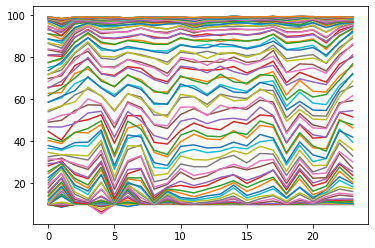

In [25]:
import matplotlib.pyplot as plt

plt.plot(acc_list)
plt.show()

In [ ]:
acc_list

In [ ]:
model.sc1.conv1.weight

In [ ]:
model.eval()

In [ ]:
len(trainloader)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for images in tqdm(testloader):
        c1 = images[0][0].to(device)
        c2 = images[1][0].to(device)
        c3 = images[2][0].to(device)
        c4 = images[3][0].to(device)
        c5 = images[4][0].to(device)
        labels = images[0][1].to(device)
        outputs = model(c1,c2,c3,c4,c5)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(total,correct,end='')

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

In [ ]:
c1.size()[0]

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for images in tqdm(testloader):
        c1 = images[0][0].to(device)
        c2 = images[1][0].to(device)
        c3 = images[2][0].to(device)
        c4 = images[3][0].to(device)
        c5 = images[4][0].to(device)
        labels = images[0][1].to(device)
        outputs = model(c1,c2,c3,c4,c5)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

In [ ]:
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

In [ ]:
labels

In [ ]:
output.size()

In [ ]:
c6.size()

In [ ]:
SIZED_VAL_PATH = 'sized_val'

new_path = []

for i in os.listdir('mnist_sized'):
    #print(i)
    temp = []
    for j in range(1,6):
        temp.append(os.path.join(SIZED_VAL_PATH,str(i),'ds'+str(j)))
    new_path.append(temp)

#new_path

In [ ]:
new_path.sort(key=lambda x:int(x[0].split('/')[1]))
new_path

In [ ]:
val_gen_arr = []
for i in tqdm(range(len(new_path))):
    transform = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testMnistDataset = SizedMnistDataset(new_path[i],transform)

    testloader = torch.utils.data.DataLoader(testMnistDataset,
                                              batch_size = batch_size, 
                                              shuffle=False,
                                            num_workers=8,
                                            pin_memory=True)
    val_gen_arr.append(testloader)

In [ ]:
#val_gen_arr

In [ ]:
accuracy = []

for testloader in tqdm(val_gen_arr):
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images in testloader:
            c1 = images[0][0].to(device)
            c2 = images[1][0].to(device)
            c3 = images[2][0].to(device)
            c4 = images[3][0].to(device)
            c5 = images[4][0].to(device)
            val_labels = images[0][1].to(device)
            outputs = model(c1,c2,c3,c4,c5)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == val_labels).squeeze()
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
            for i in range(len(val_labels)):
                val_label = val_labels[i]
                class_correct[val_label] += c[i].item()
                class_total[val_label] += 1

        for i in range(10):
            if class_total[i]==0:
                print('class_total = 0',class_correct,class_total)
            else:
                print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))
            #print(total,correct,end='')

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    accuracy.append((100 * correct / total))

In [ ]:
for i in range(len(accuracy)):
    print(i,accuracy[i])

In [ ]:
for i in range(len(accuracy)):
    print(accuracy[i],',',end='')

In [ ]:
torch.save(model.state_dict(),'deepscln_jan20.pt')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(accuracy)
plt.show()

In [ ]:
import csv

csvfile = open('test.csv','w',newline="")

csvwriter = csv.writer(csvfile)
for row in [accuracy]:
    csvwriter.writerow(row)
    
csvfile.close()